In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model, get_train_val_iterator, MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [3]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)
from scipy.spatial.distance import mahalanobis
def distance(row, inv_cov, cluster_center,z_col_names):
    return mahalanobis(row[z_col_names].values, cluster_center, inv_cov)


import scipy as sp

def compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers):

    for i in range(num_clusters):
        df["distance_{}".format(i)] = 100000
    for cluster_num in range(num_clusters):
        indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
        lv= df[z_col_names].values[indices, :]
        print(lv.shape)
        cov = np.cov(lv.T)
        inv_cov = sp.linalg.inv(cov)
        df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                       inv_cov,
                                                                                                       cluster_centers[cluster_num],
                                                                                                       z_col_names),
                                                                                     axis=1)


In [4]:
def compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers):
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            lv= df[z_col_names].values[indices, :]
            cov = np.cov(lv.T)
            inv_cov = sp.linalg.inv(cov)

            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               inv_cov,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


# Set experiment parameters

In [5]:
z_dim = 10
run_id = 46
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

In [6]:
experiment_name = "semi_sup_gaussian_mah_k10"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=10,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [7]:
# K = exp_config.confidence_decay_factor
# def convert_distance_to_confidence(dist):
#     return np.exp(-1 / K * dist)

# def get_percentage_correct(confidence):
#     df1 = df[df["manual_annotation_confidence"] > confidence]
#     if df1.shape[0] != 0:
#         df2 = df1[df1["manual_annotation"] == df1["label"]]        
#         return df2.shape[0] / df1.shape[0]
#     else:
#         return 1
# def get_distance(confidence):
#     return -K * log(confidence)
# def get_confidence(distance):
#     return np.exp(-distance/K)

K = exp_config.confidence_decay_factor
def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))

def get_confidence(distance):
    return np.exp(-distance * distance/K)


In [8]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [13]:
num_epochs = 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Warning /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Creating random prio

Epoch: 0/67, Nll_loss : 192.12289428710938 KLD:1.0359997749328613  Supervised loss:0.0
Epoch: 0/68, Nll_loss : 205.40188598632812 KLD:1.0743608474731445  Supervised loss:0.0
Epoch: 0/69, Nll_loss : 209.60736083984375 KLD:1.0389820337295532  Supervised loss:0.0
Epoch: 0/70, Nll_loss : 201.0767364501953 KLD:1.0644218921661377  Supervised loss:0.0
Epoch: 0/71, Nll_loss : 202.6593780517578 KLD:1.1628706455230713  Supervised loss:0.0
Epoch: 0/72, Nll_loss : 199.97512817382812 KLD:1.286726474761963  Supervised loss:0.0
Epoch: 0/73, Nll_loss : 201.2462158203125 KLD:1.1231553554534912  Supervised loss:0.0
Epoch: 0/74, Nll_loss : 209.92300415039062 KLD:1.1775925159454346  Supervised loss:0.0
Epoch: 0/75, Nll_loss : 194.128662109375 KLD:1.3027141094207764  Supervised loss:0.0
Epoch: 0/76, Nll_loss : 199.78390502929688 KLD:1.4357551336288452  Supervised loss:0.0
Epoch: 0/77, Nll_loss : 199.55459594726562 KLD:1.2744884490966797  Supervised loss:0.0
Epoch: 0/78, Nll_loss : 204.21995544433594 KLD:1.

Epoch: 0/162, Nll_loss : 176.05776977539062 KLD:2.837278366088867  Supervised loss:0.0
Epoch: 0/163, Nll_loss : 179.4334259033203 KLD:2.750703811645508  Supervised loss:0.0
Epoch: 0/164, Nll_loss : 177.88131713867188 KLD:3.093522310256958  Supervised loss:0.0
Epoch: 0/165, Nll_loss : 179.6269073486328 KLD:3.0106077194213867  Supervised loss:0.0
Epoch: 0/166, Nll_loss : 177.66702270507812 KLD:3.1500000953674316  Supervised loss:0.0
Epoch: 0/167, Nll_loss : 173.62338256835938 KLD:3.0627150535583496  Supervised loss:0.0
Epoch: 0/168, Nll_loss : 175.34384155273438 KLD:3.0427558422088623  Supervised loss:0.0
Epoch: 0/169, Nll_loss : 169.59237670898438 KLD:3.546081781387329  Supervised loss:0.0
Epoch: 0/170, Nll_loss : 171.15521240234375 KLD:3.867128610610962  Supervised loss:0.0
Epoch: 0/171, Nll_loss : 174.06643676757812 KLD:3.3468053340911865  Supervised loss:0.0
Epoch: 0/172, Nll_loss : 169.78689575195312 KLD:3.106468915939331  Supervised loss:0.0
Epoch: 0/173, Nll_loss : 176.53591918945

Epoch: 0/259, Nll_loss : 153.9412841796875 KLD:4.584928035736084  Supervised loss:0.0
Epoch: 0/260, Nll_loss : 154.0615234375 KLD:4.643319606781006  Supervised loss:0.0
Epoch: 0/261, Nll_loss : 155.15402221679688 KLD:4.809919357299805  Supervised loss:0.0
Epoch: 0/262, Nll_loss : 153.55670166015625 KLD:4.68461275100708  Supervised loss:0.0
Epoch: 0/263, Nll_loss : 162.87106323242188 KLD:4.516622543334961  Supervised loss:0.0
Epoch: 0/264, Nll_loss : 147.33123779296875 KLD:4.783370018005371  Supervised loss:0.0
Epoch: 0/265, Nll_loss : 157.89492797851562 KLD:4.431221961975098  Supervised loss:0.0
Epoch: 0/266, Nll_loss : 154.60028076171875 KLD:4.598358154296875  Supervised loss:0.0
Epoch: 0/267, Nll_loss : 157.67926025390625 KLD:4.307229042053223  Supervised loss:0.0
Epoch: 0/268, Nll_loss : 163.01893615722656 KLD:4.789068222045898  Supervised loss:0.0
Epoch: 0/269, Nll_loss : 164.99539184570312 KLD:4.422904014587402  Supervised loss:0.0
Epoch: 0/270, Nll_loss : 159.96762084960938 KLD:4

Epoch: 0/354, Nll_loss : 147.00936889648438 KLD:5.412680625915527  Supervised loss:0.0
Epoch: 0/355, Nll_loss : 160.0765380859375 KLD:5.417438983917236  Supervised loss:0.0
Epoch: 0/356, Nll_loss : 149.26296997070312 KLD:5.293174743652344  Supervised loss:0.0
Epoch: 0/357, Nll_loss : 150.80841064453125 KLD:5.34853458404541  Supervised loss:0.0
Epoch: 0/358, Nll_loss : 145.1700897216797 KLD:5.4441914558410645  Supervised loss:0.0
Epoch: 0/359, Nll_loss : 153.58221435546875 KLD:5.567663192749023  Supervised loss:0.0
Epoch: 0/360, Nll_loss : 144.524169921875 KLD:5.560479164123535  Supervised loss:0.0
Epoch: 0/361, Nll_loss : 147.78077697753906 KLD:5.484663009643555  Supervised loss:0.0
Epoch: 0/362, Nll_loss : 147.9739990234375 KLD:5.221456527709961  Supervised loss:0.0
Epoch: 0/363, Nll_loss : 148.08840942382812 KLD:5.116179466247559  Supervised loss:0.0
Epoch: 0/364, Nll_loss : 153.05197143554688 KLD:4.804235935211182  Supervised loss:0.0
Epoch: 0/365, Nll_loss : 148.7813262939453 KLD:5

Epoch: 0/449, Nll_loss : 147.45999145507812 KLD:5.379277229309082  Supervised loss:0.0
Epoch: 0/450, Nll_loss : 151.69114685058594 KLD:5.273436546325684  Supervised loss:0.0
Epoch: 0/451, Nll_loss : 147.22079467773438 KLD:5.595773696899414  Supervised loss:0.0
Epoch: 0/452, Nll_loss : 143.301025390625 KLD:5.856769561767578  Supervised loss:0.0
Epoch: 0/453, Nll_loss : 151.42291259765625 KLD:6.198512077331543  Supervised loss:0.0
Epoch: 0/454, Nll_loss : 137.90353393554688 KLD:6.059885501861572  Supervised loss:0.0
Epoch: 0/455, Nll_loss : 139.744384765625 KLD:6.1764397621154785  Supervised loss:0.0
Epoch: 0/456, Nll_loss : 147.14993286132812 KLD:6.230572700500488  Supervised loss:0.0
Epoch: 0/457, Nll_loss : 134.1421661376953 KLD:5.973335266113281  Supervised loss:0.0
Epoch: 0/458, Nll_loss : 141.0836944580078 KLD:5.808931350708008  Supervised loss:0.0
Epoch: 0/459, Nll_loss : 143.91152954101562 KLD:5.938193321228027  Supervised loss:0.0
Epoch: 0/460, Nll_loss : 143.83871459960938 KLD:

Epoch: 0/544, Nll_loss : 146.77847290039062 KLD:6.213294982910156  Supervised loss:0.0
Epoch: 0/545, Nll_loss : 145.83767700195312 KLD:6.257563591003418  Supervised loss:0.0
Epoch: 0/546, Nll_loss : 139.34814453125 KLD:6.058319568634033  Supervised loss:0.0
Epoch: 0/547, Nll_loss : 143.41665649414062 KLD:5.962821006774902  Supervised loss:0.0
Epoch: 0/548, Nll_loss : 133.38880920410156 KLD:5.884749412536621  Supervised loss:0.0
Epoch: 0/549, Nll_loss : 137.95155334472656 KLD:5.741426944732666  Supervised loss:0.0
Epoch: 0/550, Nll_loss : 138.16357421875 KLD:5.936522483825684  Supervised loss:0.0
Epoch: 0/551, Nll_loss : 140.6890869140625 KLD:5.724680423736572  Supervised loss:0.0
Epoch: 0/552, Nll_loss : 135.05377197265625 KLD:5.327243328094482  Supervised loss:0.0
Epoch: 0/553, Nll_loss : 142.69149780273438 KLD:5.712644100189209  Supervised loss:0.0
Epoch: 0/554, Nll_loss : 140.01759338378906 KLD:5.862246990203857  Supervised loss:0.0
Epoch: 0/555, Nll_loss : 141.9525604248047 KLD:6.1

Epoch: 0/641, Nll_loss : 142.20916748046875 KLD:5.595806121826172  Supervised loss:0.0
Epoch: 0/642, Nll_loss : 150.72445678710938 KLD:6.158799648284912  Supervised loss:0.0
Epoch: 0/643, Nll_loss : 141.94772338867188 KLD:6.288324356079102  Supervised loss:0.0
Epoch: 0/644, Nll_loss : 138.20689392089844 KLD:6.389486789703369  Supervised loss:0.0
Epoch: 0/645, Nll_loss : 130.05685424804688 KLD:6.6093902587890625  Supervised loss:0.0
Epoch: 0/646, Nll_loss : 139.56201171875 KLD:6.597517967224121  Supervised loss:0.0
Epoch: 0/647, Nll_loss : 132.449462890625 KLD:6.471755027770996  Supervised loss:0.0
Epoch: 0/648, Nll_loss : 139.28143310546875 KLD:6.606892108917236  Supervised loss:0.0
Epoch: 0/649, Nll_loss : 140.31997680664062 KLD:6.117858409881592  Supervised loss:0.0
Epoch: 0/650, Nll_loss : 132.42507934570312 KLD:5.860537052154541  Supervised loss:0.0
Epoch: 0/651, Nll_loss : 144.42291259765625 KLD:5.86176872253418  Supervised loss:0.0
Epoch: 0/652, Nll_loss : 135.92050170898438 KLD:

Epoch: 0/736, Nll_loss : 129.34823608398438 KLD:5.846436500549316  Supervised loss:0.0
Epoch: 0/737, Nll_loss : 129.38418579101562 KLD:6.449077606201172  Supervised loss:0.0
Epoch: 0/738, Nll_loss : 143.5377197265625 KLD:6.41630744934082  Supervised loss:0.0
Epoch: 0/739, Nll_loss : 123.53338623046875 KLD:6.268466949462891  Supervised loss:0.0
Epoch: 0/740, Nll_loss : 135.59371948242188 KLD:6.340031623840332  Supervised loss:0.0
Epoch: 0/741, Nll_loss : 135.7982940673828 KLD:6.0792741775512695  Supervised loss:0.0
Epoch: 0/742, Nll_loss : 129.5814208984375 KLD:6.1500091552734375  Supervised loss:0.0
Epoch: 0/743, Nll_loss : 147.69979858398438 KLD:6.545679569244385  Supervised loss:0.0
Epoch: 0/744, Nll_loss : 130.46702575683594 KLD:6.5050740242004395  Supervised loss:0.0
Epoch: 0/745, Nll_loss : 130.89137268066406 KLD:6.747419357299805  Supervised loss:0.0
Epoch: 0/746, Nll_loss : 131.923095703125 KLD:7.14802360534668  Supervised loss:0.0
Epoch: 0/747, Nll_loss : 135.41983032226562 KLD

Epoch: 0/833, Nll_loss : 127.5037612915039 KLD:6.330418586730957  Supervised loss:0.0
Epoch: 0/834, Nll_loss : 140.9968719482422 KLD:6.2382917404174805  Supervised loss:0.0
Epoch: 0/835, Nll_loss : 135.4829864501953 KLD:6.293717384338379  Supervised loss:0.0
Epoch: 0/836, Nll_loss : 138.72943115234375 KLD:6.305890083312988  Supervised loss:0.0
Epoch: 0/837, Nll_loss : 135.12069702148438 KLD:6.1700944900512695  Supervised loss:0.0
Epoch: 0/838, Nll_loss : 131.8326416015625 KLD:6.336336135864258  Supervised loss:0.0
Epoch: 0/839, Nll_loss : 141.064453125 KLD:6.301889419555664  Supervised loss:0.0
Epoch: 0/840, Nll_loss : 135.31893920898438 KLD:6.727240562438965  Supervised loss:0.0
Epoch: 0/841, Nll_loss : 132.8350830078125 KLD:6.872931480407715  Supervised loss:0.0
Epoch: 0/842, Nll_loss : 129.01754760742188 KLD:6.563846111297607  Supervised loss:0.0
Epoch: 0/843, Nll_loss : 118.42373657226562 KLD:6.587952613830566  Supervised loss:0.0
Epoch: 0/844, Nll_loss : 132.57986450195312 KLD:6.5

Epoch: 0/929, Nll_loss : 139.84463500976562 KLD:5.873434066772461  Supervised loss:0.0
Epoch: 0/930, Nll_loss : 130.65283203125 KLD:6.250397682189941  Supervised loss:0.0
Epoch: 0/931, Nll_loss : 136.88172912597656 KLD:5.982815265655518  Supervised loss:0.0
Epoch: 0/932, Nll_loss : 137.92398071289062 KLD:5.898022651672363  Supervised loss:0.0
Epoch: 0/933, Nll_loss : 125.7900619506836 KLD:6.3358893394470215  Supervised loss:0.0
Epoch: 0/934, Nll_loss : 130.8538360595703 KLD:6.359195709228516  Supervised loss:0.0
Epoch: 0/934, Nll_loss : 130.8538360595703
Completed 0 epochs
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/analysis/
Running evaluation after epoch:1 and step:935 
epoch:1 step:935
Saving evaluation results to  /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/analysis/
Running evaluation after epoch:1 and s

# Load the trained model

In [9]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/

# Read the latent vectors for train data

In [10]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=46 z_min=-4.8730955 z_max=4.3410335
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [11]:
train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                 dao= dao,
                                                 exp_config= exp_config,
                                                 num_epochs_completed=0,
                                                 split_name=exp_config.split_name)

Warning /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Creating random prior with uniform distribution
Number of samples with manual annotation 0.0


In [12]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 1.0


# Use Elbow method to to find out number of optimum clusters k

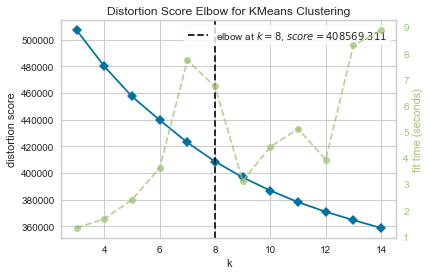

In [18]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [19]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
#num_clusters = 16

In [13]:
num_clusters=10

In [15]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [21]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [9, 1, -1, 2,
                                               0, 7, 1, 6,
                                               3, 8
                                              ]
    manual_annotation_json["manual_confidence"] = [0.8, 1, 0, 0.8,
                                                  1, 0.7, 1, 0.9,
                                                  0.8, 0.8]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [16]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [17]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [18]:
cluster_group_dict

{'good_clusters': <clearn.analysis.ClusterGroup at 0x7fbba2551bd0>,
 None: <clearn.analysis.ClusterGroup at 0x7fbba2551dd0>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fbba2551c90>}

In [19]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


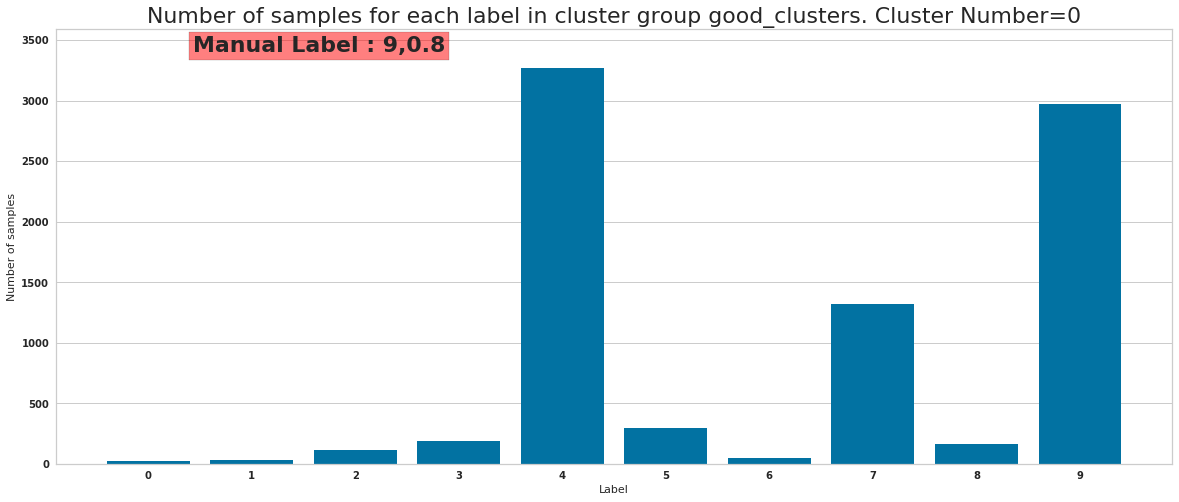

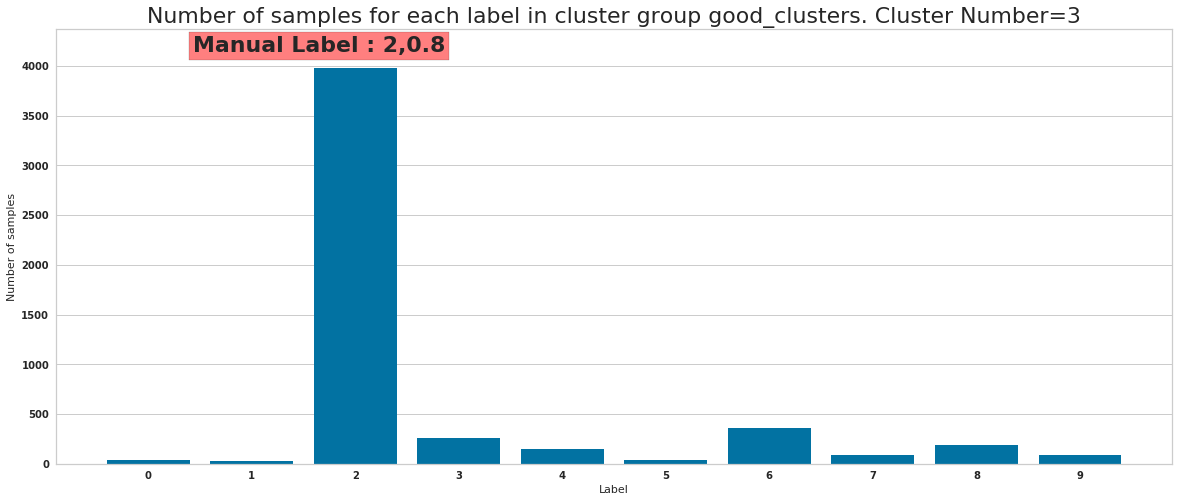

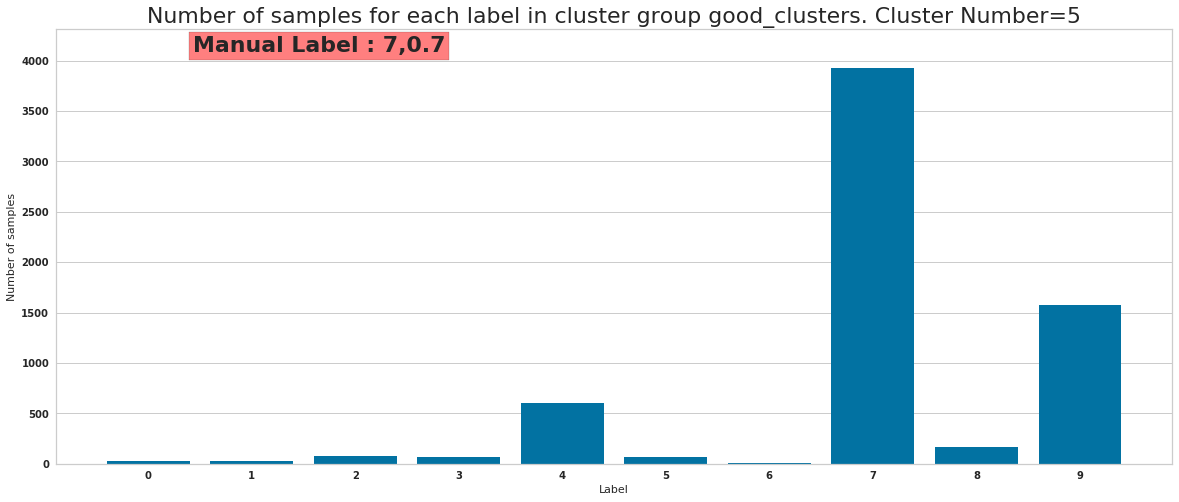

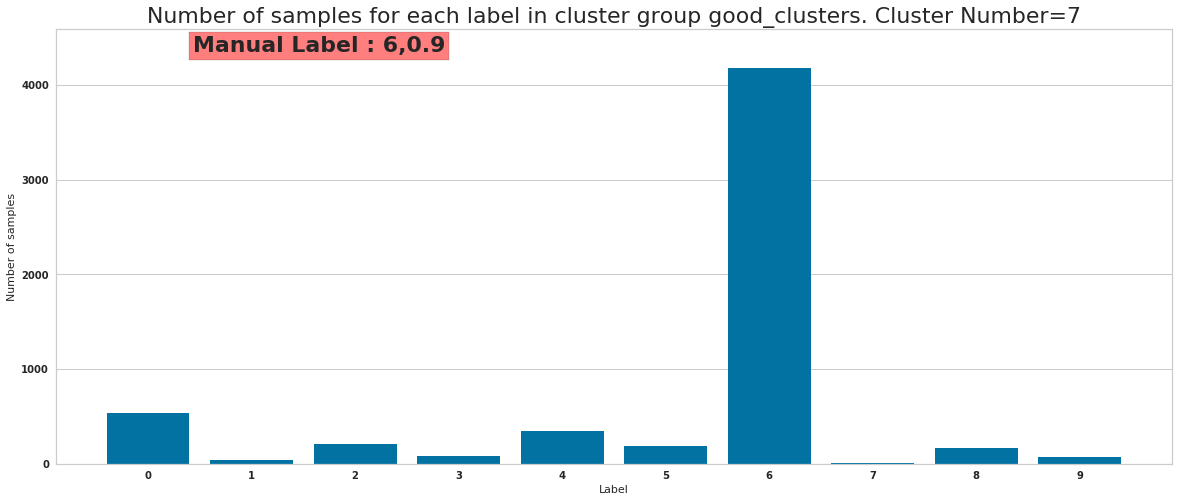

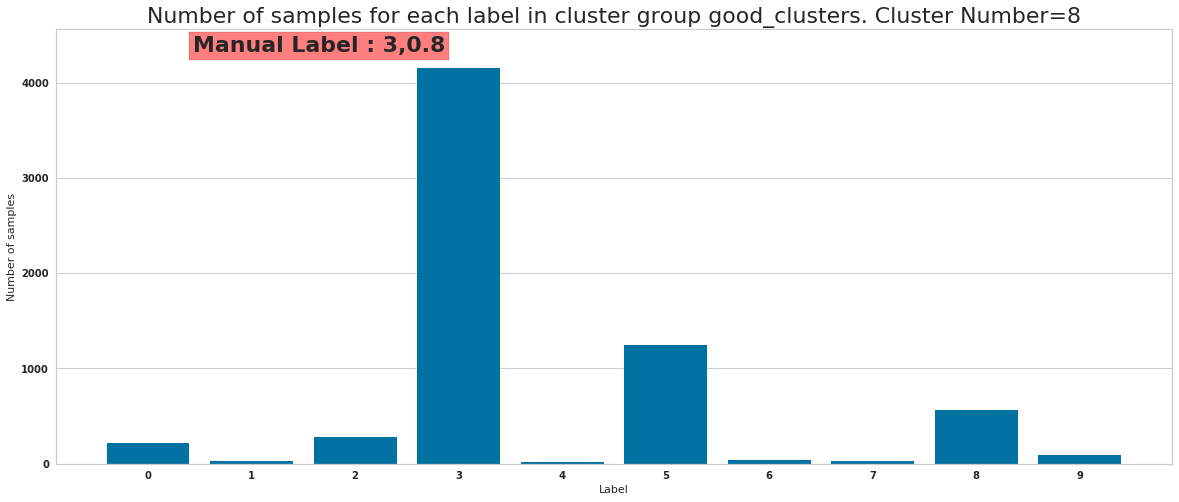

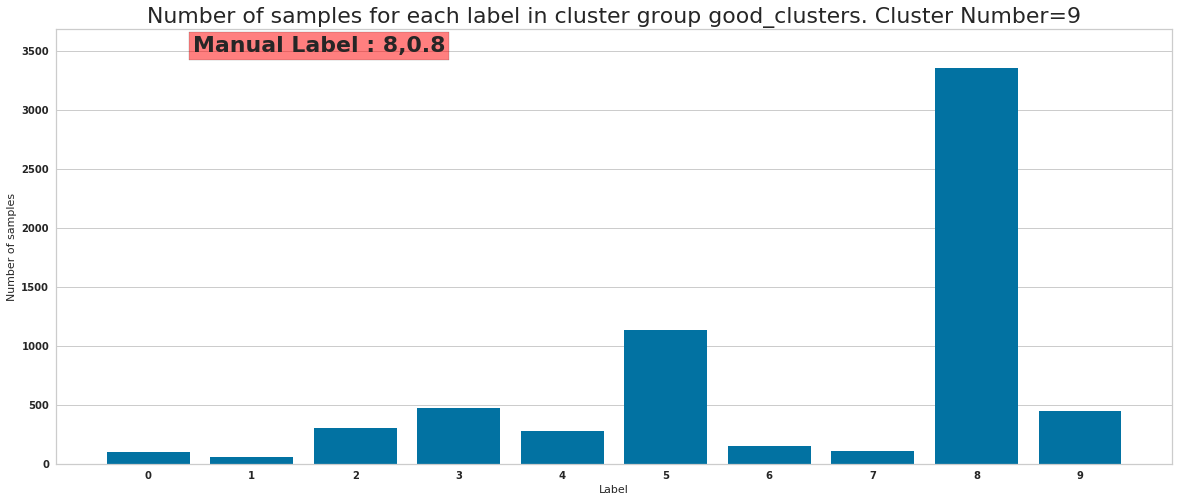

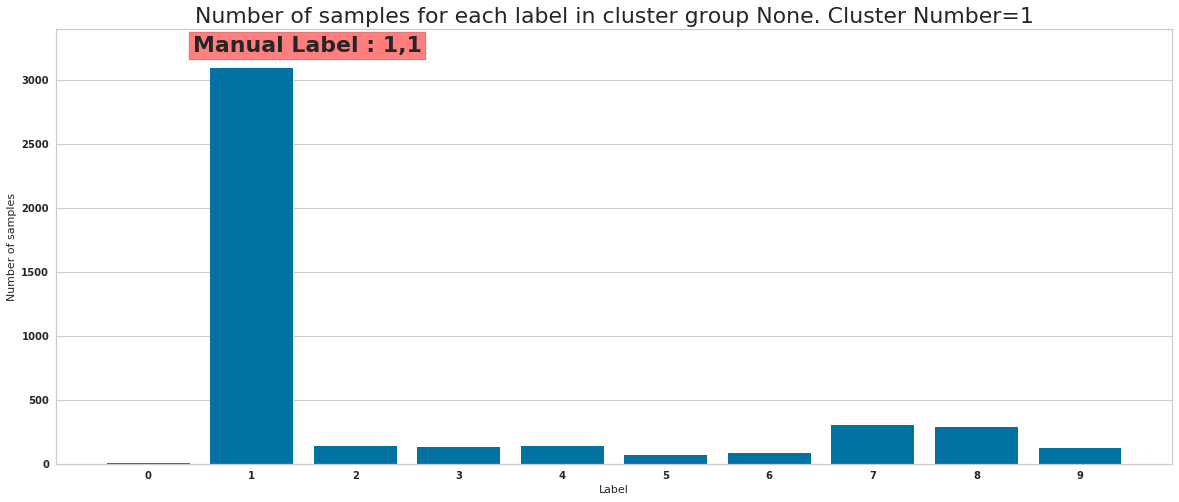

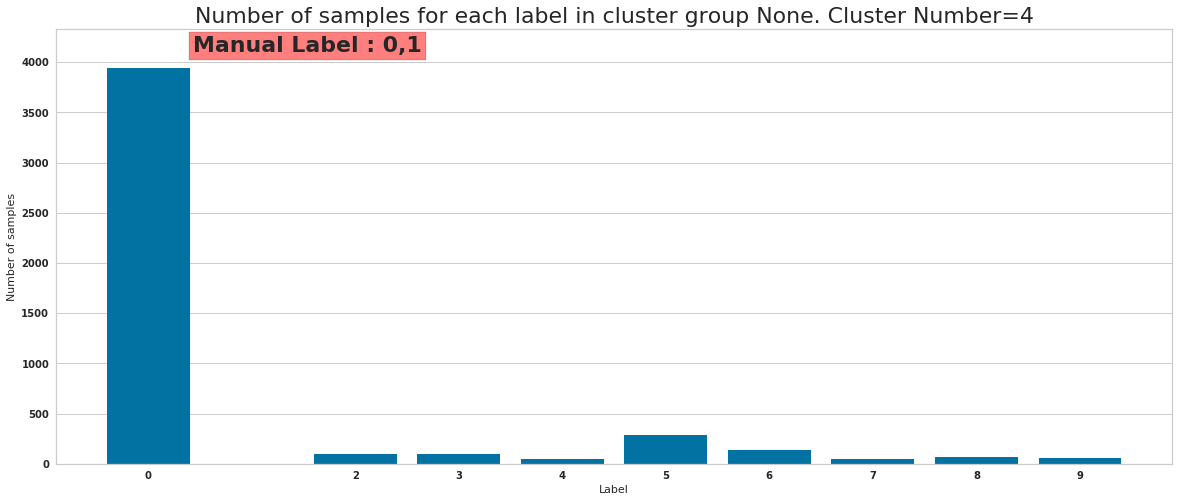

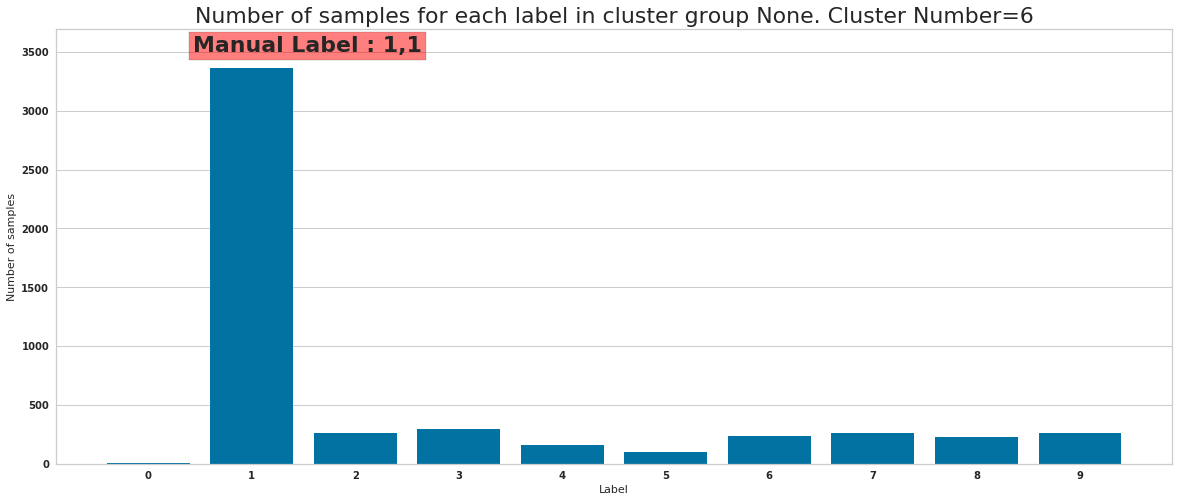

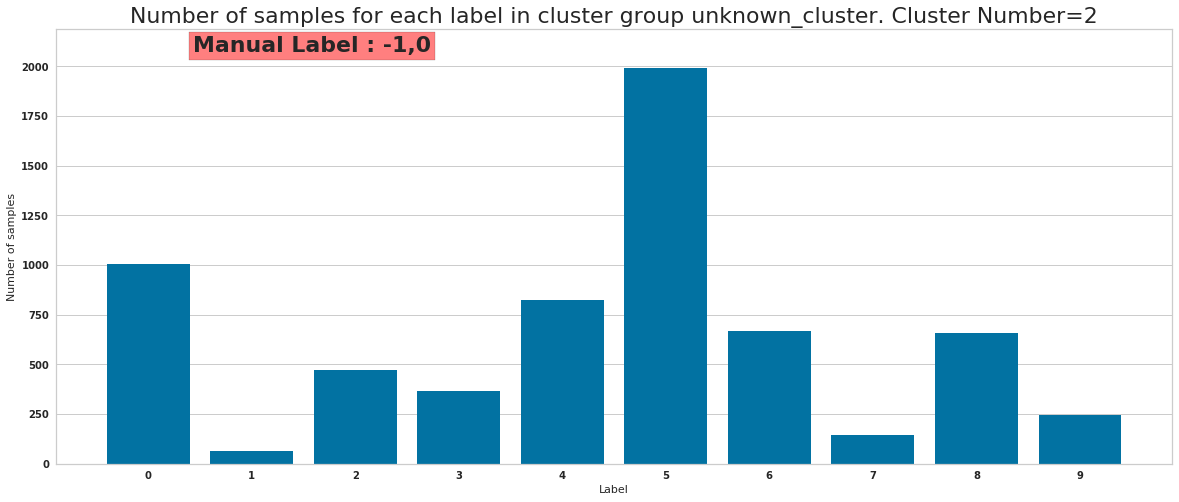

In [20]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [21]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(8420, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(4367, 10)
(6450, 10)
(5214, 10)
(4773, 10)
(6524, 10)
(5172, 10)
(5838, 10)
(6677, 10)
(6405, 10)


In [21]:
df.columns

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'sigma_0', 'sigma_1', 'sigma_2',
       'sigma_3', 'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8',
       'sigma_9', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'cluster_level_1', 'distance_0', 'distance_1',
       'distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6',
       'distance_7', 'distance_8', 'distance_9'],
      dtype='object')

In [22]:
df[df["cluster_level_1"] == 0].shape

(8420, 43)

In [23]:
df[(df["cluster_level_1"] == 0) & (df["label"] == 9) ].shape

(2973, 43)

In [51]:
lv_9_9 = df[(df["cluster_level_1"] == 0) & (df["label"] == 9) ][z_col_names].values
lv_9_9.shape

(2973, 10)

In [52]:
lv_4_9 = df[(df["cluster_level_1"] == 0) & (df["label"] == 4) ][z_col_names].values
lv_4_9.shape

(3266, 10)

In [53]:
from clearn.analysis.cluster_utils import decode_latent_vectors

In [54]:
tf.reset_default_graph()
images_4_9 =  decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                          lv_4_9,
                          exp_config,
                          dao)

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10

In [55]:
images_4_9.shape

(3266, 28, 28, 1)

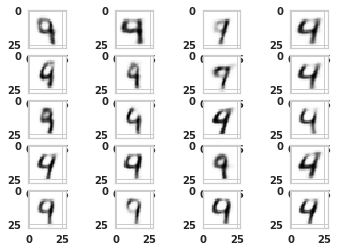

In [56]:
display_cluster_center_images(images_4_9[0:20, :, :, :], "images_4_9.png", images_4_9[0:20, :])


In [58]:
indices_0 = df["cluster_level_1"].values == 0
print(indices_0.shape)
indices_9 = df["label"].values == 4
print(indices_9.shape)

lv_4_9_indices_bool = indices_0 & indices_9
lv_4_9_indices = np.where(lv_4_9_indices_bool)[0]
print(lv_4_9_indices.shape)
images_4_9_orig = images[lv_4_9_indices,:,:,:]

(59840,)
(59840,)
(3266,)


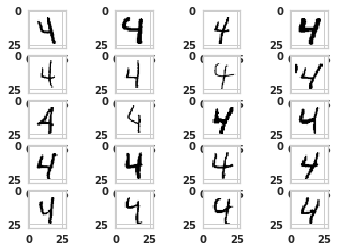

In [59]:
display_cluster_center_images(images_4_9_orig[0:20, :, :, :], "images_4_9.png", images_4_9_orig[0:20, :])


In [60]:
def get_mean(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.mean(axis=0)
    return mu_0


def get_min(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.min(axis=0)
    return mu_0


def get_max(i,df,mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.max(axis=0)
    return mu_0

mu_mean = []
mu_min = []
mu_max =[]
for i in unique_labels:
    mu_mean.append( get_mean(i, df,z_col_names) )
    mu_min.append( get_min(i, df,z_col_names) )
    mu_max.append( get_max(i, df,z_col_names) )


In [61]:
def trace(exp_config, trace_from, trace_to, mu_mean, num_trace_steps, d):    
    z = np.zeros([num_trace_steps , exp_config.Z_DIM])
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, d ] = alpha_i * mu_mean[trace_to][d] + (1 - alpha_i) * mu_mean[trace_from][d]
    return z
    
    

In [62]:
d = list(range(len(unique_labels)))
num_trace_steps = 36
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = dao,
      exp_config=exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

        
    total_latent_vectors = len(unique_labels) + (len(unique_labels) - 1) * num_trace_steps
    if total_latent_vectors < exp_config.BATCH_SIZE:
        total_latent_vectors = exp_config.BATCH_SIZE
    z = np.zeros([total_latent_vectors, exp_config.Z_DIM])
    for i in range(len(mu_mean)):
        z[i, :] = mu_mean[i]
    num_latent_vectors = len(mu_mean)
        
    for label_index in range(len(unique_labels) - 1):
        traced_from_to = trace(exp_config, label_index, label_index + 1, mu_mean, num_trace_steps, d)
        for i in range(num_trace_steps):
            z[ num_latent_vectors, :] = traced_from_to[i]
            num_latent_vectors += 1
    reconstructed_images = decode(model, z, exp_config.BATCH_SIZE)

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10

In [68]:
d = list(range(len(unique_labels)))
num_trace_steps = 36
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    model = get_model(dao = dao,
      exp_config=exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

        
    total_latent_vectors = num_trace_steps
    if total_latent_vectors < exp_config.BATCH_SIZE:
        total_latent_vectors = exp_config.BATCH_SIZE
    z = np.zeros([total_latent_vectors, exp_config.Z_DIM])
    num_latent_vectors = 0
    label_index_from = 4
    label_index_to = 9
    traced_from_to = trace(exp_config, label_index_from, label_index_to, mu_mean, num_trace_steps, d)
    for i in range(num_trace_steps):
        z[ num_latent_vectors, :] = traced_from_to[i]
        num_latent_vectors += 1
    reconstructed_images_4_9 = decode(model, z, exp_config.BATCH_SIZE)

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10

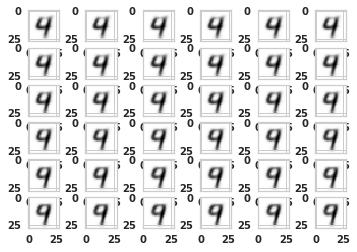

In [71]:
num_images_plotted =0 
title_string = "Images obtained by gradually changing \n the latent vector digit {} to {}"
j = 4
fig = plt.figure()
# fig.suptitle(title_string.format(4, 9))
for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
    ax = fig.add_subplot(6, 6, i-num_images_plotted + 1)
    ax.imshow(np.squeeze(reconstructed_images_4_9[i]), cmap=colormap)
num_images_plotted += num_trace_steps
#plt.savefig(ANALYSIS_PATH+"trace_path_{}.png".format(j))

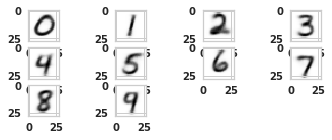

In [72]:
colormap = "Greys"
figure = plt.subplot(3, 3, 1)
for i in range(len(unique_labels) ):
    plt.subplot(6, 4, i+1)
    plt.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)

In [73]:
def get_mean(i, df, mean_col_names):
    df_0 = df[df["label"] == i]
    mu_0 = df_0[mean_col_names].values
    mu_0 = mu_0.mean(axis=0)
    return mu_0

In [74]:
def plot_latent_vector(df, labels):
    figure = plt.figure(figsize=(20,10))
    for label in labels:
        mu_mean = get_mean(label, df,mean_col_names)
        plt.plot(mu_mean,label=str(label))
    plt.legend(loc='upper left', shadow=True, fontsize='x-large')
    plt.xticks(list(range(exp_config.Z_DIM)))
    plt.grid(which="major",axis="both")
    plt.title("Mean of Latent vector")


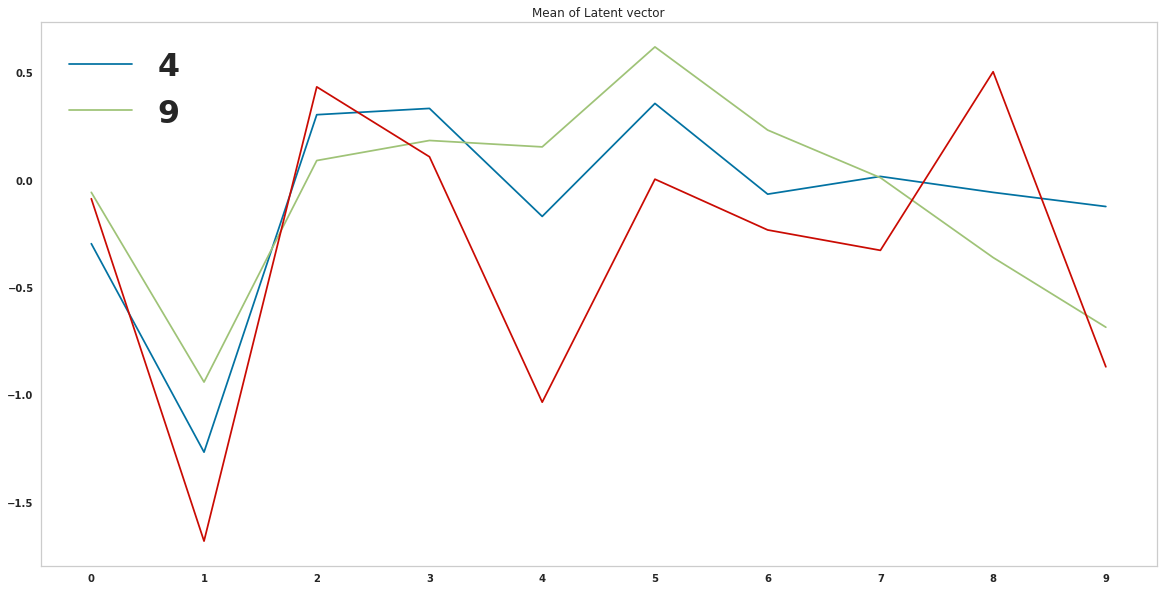

In [75]:
plot_latent_vector(df, [4, 9])
plt.plot(lv_4_9[3, :])

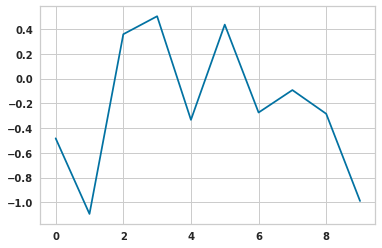

In [76]:
plt.plot(cluster_centers[0])

In [78]:
def trace_dim(exp_config, mu, num_trace_steps,  dim):    
    z = np.zeros([num_trace_steps , exp_config.Z_DIM])
    for i in range(num_trace_steps):
        z[i] = mu
    z_min =  -5
    z_max = 5
        
    step = 1 / num_trace_steps
    for i in range(num_trace_steps):
        alpha_i = step * i
        z[i, dim ] = alpha_i * z_min + (1 - alpha_i) * z_max
    return z
    
    

In [79]:
num_trace_steps = 36
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:

    model = get_model(dao = dao,
      exp_config=exp_config,
      model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
      num_epochs=1,
      sess=sess,
      test_data_iterator=None,
      train_val_data_iterator=None)

    checkpoint_counter = model.load_from_checkpoint()
    print("Check point counter", checkpoint_counter)
    num_latent_vectors = 0
    total_latent_vectors = len(unique_labels) * exp_config.Z_DIM * num_trace_steps
    if total_latent_vectors < exp_config.BATCH_SIZE:
        total_latent_vectors = exp_config.BATCH_SIZE
    z = np.zeros([total_latent_vectors, exp_config.Z_DIM])
    for d in range(10):
        for dimension in range(exp_config.Z_DIM):
            traced_from_to = trace_dim(exp_config, mu_mean[d], num_trace_steps, dimension)
            for i in range(num_trace_steps):
                z[ num_latent_vectors, :] = traced_from_to[i]
                num_latent_vectors += 1
    reconstructed_images = decode(model, z, exp_config.BATCH_SIZE)
    
    z = np.zeros([exp_config.BATCH_SIZE, exp_config.Z_DIM])
    for i in range(10):
        z[i,:] = mu_mean[i]
    reconstructed_images_mean = decode(model, z, exp_config.BATCH_SIZE)

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10

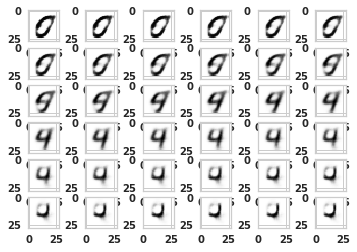

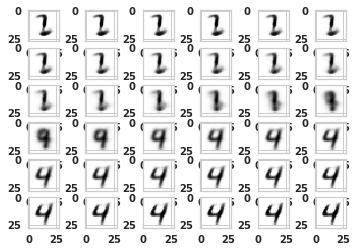

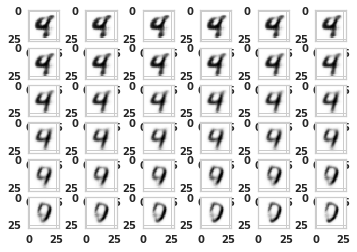

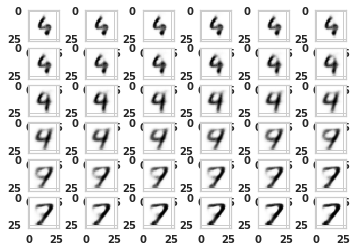

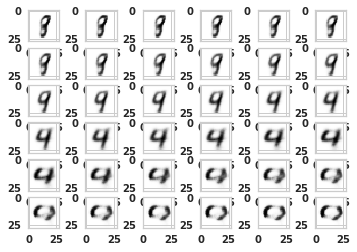

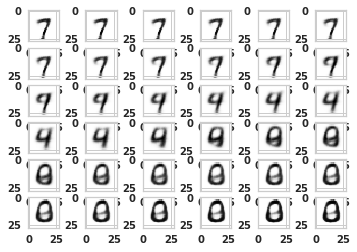

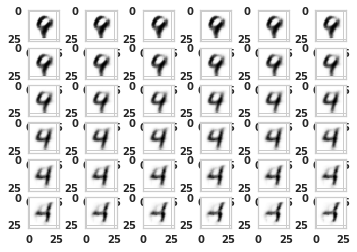

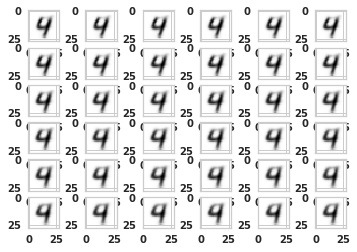

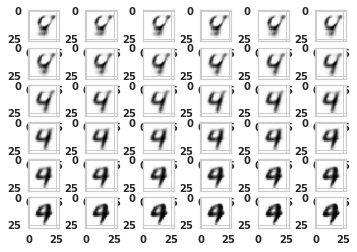

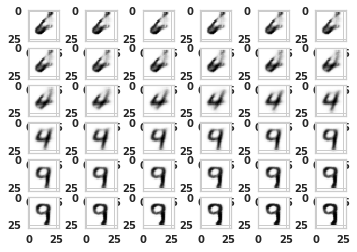

In [80]:
d = 4

num_images_plotted = d * exp_config.Z_DIM * num_trace_steps
title_string = "Images obtained by gradually changing \n the dimension {}  for latent vector of digit {}"
for dim in range(10):
    fig = plt.figure()
    #fig.suptitle(title_string.format(dim,d))
    for i in range(num_images_plotted , num_images_plotted + num_trace_steps):
        ax = fig.add_subplot(6 ,6, i-num_images_plotted + 1)
        ax.imshow(np.squeeze(reconstructed_images[i]), cmap=colormap)
    num_images_plotted += num_trace_steps
    #plt.savefig(ANALYSIS_PATH+"trace_dim_{}.png".format(d))

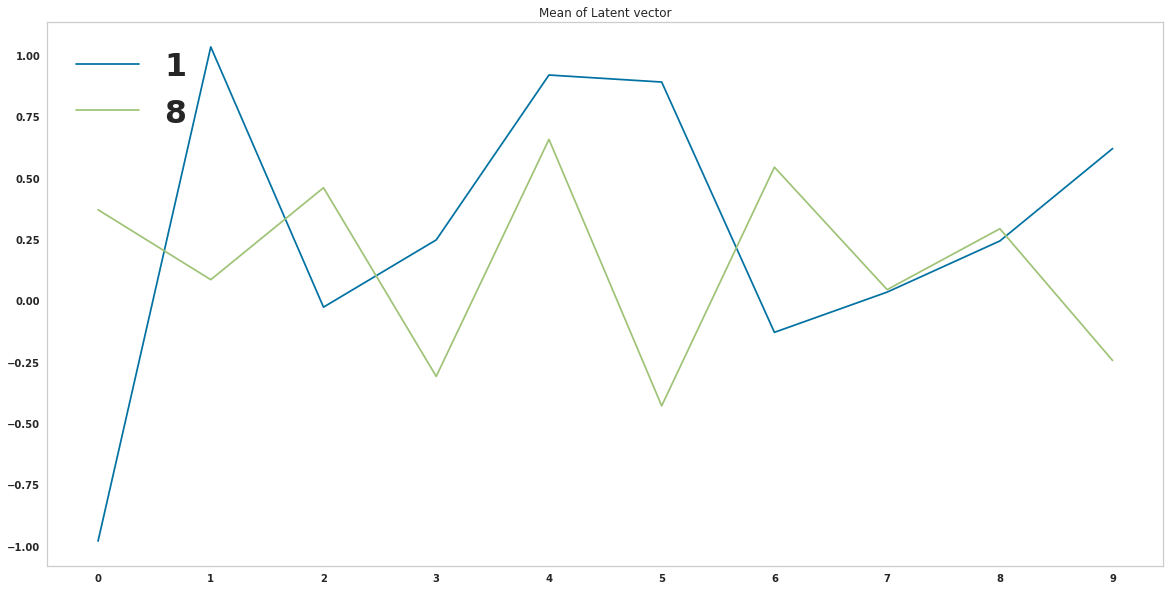

In [81]:
plot_latent_vector(df, [1, 8])

In [ ]:
fig = plt.figure(figsize=(15,25))
#fig.tight_layout()

for i in range(exp_config.Z_DIM):
    lv = df_0 = df[df["label"] == i][z_col_names]
    covar = np.cov(np.transpose(lv))

    ax = fig.add_subplot(10, 2, i * 2 + 1 )
    ax.matshow(covar)
    #fig.colorbar(ax)
    #ax.xticks([])
    ax1 = fig.add_subplot(10, 2, i * 2 + 2)
    ax1.plot(np.mean(lv))

    plt.title(f"Digit {i}")
    plt.tight_layout()


2


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-936"
 
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_6

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


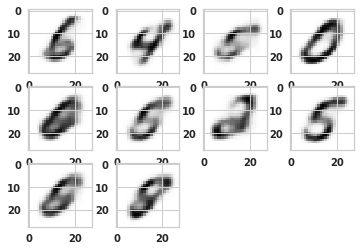

In [22]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [24]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1, -1, -2, 0,
                                         -1, -1, -1, 5,
                                         -1,-1
                                        ]
level_2_cluster_dict["manual_confidences"] = [0,0,0,0.8,
                                              0, 0, 0, 0.6,
                                              0, 0]
level2_manual_annotations[2] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, 9, -1,-1,
#                                         -1,-1,-1,-1,
#                                         -1,4]
# level_2_cluster_dict["manual_confidences"] = [0, 0.7, 0, 0,
#                                               0 , 0 , 0, 0,
#                                               0, 0.6
#                                              ]

# level2_manual_annotations[4] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,9,4,7,
#                                         9,4,9,4,
#                                         4, 9]
# level_2_cluster_dict["manual_confidences"] = [0,0.9,0.6,0.6,
#                                               0.9,0.8,0.8,0.8,
#                                               0.7,0.8
#                                              ]
# level2_manual_annotations[9] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1, 1, -1,
#                                         -1, -1, -1, 1,
#                                         -1, 1]
# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0,0,
#                                               0,0
#                                              ]

# level2_manual_annotations[4] = level_2_cluster_dict



In [25]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

2


In [26]:
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

10
Skipping distance computation for unknown cluster
2 (805,)
3 (726,)
7 (720,)


In [27]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [28]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [29]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [30]:
def assign_manual_label_and_confidence(df,
                                       manual_annotation_dict,
                                       dist_to_conf,
                                       cluster_group_dict,
                                       cluster_column_name_2,
                                       assign_only_correct=False
                                       ):
    def assign_label(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        dst = _distance_df.iloc[_indices]
        _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
        _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0

    df["manual_annotation"] = np.ones(df.shape[0]) * -1
    df["manual_annotation_confidence"] = np.zeros(df.shape[0])
    df["distance_to_confidence"] = np.zeros(df.shape[0])
    # manually given label for each cluster center -1 for unknown (cluster which has no semantic meaning)
    manual_labels = manual_annotation_dict["manual_labels"]
    cluster_labels = np.asarray(manual_annotation_dict["cluster_labels"])

    num_clusters = len(manual_labels)
    for annotate_cluster in range(num_clusters):
        distance_df = df["distance_{}".format(annotate_cluster)]
        manual_label = manual_labels[annotate_cluster]
        _manual_confidence = manual_annotation_dict["manual_confidence"][annotate_cluster]
        if isinstance(manual_label, tuple) or isinstance(manual_label, list):
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            for _cluster in cluster.next_level_clusters["good_clusters"]:
                _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                _manual_label = _cluster.manual_annotation.label
                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                    # TODO add this code
                    pass
                elif _manual_label != -1:
                    assign_label(df, _manual_label)
        elif manual_label != -1:
            print("Manual Label", manual_label)
            indices = np.where(cluster_labels == annotate_cluster)

            df["manual_annotation"].iloc[indices] = manual_label
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
            num_correct = df[(manual_label == df["manual_annotation"]) & (df["label"] == manual_label)].shape[0]
            print("Num correct={}".format(num_correct))

            percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
            print(f"Cluster {annotate_cluster} Manual Label {manual_label} Percentage correct {percentage_correct}")
            dist = distance_df.iloc[indices]
            df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * dist_to_conf(dist)
            if assign_only_correct:
                wrong_indices = (df["manual_annotation"] == manual_label) & (df["label"] != manual_label)
                print(len(wrong_indices), wrong_indices.shape)
                df["manual_annotation_confidence"].loc[wrong_indices] = 0
            df["distance_to_confidence"].iloc[indices] = dist_to_conf(dist)
        else:
            print("unknown")
            # TODO second level clustering is not used now so commenting the code
            # unknown, check if second level clustering is done or not
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(type(cluster.next_level_clusters))
            print(list(cluster.next_level_clusters.keys()))

            for cluster_group_name, cluster_group in cluster.next_level_clusters.items():
                for _cluster in cluster_group:
                    _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                    _manual_label = _cluster.manual_annotation.label
                    print(f"********{_manual_label}*******")
                    if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                        # TODO add this code
                        pass
                    elif _manual_label != -1:
                        print("Manual_label", _manual_label)
                        assign_label(df, _manual_label)
                    else:
                        # Manual label is -1
                        # Label all the 600 samples in the second level cluster
                        indices = np.where((np.asarray(cluster_labels) == cluster.id)
                                           & (df[cluster_column_name_2].values == _cluster.id))[0]
                        print(f"Annotating individual samples {indices.shape}")
                        df["manual_annotation"].iloc[indices] = df["label"][indices].values
                        df["manual_annotation_confidence"].iloc[indices] = 1

                        _dist = _distance_df.iloc[indices]
                        df["distance_to_confidence"].iloc[indices] = dist_to_conf(_dist)

        print("********************************")


In [31]:
assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False
                                  )

Manual Label 9
(8420, 57) (8420, 33)
Num correct=2973
Cluster 0 Manual Label 9 Percentage correct 35.30878859857482
********************************
Manual Label 1
(4367, 57) (4367, 33)
Num correct=3091
Cluster 1 Manual Label 1 Percentage correct 70.7808564231738
********************************
unknown
<class 'dict'>
['unknown_cluster', 'low_confidences_clusters', 'good_clusters', 'average_clusters']
********-1*******
Annotating individual samples (582,)
********-1*******
Annotating individual samples (625,)
********-1*******
Annotating individual samples (593,)
********-1*******
Annotating individual samples (634,)
********-1*******
Annotating individual samples (494,)
********-1*******
Annotating individual samples (598,)
********-1*******
Annotating individual samples (673,)
********-2*******
Manual_label -2
********0*******
Manual_label 0
********5*******
Manual_label 5
********************************
Manual Label 2
(5632, 57) (5214, 33)
Num correct=4391
Cluster 3 Manual Label 2 

# Save the dataframe with manual annotations

In [32]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([8420., 4367., 6450., 5214., 4773., 6524., 5172., 5838., 6677.,
        6405.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

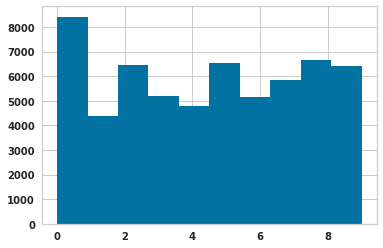

In [33]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [34]:
from clearn.analysis.cluster_utils import plot_distance_distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


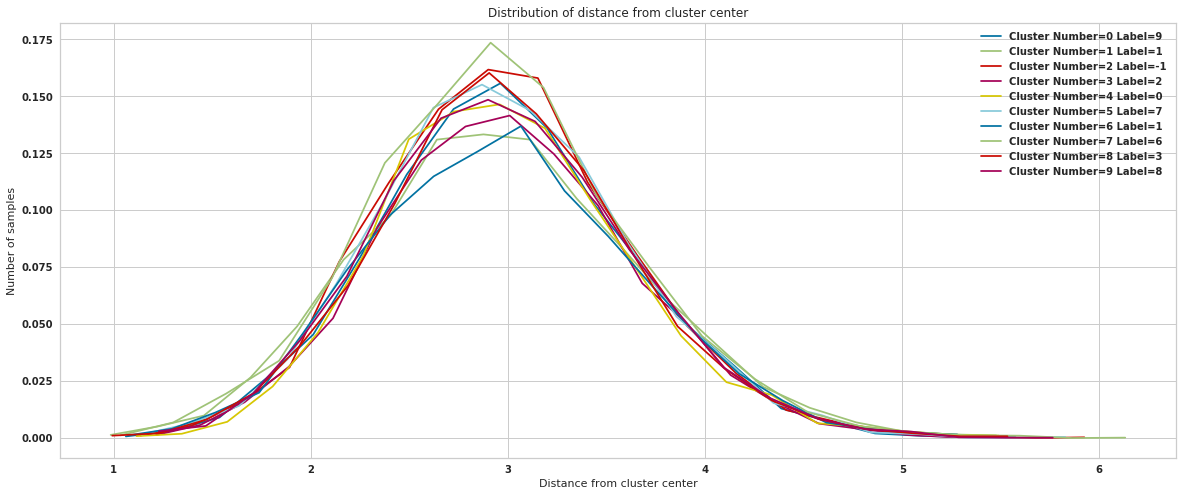

In [35]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

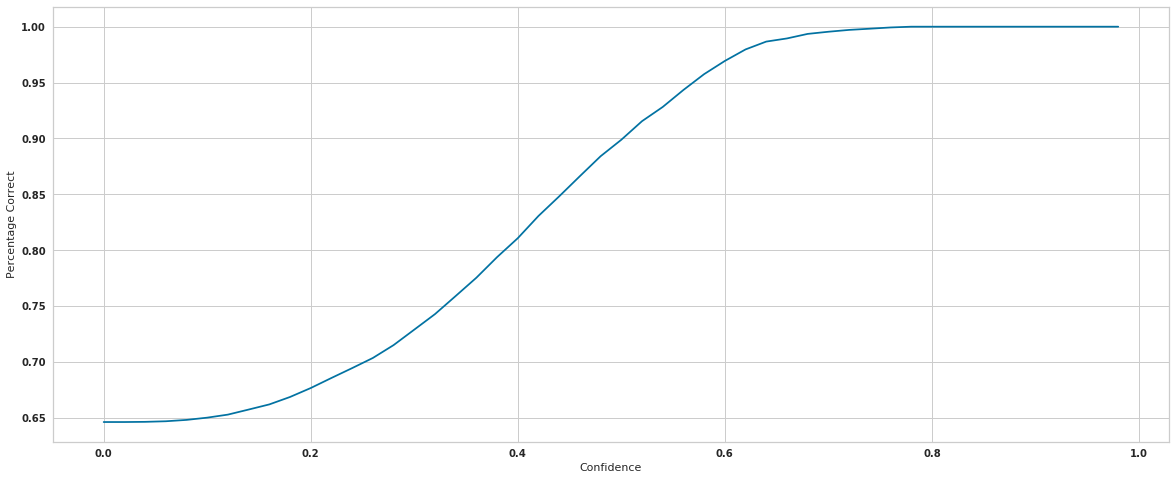

In [36]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

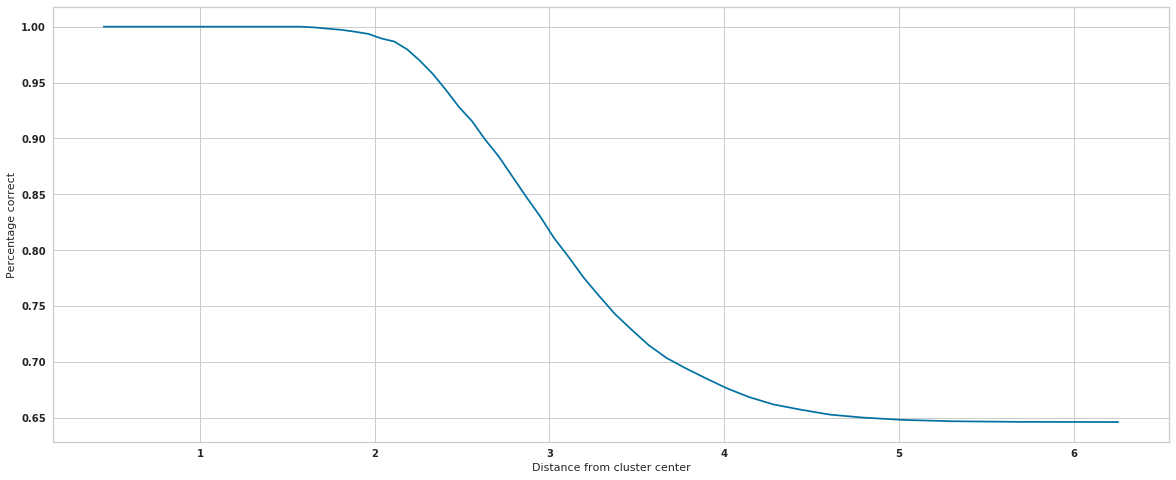

In [37]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [38]:
from shutil import copy2

In [39]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging 
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

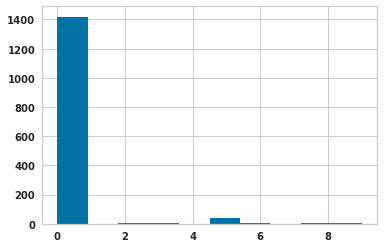

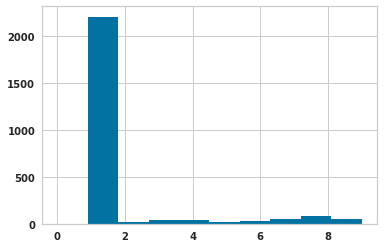

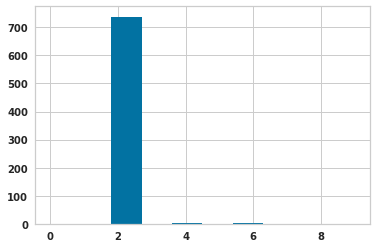

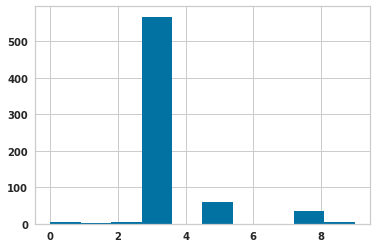

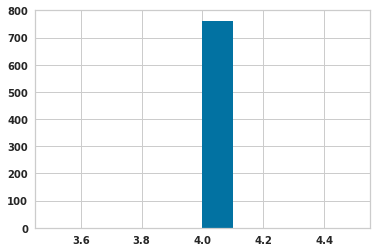

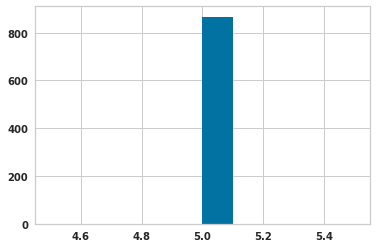

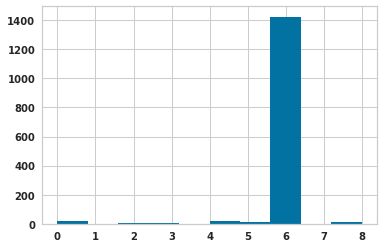

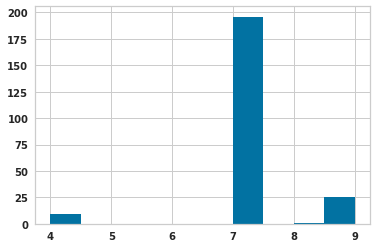

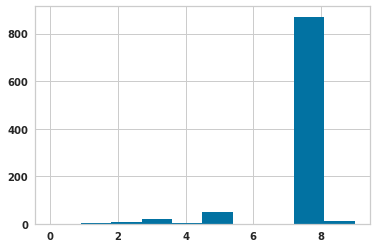

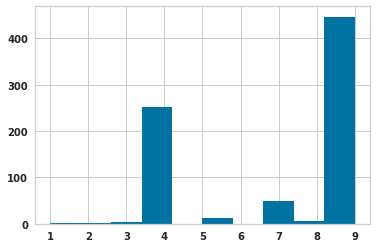

In [40]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 2

In [44]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Loaded manual annotation
Number of samples with manual confidence 59035
Number of samples with manual annotation 22690.227456709792
INFO:tensorflow:Summary name Negative Log Like

Epoch: 1/63, Nll_loss : 144.78982543945312 KLD:9.78018856048584  Supervised loss:0.40271586179733276
Epoch: 1/64, Nll_loss : 139.147216796875 KLD:8.57367992401123  Supervised loss:0.418163925409317
Epoch: 1/65, Nll_loss : 132.6712646484375 KLD:8.465328216552734  Supervised loss:0.40818196535110474
Epoch: 1/66, Nll_loss : 145.71128845214844 KLD:8.54800796508789  Supervised loss:0.3771325349807739
Epoch: 1/67, Nll_loss : 125.36004638671875 KLD:8.582775115966797  Supervised loss:0.4664652943611145
Epoch: 1/68, Nll_loss : 122.15860748291016 KLD:8.639505386352539  Supervised loss:0.4136354625225067
Epoch: 1/69, Nll_loss : 134.98089599609375 KLD:9.56757926940918  Supervised loss:0.43847545981407166
Epoch: 1/70, Nll_loss : 135.2171173095703 KLD:9.511028289794922  Supervised loss:0.3537555932998657
Epoch: 1/71, Nll_loss : 130.07391357421875 KLD:9.797146797180176  Supervised loss:0.3519975543022156
Epoch: 1/72, Nll_loss : 129.3773193359375 KLD:9.811002731323242  Supervised loss:0.40914258360862

Epoch: 1/146, Nll_loss : 133.3498992919922 KLD:8.98805046081543  Supervised loss:0.3230721652507782
Epoch: 1/147, Nll_loss : 123.9334716796875 KLD:9.60054874420166  Supervised loss:0.32948070764541626
Epoch: 1/148, Nll_loss : 133.95571899414062 KLD:9.664923667907715  Supervised loss:0.2767587900161743
Epoch: 1/149, Nll_loss : 141.65350341796875 KLD:9.301682472229004  Supervised loss:0.4242088794708252
Epoch: 1/150, Nll_loss : 126.96390533447266 KLD:8.956766128540039  Supervised loss:0.33450645208358765
Epoch: 1/151, Nll_loss : 131.91517639160156 KLD:9.22313117980957  Supervised loss:0.35560107231140137
Epoch: 1/152, Nll_loss : 130.84625244140625 KLD:8.477012634277344  Supervised loss:0.3662915527820587
Epoch: 1/153, Nll_loss : 131.00534057617188 KLD:8.38221263885498  Supervised loss:0.39462581276893616
Epoch: 1/154, Nll_loss : 125.416259765625 KLD:8.951995849609375  Supervised loss:0.295532763004303
Epoch: 1/155, Nll_loss : 136.1703643798828 KLD:8.76180362701416  Supervised loss:0.4121

Epoch: 1/227, Nll_loss : 128.52838134765625 KLD:9.275989532470703  Supervised loss:0.2541363835334778
Epoch: 1/228, Nll_loss : 131.07781982421875 KLD:8.275094032287598  Supervised loss:0.32020658254623413
Epoch: 1/229, Nll_loss : 131.21029663085938 KLD:8.72122573852539  Supervised loss:0.24527807533740997
Epoch: 1/230, Nll_loss : 124.62178039550781 KLD:9.126750946044922  Supervised loss:0.2830490469932556
Epoch: 1/231, Nll_loss : 131.53477478027344 KLD:8.957834243774414  Supervised loss:0.22754041850566864
Epoch: 1/232, Nll_loss : 131.66920471191406 KLD:8.915721893310547  Supervised loss:0.31254589557647705
Epoch: 1/233, Nll_loss : 124.87548828125 KLD:9.422430038452148  Supervised loss:0.27131420373916626
Epoch: 1/234, Nll_loss : 125.85353088378906 KLD:9.71333122253418  Supervised loss:0.31451746821403503
Epoch: 1/235, Nll_loss : 129.06710815429688 KLD:9.18026351928711  Supervised loss:0.25309693813323975
Epoch: 1/236, Nll_loss : 126.27638244628906 KLD:9.434369087219238  Supervised los

Epoch: 1/308, Nll_loss : 122.83346557617188 KLD:9.391119956970215  Supervised loss:0.23106859624385834
Epoch: 1/309, Nll_loss : 135.8875274658203 KLD:9.689693450927734  Supervised loss:0.2564697265625
Epoch: 1/310, Nll_loss : 117.7830581665039 KLD:9.46986198425293  Supervised loss:0.25268688797950745
Epoch: 1/311, Nll_loss : 137.2535400390625 KLD:9.390687942504883  Supervised loss:0.41521546244621277
Epoch: 1/312, Nll_loss : 133.4521484375 KLD:9.342710494995117  Supervised loss:0.3063787817955017
Epoch: 1/313, Nll_loss : 132.56536865234375 KLD:9.504511833190918  Supervised loss:0.3145591616630554
Epoch: 1/314, Nll_loss : 130.13827514648438 KLD:9.166259765625  Supervised loss:0.2245958149433136
Epoch: 1/315, Nll_loss : 120.86689758300781 KLD:9.183202743530273  Supervised loss:0.2799757421016693
Epoch: 1/316, Nll_loss : 125.44168090820312 KLD:9.096063613891602  Supervised loss:0.27447158098220825
Epoch: 1/317, Nll_loss : 127.10779571533203 KLD:9.041668891906738  Supervised loss:0.3508122

Epoch: 1/389, Nll_loss : 127.9048843383789 KLD:8.938153266906738  Supervised loss:0.31951767206192017
Epoch: 1/390, Nll_loss : 123.90228271484375 KLD:8.92832088470459  Supervised loss:0.29130440950393677
Epoch: 1/391, Nll_loss : 128.58743286132812 KLD:9.503608703613281  Supervised loss:0.29548460245132446
Epoch: 1/392, Nll_loss : 122.37518310546875 KLD:8.961634635925293  Supervised loss:0.3330502212047577
Epoch: 1/393, Nll_loss : 125.863037109375 KLD:9.201794624328613  Supervised loss:0.20139481127262115
Epoch: 1/394, Nll_loss : 131.90402221679688 KLD:9.441904067993164  Supervised loss:0.3243821859359741
Epoch: 1/395, Nll_loss : 126.61680603027344 KLD:9.357973098754883  Supervised loss:0.20764508843421936
Epoch: 1/396, Nll_loss : 123.60795593261719 KLD:9.198799133300781  Supervised loss:0.2542193830013275
Epoch: 1/397, Nll_loss : 124.60437774658203 KLD:9.329080581665039  Supervised loss:0.22327637672424316
Epoch: 1/398, Nll_loss : 121.48011779785156 KLD:8.726629257202148  Supervised lo

Epoch: 1/471, Nll_loss : 124.45359802246094 KLD:8.98640251159668  Supervised loss:0.19623960554599762
Epoch: 1/472, Nll_loss : 124.54151916503906 KLD:8.847558975219727  Supervised loss:0.26888251304626465
Epoch: 1/473, Nll_loss : 130.23104858398438 KLD:8.981998443603516  Supervised loss:0.26652204990386963
Epoch: 1/474, Nll_loss : 124.37199401855469 KLD:9.124889373779297  Supervised loss:0.32535621523857117
Epoch: 1/475, Nll_loss : 120.53648376464844 KLD:9.463091850280762  Supervised loss:0.3169945776462555
Epoch: 1/476, Nll_loss : 126.72259521484375 KLD:9.768270492553711  Supervised loss:0.31007474660873413
Epoch: 1/477, Nll_loss : 122.35322570800781 KLD:9.967374801635742  Supervised loss:0.23775619268417358
Epoch: 1/478, Nll_loss : 126.25251770019531 KLD:10.151762962341309  Supervised loss:0.2238559126853943
Epoch: 1/479, Nll_loss : 123.49219512939453 KLD:9.900190353393555  Supervised loss:0.19897887110710144
Epoch: 1/480, Nll_loss : 131.2744598388672 KLD:10.004571914672852  Supervis

Epoch: 1/552, Nll_loss : 127.21714782714844 KLD:9.152944564819336  Supervised loss:0.29911574721336365
Epoch: 1/553, Nll_loss : 116.3015365600586 KLD:9.279300689697266  Supervised loss:0.19214500486850739
Epoch: 1/554, Nll_loss : 127.32604217529297 KLD:9.728687286376953  Supervised loss:0.297848105430603
Epoch: 1/555, Nll_loss : 123.93401336669922 KLD:9.408580780029297  Supervised loss:0.24457156658172607
Epoch: 1/556, Nll_loss : 124.58441162109375 KLD:9.594330787658691  Supervised loss:0.18874984979629517
Epoch: 1/557, Nll_loss : 131.7167205810547 KLD:9.497770309448242  Supervised loss:0.26022303104400635
Epoch: 1/558, Nll_loss : 123.12085723876953 KLD:9.29004192352295  Supervised loss:0.24759063124656677
Epoch: 1/559, Nll_loss : 125.222412109375 KLD:8.797542572021484  Supervised loss:0.29910778999328613
Epoch: 1/560, Nll_loss : 121.76744079589844 KLD:8.63016128540039  Supervised loss:0.21967923641204834
Epoch: 1/561, Nll_loss : 118.77552795410156 KLD:8.589667320251465  Supervised los

Epoch: 1/635, Nll_loss : 122.60955810546875 KLD:9.279540061950684  Supervised loss:0.3072757124900818
Epoch: 1/636, Nll_loss : 123.52474212646484 KLD:9.873786926269531  Supervised loss:0.18628069758415222
Epoch: 1/637, Nll_loss : 123.83876037597656 KLD:10.114479064941406  Supervised loss:0.2528941333293915
Epoch: 1/638, Nll_loss : 116.09649658203125 KLD:9.531394958496094  Supervised loss:0.2721600830554962
Epoch: 1/639, Nll_loss : 123.9267578125 KLD:9.132887840270996  Supervised loss:0.22198350727558136
Epoch: 1/640, Nll_loss : 134.94244384765625 KLD:8.90643310546875  Supervised loss:0.4093784689903259
Epoch: 1/641, Nll_loss : 122.71511840820312 KLD:8.97551441192627  Supervised loss:0.16336682438850403
Epoch: 1/642, Nll_loss : 123.9228515625 KLD:8.809320449829102  Supervised loss:0.2772878408432007
Epoch: 1/643, Nll_loss : 137.23818969726562 KLD:8.978744506835938  Supervised loss:0.3002597987651825
Epoch: 1/644, Nll_loss : 129.98377990722656 KLD:8.508548736572266  Supervised loss:0.407

Epoch: 1/717, Nll_loss : 123.6890869140625 KLD:8.993782997131348  Supervised loss:0.2394142746925354
Epoch: 1/718, Nll_loss : 131.33717346191406 KLD:9.498157501220703  Supervised loss:0.2343387007713318
Epoch: 1/719, Nll_loss : 118.05604553222656 KLD:9.341315269470215  Supervised loss:0.24501380324363708
Epoch: 1/720, Nll_loss : 127.35832977294922 KLD:9.420291900634766  Supervised loss:0.33331388235092163
Epoch: 1/721, Nll_loss : 120.84600830078125 KLD:9.915742874145508  Supervised loss:0.22013433277606964
Epoch: 1/722, Nll_loss : 120.85724639892578 KLD:9.875518798828125  Supervised loss:0.1754474937915802
Epoch: 1/723, Nll_loss : 117.6534423828125 KLD:9.691673278808594  Supervised loss:0.24996209144592285
Epoch: 1/724, Nll_loss : 119.0347671508789 KLD:9.742173194885254  Supervised loss:0.26596498489379883
Epoch: 1/725, Nll_loss : 125.53373718261719 KLD:9.692564010620117  Supervised loss:0.2668097913265228
Epoch: 1/726, Nll_loss : 123.6102066040039 KLD:9.1773681640625  Supervised loss:

Epoch: 1/799, Nll_loss : 125.32451629638672 KLD:8.346048355102539  Supervised loss:0.307902067899704
Epoch: 1/800, Nll_loss : 132.07679748535156 KLD:9.474016189575195  Supervised loss:0.23182730376720428
Epoch: 1/801, Nll_loss : 127.20735931396484 KLD:9.329275131225586  Supervised loss:0.19291788339614868
Epoch: 1/802, Nll_loss : 117.23697662353516 KLD:9.239184379577637  Supervised loss:0.28107136487960815
Epoch: 1/803, Nll_loss : 120.07463073730469 KLD:9.854247093200684  Supervised loss:0.13703078031539917
Epoch: 1/804, Nll_loss : 119.91372680664062 KLD:9.296536445617676  Supervised loss:0.279742956161499
Epoch: 1/805, Nll_loss : 125.41645812988281 KLD:9.802273750305176  Supervised loss:0.22031396627426147
Epoch: 1/806, Nll_loss : 125.1365966796875 KLD:9.567822456359863  Supervised loss:0.18194635212421417
Epoch: 1/807, Nll_loss : 115.89170837402344 KLD:10.087801933288574  Supervised loss:0.2841528058052063
Epoch: 1/808, Nll_loss : 117.86619567871094 KLD:9.238718032836914  Supervised 

Epoch: 1/881, Nll_loss : 121.93060302734375 KLD:8.729341506958008  Supervised loss:0.24364201724529266
Epoch: 1/882, Nll_loss : 125.412841796875 KLD:9.13900375366211  Supervised loss:0.22828532755374908
Epoch: 1/883, Nll_loss : 122.73045349121094 KLD:9.197450637817383  Supervised loss:0.2505020499229431
Epoch: 1/884, Nll_loss : 112.02589416503906 KLD:9.711145401000977  Supervised loss:0.18716110289096832
Epoch: 1/885, Nll_loss : 124.44779205322266 KLD:9.731965065002441  Supervised loss:0.24157777428627014
Epoch: 1/886, Nll_loss : 117.50161743164062 KLD:9.415731430053711  Supervised loss:0.25800007581710815
Epoch: 1/887, Nll_loss : 125.28628540039062 KLD:9.352544784545898  Supervised loss:0.26924195885658264
Epoch: 1/888, Nll_loss : 126.61854553222656 KLD:9.22486686706543  Supervised loss:0.1866813451051712
Epoch: 1/889, Nll_loss : 118.20037841796875 KLD:9.378734588623047  Supervised loss:0.29475370049476624
Epoch: 1/890, Nll_loss : 122.82635498046875 KLD:9.48720645904541  Supervised lo

In [45]:
K

10

In [46]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

In [47]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=46 z_min=-4.1621995 z_max=4.4910364000000005
Latent vectors shape (59840, 10)


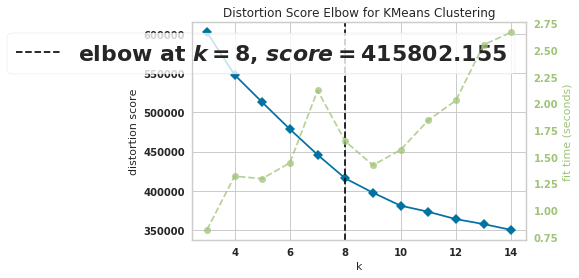

In [48]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-1870"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-1870"
 
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

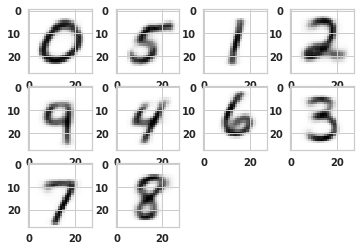

In [49]:
num_clusters = 10
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
tf.reset_default_graph()
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [50]:
import json
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [0, 5, 1, 2,
                                           9, 4, 6, 3,
                                           7, 8
                                          ]
manual_annotation_json["manual_confidence"] = [1, 0.9, 1, 0.9,
                                               0.9, 0.9, 1, 1,
                                               0.9, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [51]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [52]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

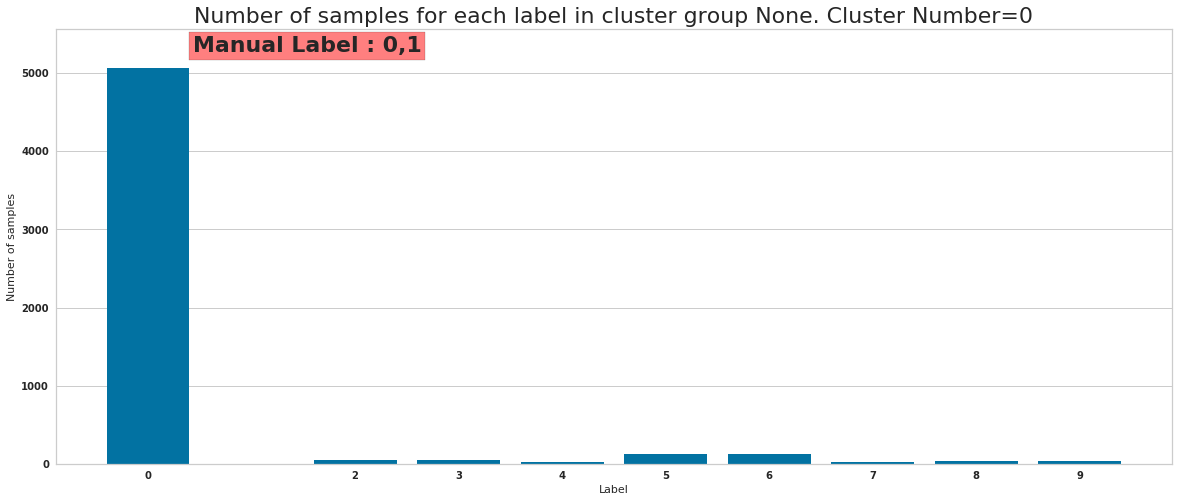

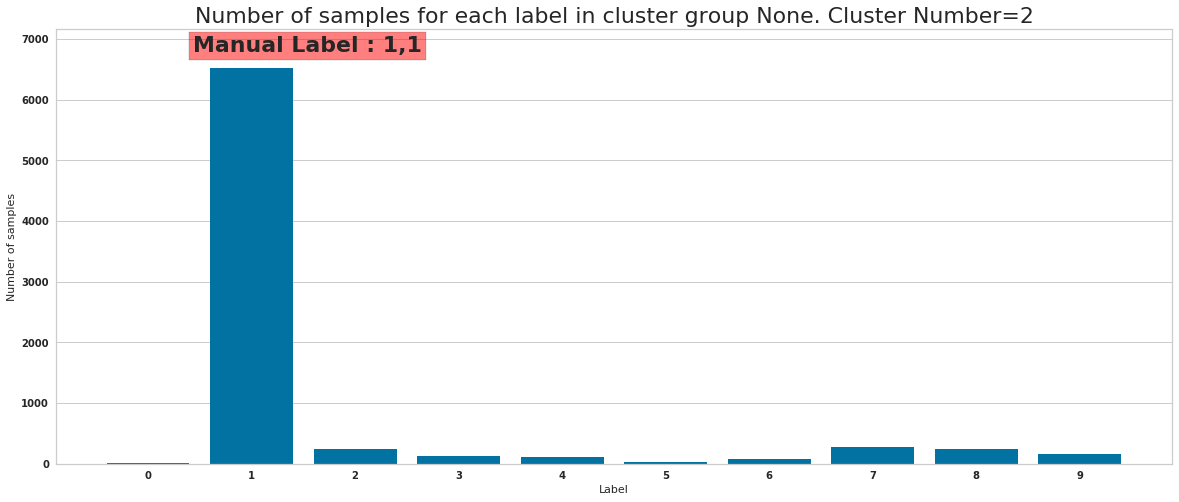

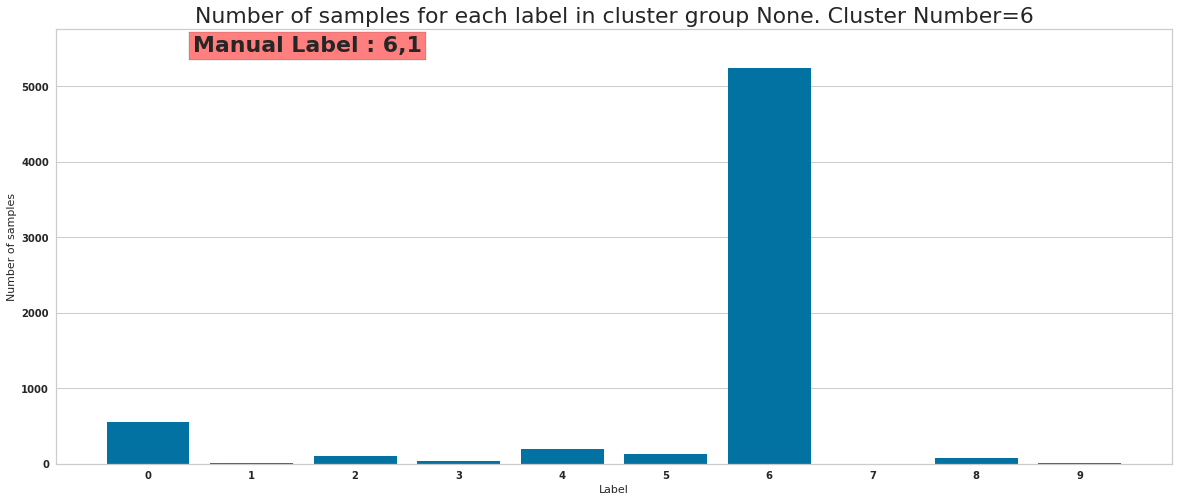

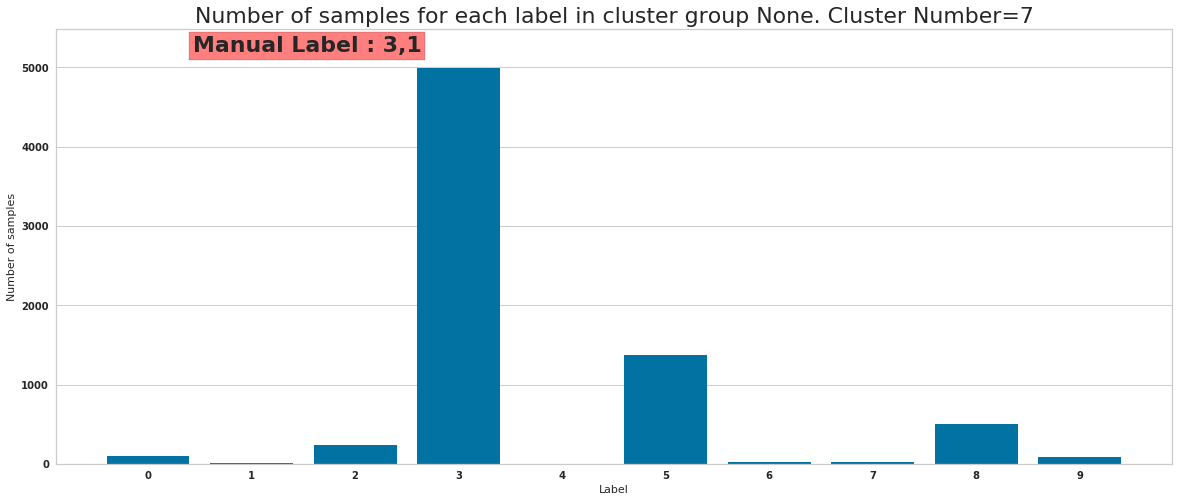

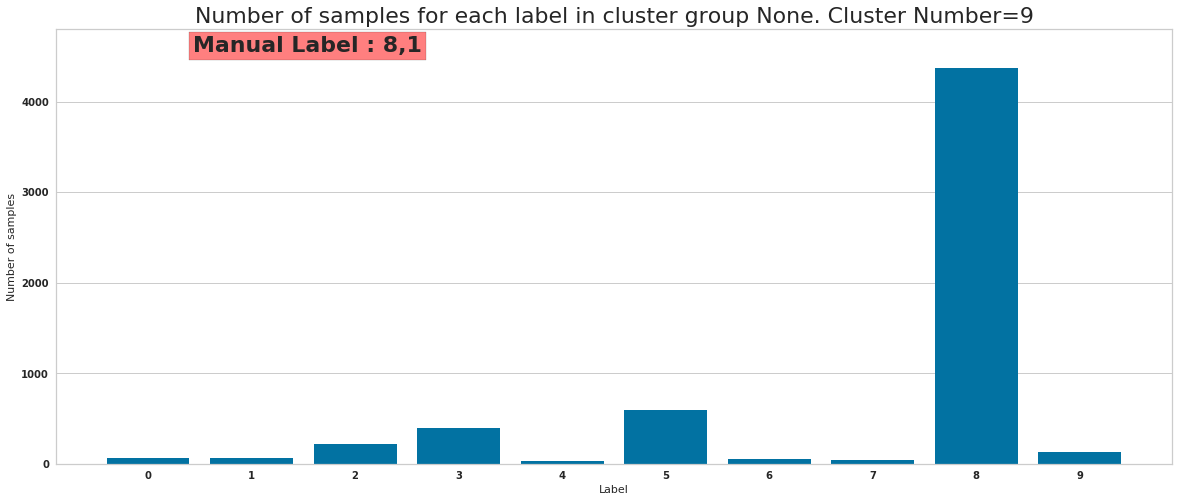

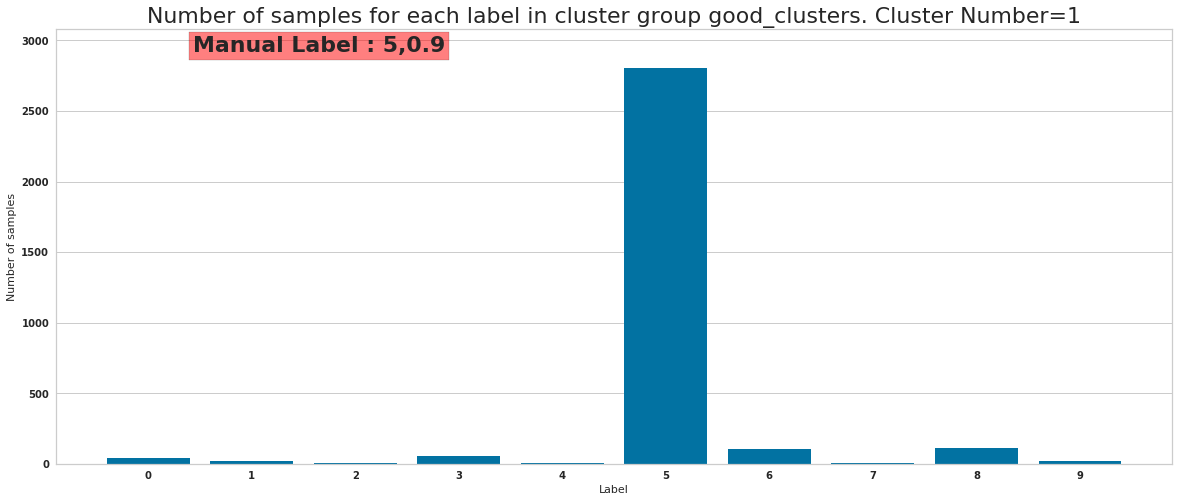

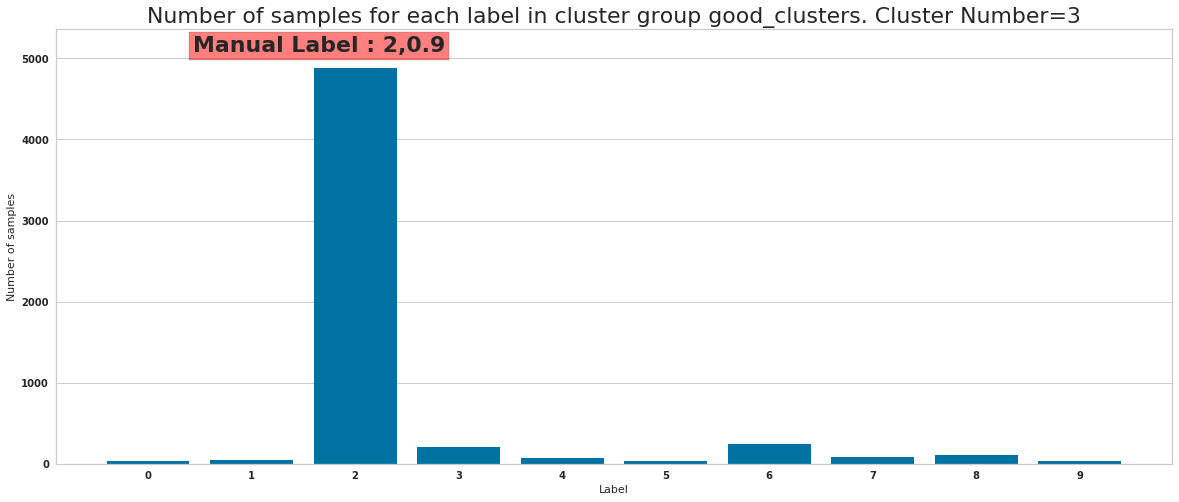

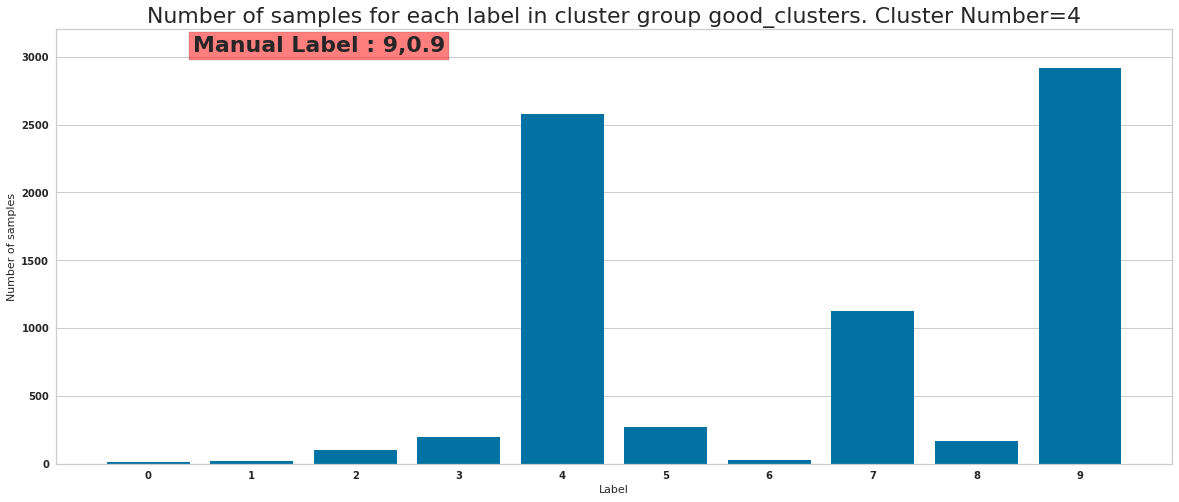

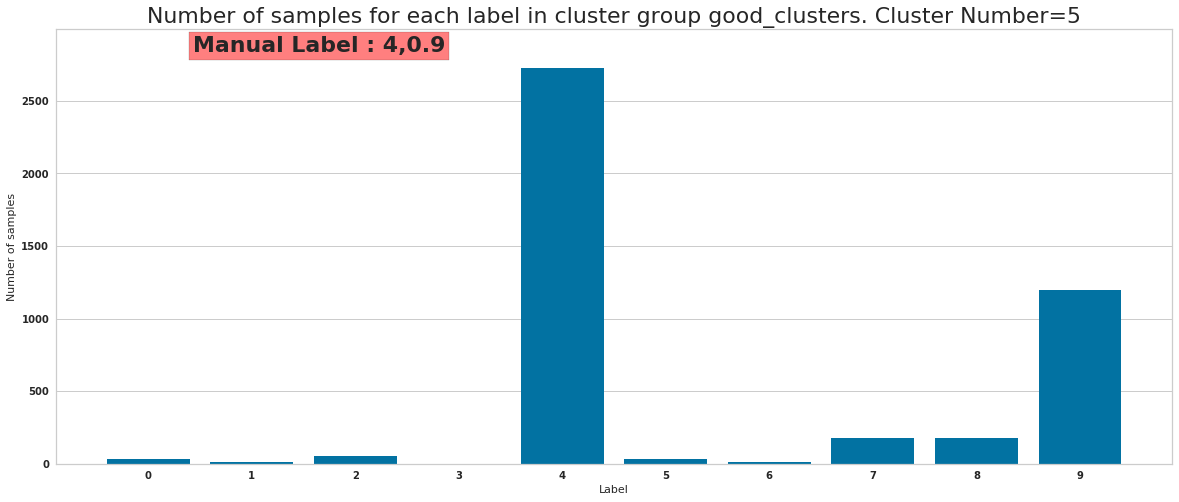

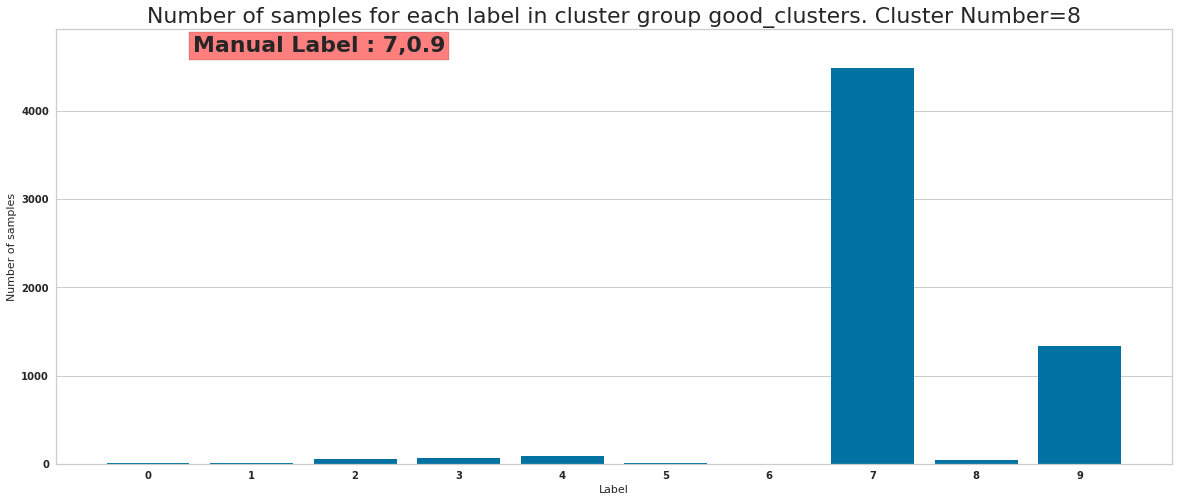

In [53]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [54]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

(5522, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(3164, 10)
(7812, 10)
(5741, 10)
(7417, 10)
(4425, 10)
(6365, 10)
(7338, 10)
(6098, 10)
(5958, 10)


In [55]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [56]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [8, 6, -1, -1,
#                                         -1, 0, -1, 1,
#                                         5, -1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.6, 0.6, 0, 0,
#                                              0, 0.9, 0, 0.9,
#                                              0.7, 0
#                                              ]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,5,-1,-1,
#                                         -1,5,8,-1,
#                                         -1,-1]
# level_2_cluster_dict["manual_confidences"] = [1,0.6,0,0,
#                                              0,0.6,0.6,0,
#                                              0,0]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [57]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)
    
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 0
(5522, 47) (5522, 33)
Num correct=5059
Cluster 0 Manual Label 0 Percentage correct 91.61535675479898
********************************
Manual Label 5
(3164, 47) (3164, 33)
Num correct=2801
Cluster 1 Manual Label 5 Percentage correct 88.52718078381795
********************************
Manual Label 1
(7812, 47) (7812, 33)
Num correct=6515
Cluster 2 Manual Label 1 Percentage correct 83.3973374295955
********************************
Manual Label 2
(5741, 47) (5741, 33)
Num correct=4875
Cluster 3 Manual Label 2 Percentage correct 84.91551994426058
********************************
Manual Label 9
(7417, 47) (7417, 33)
Num correct=2913
Cluster 4 Manual Label 9 Percentage correct 39.27463934205204
********************************
Manual Label 4
(4425, 47) (4425, 33)
Num correct=2722
Cluster 5 Manual Label 4 Percentage correct 61.51412429378531
********************************
Manual Label 6
(6365, 47) (6365, 33)
Num correct=5239
Cluster 6 Manual Label 6 Percentage correct 82.309505

In [58]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5522., 3164., 7812., 5741., 7417., 4425., 6365., 7338., 6098.,
        5958.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

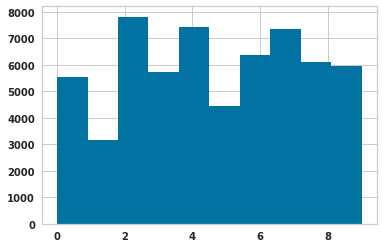

In [59]:
plt.hist(cluster_labels)

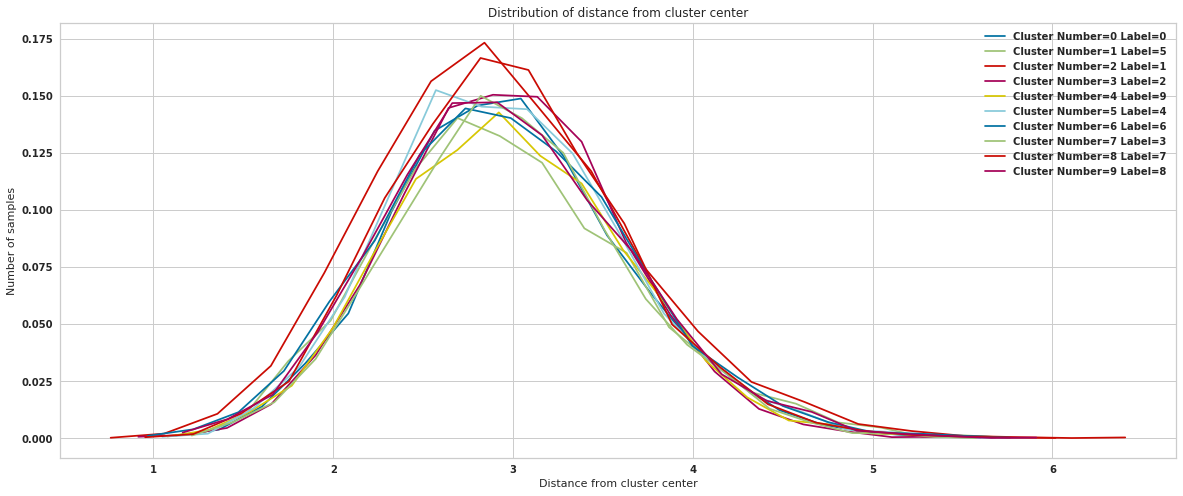

In [60]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

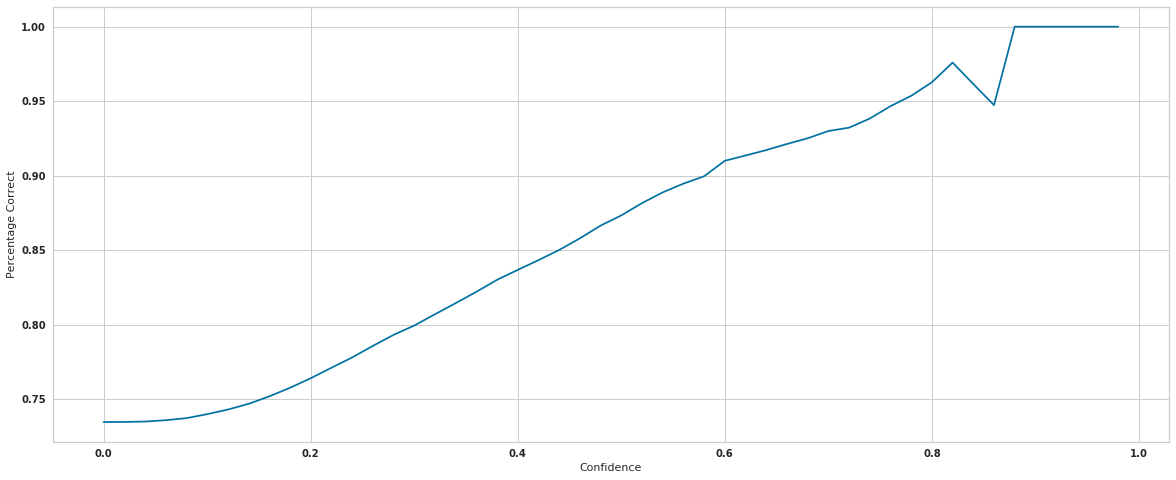

In [61]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

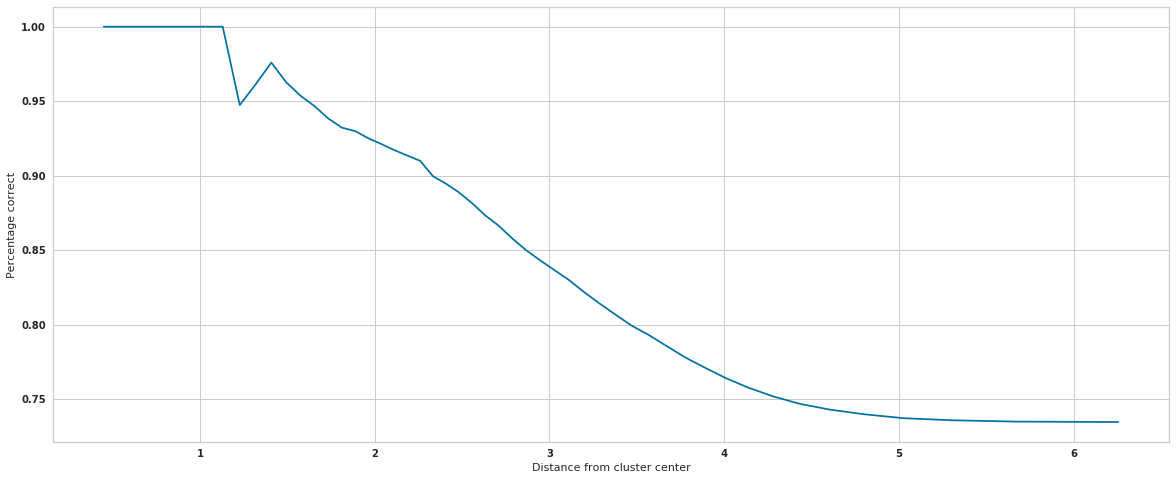

In [62]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [63]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

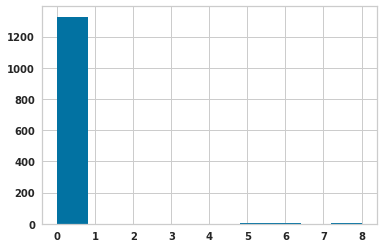

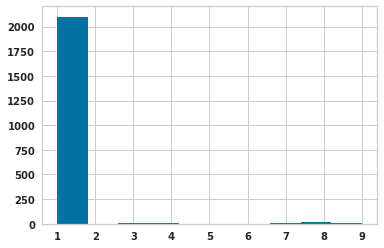

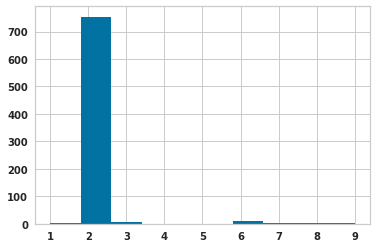

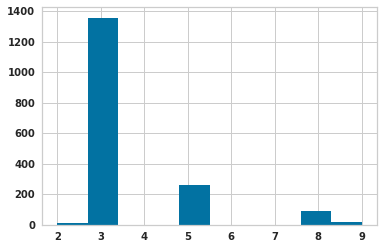

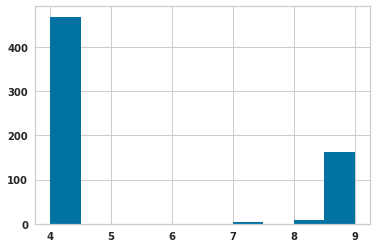

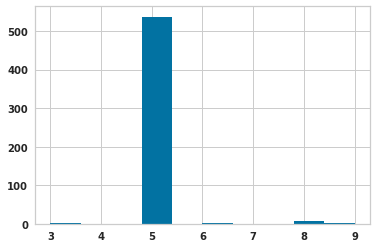

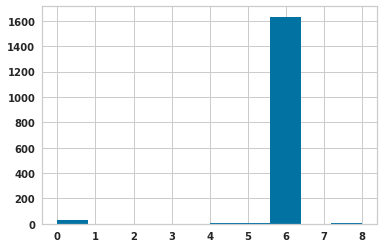

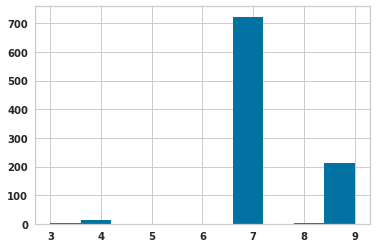

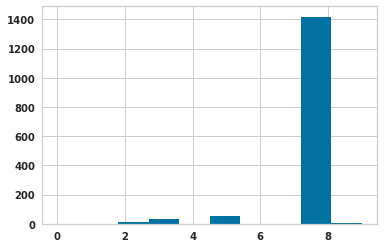

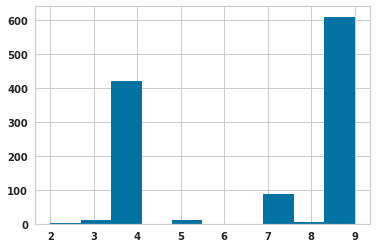

In [64]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [65]:
num_epochs
num_epochs += 1
print(num_epochs)

3


In [66]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_2.0.csv


In [67]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 22824.630078137576
INFO:tensorflow:Summary name Negative Log Like

Epoch: 2/60, Nll_loss : 121.30635070800781 KLD:9.313206672668457  Supervised loss:0.18713825941085815
Epoch: 2/61, Nll_loss : 120.43228149414062 KLD:9.457267761230469  Supervised loss:0.15810494124889374
Epoch: 2/62, Nll_loss : 133.65573120117188 KLD:9.789972305297852  Supervised loss:0.15886372327804565
Epoch: 2/63, Nll_loss : 119.60604095458984 KLD:9.782645225524902  Supervised loss:0.18795254826545715
Epoch: 2/64, Nll_loss : 122.45567321777344 KLD:9.613959312438965  Supervised loss:0.1288662850856781
Epoch: 2/65, Nll_loss : 125.61802673339844 KLD:10.317864418029785  Supervised loss:0.1805770844221115
Epoch: 2/66, Nll_loss : 111.81268310546875 KLD:9.894100189208984  Supervised loss:0.1372547149658203
Epoch: 2/67, Nll_loss : 111.46781921386719 KLD:9.268787384033203  Supervised loss:0.13420769572257996
Epoch: 2/68, Nll_loss : 123.14767456054688 KLD:9.651466369628906  Supervised loss:0.13085900247097015
Epoch: 2/69, Nll_loss : 130.76742553710938 KLD:9.490640640258789  Supervised loss:0.

Epoch: 2/141, Nll_loss : 124.32510375976562 KLD:9.471097946166992  Supervised loss:0.13943234086036682
Epoch: 2/142, Nll_loss : 123.10655212402344 KLD:9.72279167175293  Supervised loss:0.15725824236869812
Epoch: 2/143, Nll_loss : 120.21483612060547 KLD:9.45108413696289  Supervised loss:0.14262112975120544
Epoch: 2/144, Nll_loss : 120.73909759521484 KLD:9.354053497314453  Supervised loss:0.11254742741584778
Epoch: 2/145, Nll_loss : 124.32414245605469 KLD:9.145461082458496  Supervised loss:0.19058763980865479
Epoch: 2/146, Nll_loss : 113.93605041503906 KLD:9.753304481506348  Supervised loss:0.10710269212722778
Epoch: 2/147, Nll_loss : 121.15779113769531 KLD:9.890896797180176  Supervised loss:0.1442526876926422
Epoch: 2/148, Nll_loss : 128.52027893066406 KLD:9.742789268493652  Supervised loss:0.1590331494808197
Epoch: 2/149, Nll_loss : 119.7445068359375 KLD:9.5512113571167  Supervised loss:0.19508035480976105
Epoch: 2/150, Nll_loss : 124.98954772949219 KLD:10.038578987121582  Supervised l

Epoch: 2/223, Nll_loss : 122.86589813232422 KLD:9.698554992675781  Supervised loss:0.17390885949134827
Epoch: 2/224, Nll_loss : 126.27935791015625 KLD:10.22801399230957  Supervised loss:0.11626579612493515
Epoch: 2/225, Nll_loss : 126.87149047851562 KLD:9.354789733886719  Supervised loss:0.18224789202213287
Epoch: 2/226, Nll_loss : 119.74166107177734 KLD:9.68731689453125  Supervised loss:0.13673126697540283
Epoch: 2/227, Nll_loss : 123.49154663085938 KLD:9.246162414550781  Supervised loss:0.19370834529399872
Epoch: 2/228, Nll_loss : 122.29228210449219 KLD:9.645051956176758  Supervised loss:0.1563674956560135
Epoch: 2/229, Nll_loss : 121.5221176147461 KLD:9.913436889648438  Supervised loss:0.1406211405992508
Epoch: 2/230, Nll_loss : 123.75428771972656 KLD:9.656139373779297  Supervised loss:0.13706177473068237
Epoch: 2/231, Nll_loss : 125.8734130859375 KLD:9.68663215637207  Supervised loss:0.18971796333789825
Epoch: 2/232, Nll_loss : 116.87498474121094 KLD:9.809684753417969  Supervised l

Epoch: 2/304, Nll_loss : 121.79194641113281 KLD:9.49069595336914  Supervised loss:0.17908325791358948
Epoch: 2/305, Nll_loss : 116.72279357910156 KLD:9.42628002166748  Supervised loss:0.14492125809192657
Epoch: 2/306, Nll_loss : 122.22698974609375 KLD:9.540133476257324  Supervised loss:0.1864924132823944
Epoch: 2/307, Nll_loss : 117.52134704589844 KLD:9.466117858886719  Supervised loss:0.10692451149225235
Epoch: 2/308, Nll_loss : 132.1760711669922 KLD:9.662504196166992  Supervised loss:0.1353641003370285
Epoch: 2/309, Nll_loss : 117.31282043457031 KLD:9.46091079711914  Supervised loss:0.1328730583190918
Epoch: 2/310, Nll_loss : 131.4462127685547 KLD:9.450502395629883  Supervised loss:0.16860738396644592
Epoch: 2/311, Nll_loss : 129.85304260253906 KLD:9.457362174987793  Supervised loss:0.14215293526649475
Epoch: 2/312, Nll_loss : 127.68528747558594 KLD:9.674568176269531  Supervised loss:0.13641077280044556
Epoch: 2/313, Nll_loss : 123.78688049316406 KLD:9.631536483764648  Supervised los

Epoch: 2/384, Nll_loss : 130.6502685546875 KLD:9.539286613464355  Supervised loss:0.1614220142364502
Epoch: 2/385, Nll_loss : 124.58988952636719 KLD:9.413654327392578  Supervised loss:0.15312106907367706
Epoch: 2/386, Nll_loss : 123.73243713378906 KLD:9.58555793762207  Supervised loss:0.14360231161117554
Epoch: 2/387, Nll_loss : 118.85572814941406 KLD:9.432907104492188  Supervised loss:0.16310909390449524
Epoch: 2/388, Nll_loss : 123.87220001220703 KLD:9.61220932006836  Supervised loss:0.14997433125972748
Epoch: 2/389, Nll_loss : 121.84597778320312 KLD:9.621150970458984  Supervised loss:0.11428375542163849
Epoch: 2/390, Nll_loss : 122.01087951660156 KLD:10.26972770690918  Supervised loss:0.1122971698641777
Epoch: 2/391, Nll_loss : 112.58985137939453 KLD:9.781648635864258  Supervised loss:0.17590297758579254
Epoch: 2/392, Nll_loss : 118.59944915771484 KLD:9.974777221679688  Supervised loss:0.11639825254678726
Epoch: 2/393, Nll_loss : 125.1272201538086 KLD:9.939668655395508  Supervised l

Epoch: 2/465, Nll_loss : 127.62501525878906 KLD:9.058725357055664  Supervised loss:0.11204897612333298
Epoch: 2/466, Nll_loss : 115.3258056640625 KLD:9.114215850830078  Supervised loss:0.13764536380767822
Epoch: 2/467, Nll_loss : 113.39521026611328 KLD:9.414377212524414  Supervised loss:0.18504536151885986
Epoch: 2/468, Nll_loss : 122.44486999511719 KLD:9.382116317749023  Supervised loss:0.15808865427970886
Epoch: 2/469, Nll_loss : 116.65821838378906 KLD:9.107561111450195  Supervised loss:0.14082276821136475
Epoch: 2/470, Nll_loss : 119.97663879394531 KLD:9.527307510375977  Supervised loss:0.10070071369409561
Epoch: 2/471, Nll_loss : 118.36184692382812 KLD:9.480396270751953  Supervised loss:0.11531263589859009
Epoch: 2/472, Nll_loss : 123.98198699951172 KLD:9.496637344360352  Supervised loss:0.13566255569458008
Epoch: 2/473, Nll_loss : 115.68824768066406 KLD:9.853568077087402  Supervised loss:0.1690210998058319
Epoch: 2/474, Nll_loss : 117.23249816894531 KLD:9.791789054870605  Supervis

Epoch: 2/547, Nll_loss : 124.64749145507812 KLD:9.56460189819336  Supervised loss:0.12614963948726654
Epoch: 2/548, Nll_loss : 112.89189147949219 KLD:9.548810005187988  Supervised loss:0.15454018115997314
Epoch: 2/549, Nll_loss : 118.33908081054688 KLD:9.36500358581543  Supervised loss:0.1489042341709137
Epoch: 2/550, Nll_loss : 118.79055786132812 KLD:9.6778564453125  Supervised loss:0.13696886599063873
Epoch: 2/551, Nll_loss : 120.38489532470703 KLD:9.34528636932373  Supervised loss:0.16768935322761536
Epoch: 2/552, Nll_loss : 114.30241394042969 KLD:8.994576454162598  Supervised loss:0.13416454195976257
Epoch: 2/553, Nll_loss : 126.79792785644531 KLD:9.053750991821289  Supervised loss:0.15172073245048523
Epoch: 2/554, Nll_loss : 123.2249755859375 KLD:8.768857955932617  Supervised loss:0.12896861135959625
Epoch: 2/555, Nll_loss : 121.66966247558594 KLD:9.277412414550781  Supervised loss:0.13253235816955566
Epoch: 2/556, Nll_loss : 127.54573059082031 KLD:9.137214660644531  Supervised lo

Epoch: 2/628, Nll_loss : 116.290771484375 KLD:9.044425964355469  Supervised loss:0.1463882327079773
Epoch: 2/629, Nll_loss : 122.8969955444336 KLD:8.540172576904297  Supervised loss:0.22956764698028564
Epoch: 2/630, Nll_loss : 126.41380310058594 KLD:8.724900245666504  Supervised loss:0.1344892680644989
Epoch: 2/631, Nll_loss : 116.59623718261719 KLD:8.849227905273438  Supervised loss:0.1564139425754547
Epoch: 2/632, Nll_loss : 117.16075134277344 KLD:9.148889541625977  Supervised loss:0.13137435913085938
Epoch: 2/633, Nll_loss : 118.07109069824219 KLD:9.41689682006836  Supervised loss:0.16723954677581787
Epoch: 2/634, Nll_loss : 117.3673095703125 KLD:9.714349746704102  Supervised loss:0.17070981860160828
Epoch: 2/635, Nll_loss : 119.7197036743164 KLD:10.23287582397461  Supervised loss:0.16286198794841766
Epoch: 2/636, Nll_loss : 113.92494201660156 KLD:10.672916412353516  Supervised loss:0.143835186958313
Epoch: 2/637, Nll_loss : 109.2757339477539 KLD:10.185423851013184  Supervised loss:

Epoch: 2/711, Nll_loss : 121.25171661376953 KLD:9.2598295211792  Supervised loss:0.1108345314860344
Epoch: 2/712, Nll_loss : 123.26513671875 KLD:9.431755065917969  Supervised loss:0.15493270754814148
Epoch: 2/713, Nll_loss : 122.25425720214844 KLD:9.146918296813965  Supervised loss:0.2135302573442459
Epoch: 2/714, Nll_loss : 116.03617858886719 KLD:9.896337509155273  Supervised loss:0.1334277093410492
Epoch: 2/715, Nll_loss : 114.4891357421875 KLD:9.53382682800293  Supervised loss:0.11018282920122147
Epoch: 2/716, Nll_loss : 114.18062591552734 KLD:9.572484970092773  Supervised loss:0.14394783973693848
Epoch: 2/717, Nll_loss : 121.95285034179688 KLD:10.14773178100586  Supervised loss:0.09268432855606079
Epoch: 2/718, Nll_loss : 112.855224609375 KLD:9.419095993041992  Supervised loss:0.1556818187236786
Epoch: 2/719, Nll_loss : 120.84112548828125 KLD:9.331928253173828  Supervised loss:0.16442763805389404
Epoch: 2/720, Nll_loss : 116.26612854003906 KLD:9.486429214477539  Supervised loss:0.1

Epoch: 2/791, Nll_loss : 114.87815856933594 KLD:9.60116958618164  Supervised loss:0.18517811596393585
Epoch: 2/792, Nll_loss : 120.53004455566406 KLD:9.9342041015625  Supervised loss:0.16735656559467316
Epoch: 2/793, Nll_loss : 110.192626953125 KLD:9.779025077819824  Supervised loss:0.12860968708992004
Epoch: 2/794, Nll_loss : 120.020751953125 KLD:10.439441680908203  Supervised loss:0.09608239680528641
Epoch: 2/795, Nll_loss : 117.43931579589844 KLD:10.154747009277344  Supervised loss:0.16320937871932983
Epoch: 2/796, Nll_loss : 124.07986450195312 KLD:10.174985885620117  Supervised loss:0.08156062662601471
Epoch: 2/797, Nll_loss : 118.60316467285156 KLD:9.640724182128906  Supervised loss:0.10351221263408661
Epoch: 2/798, Nll_loss : 124.5377197265625 KLD:8.801487922668457  Supervised loss:0.18569689989089966
Epoch: 2/799, Nll_loss : 126.4127197265625 KLD:9.37785530090332  Supervised loss:0.16411545872688293
Epoch: 2/800, Nll_loss : 123.48100280761719 KLD:9.060547828674316  Supervised lo

Epoch: 2/872, Nll_loss : 113.48530578613281 KLD:9.049983024597168  Supervised loss:0.08915185928344727
Epoch: 2/873, Nll_loss : 121.18731689453125 KLD:9.134385108947754  Supervised loss:0.14510974287986755
Epoch: 2/874, Nll_loss : 117.25072479248047 KLD:9.36564826965332  Supervised loss:0.14614665508270264
Epoch: 2/875, Nll_loss : 120.44947814941406 KLD:9.370798110961914  Supervised loss:0.17281557619571686
Epoch: 2/876, Nll_loss : 113.00625610351562 KLD:9.31480598449707  Supervised loss:0.09245659410953522
Epoch: 2/877, Nll_loss : 122.97057342529297 KLD:9.752365112304688  Supervised loss:0.13499578833580017
Epoch: 2/878, Nll_loss : 124.95121765136719 KLD:9.85639762878418  Supervised loss:0.13877588510513306
Epoch: 2/879, Nll_loss : 110.95234680175781 KLD:9.814897537231445  Supervised loss:0.13754022121429443
Epoch: 2/880, Nll_loss : 113.29793548583984 KLD:9.281965255737305  Supervised loss:0.10339376330375671
Epoch: 2/881, Nll_loss : 121.32589721679688 KLD:9.8577299118042  Supervised 

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-2805"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-2805"
 
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

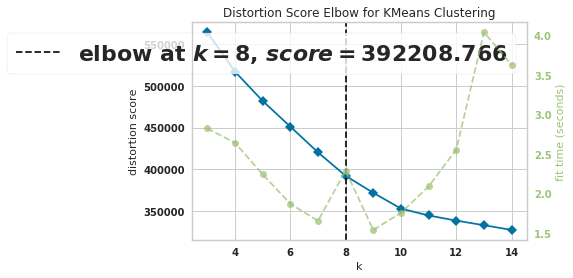

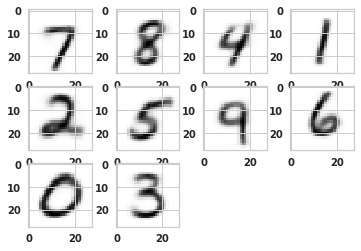

In [68]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [69]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7, 8, 4, 1,
                                           2, 5, 9, 6,
                                           0, 3
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 0.8, 1,
                                               1, 1, 0.8, 1,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


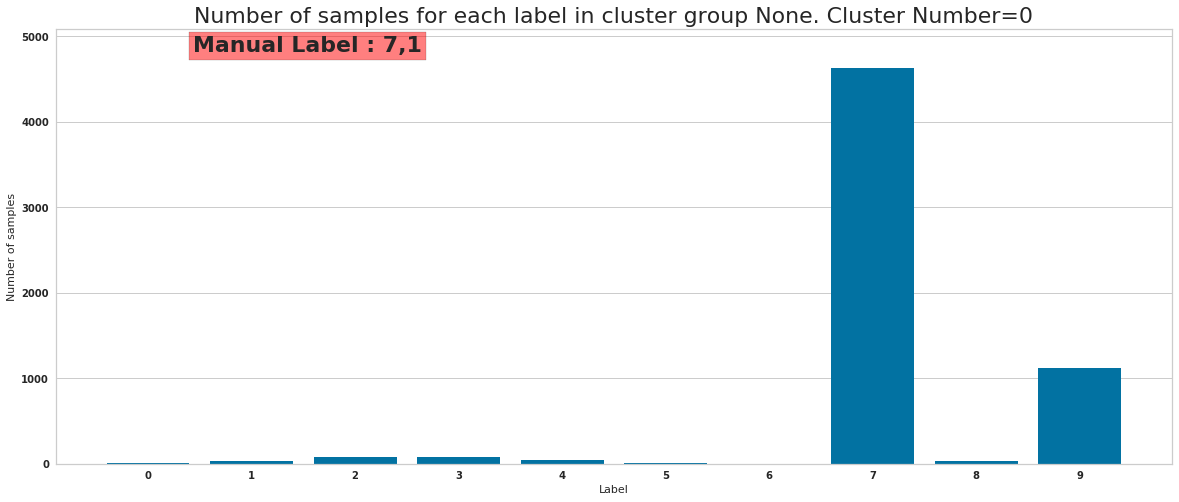

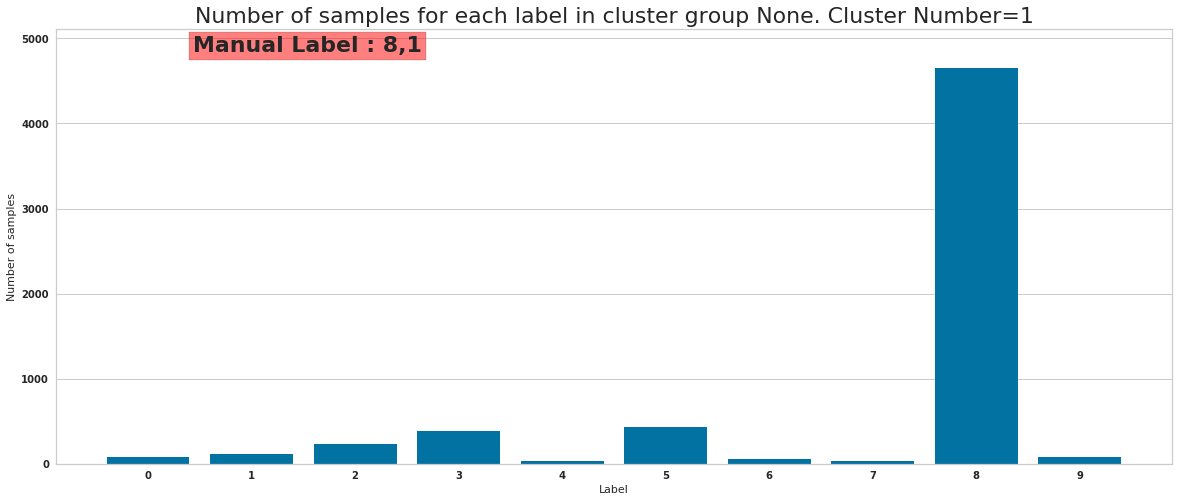

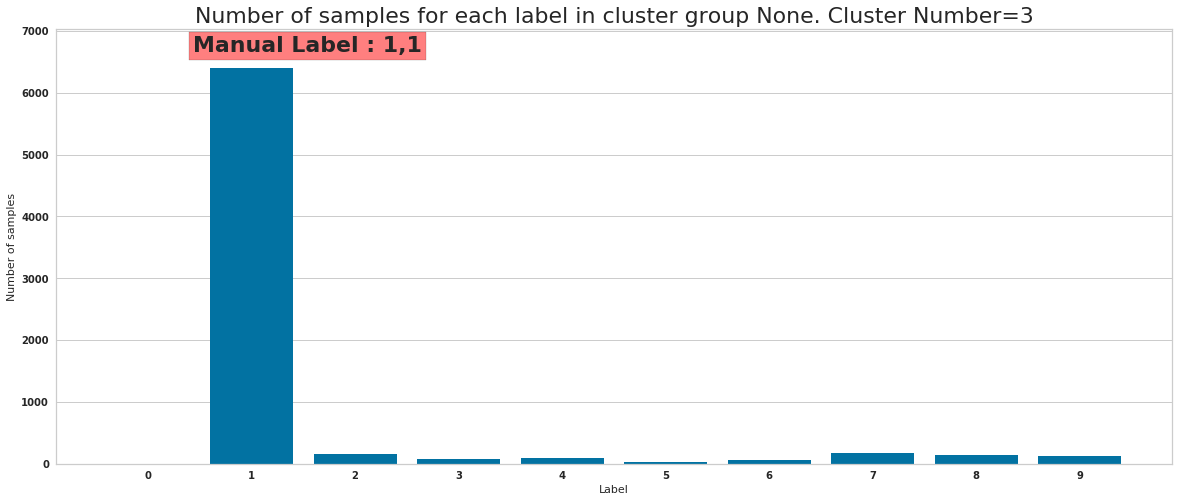

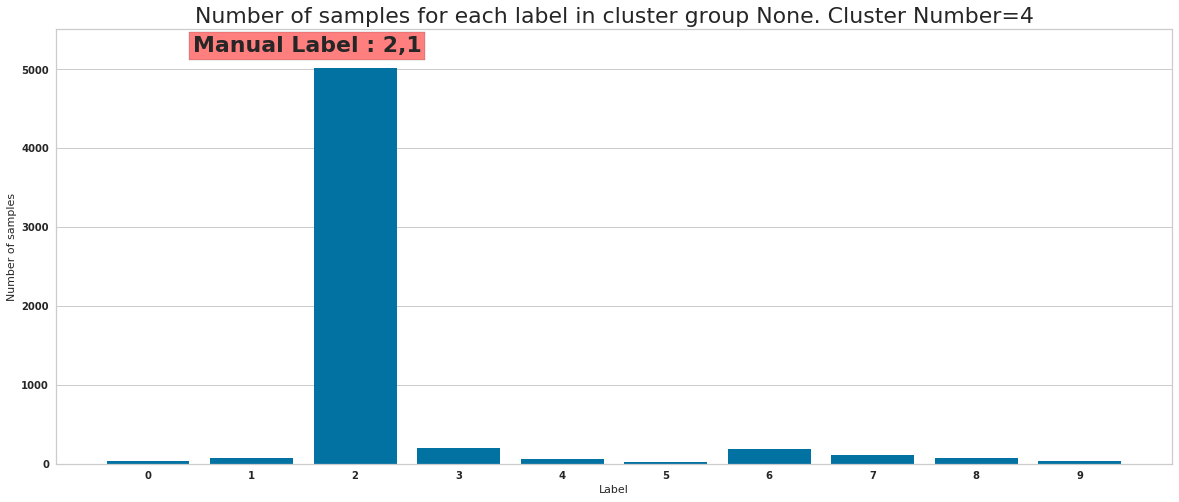

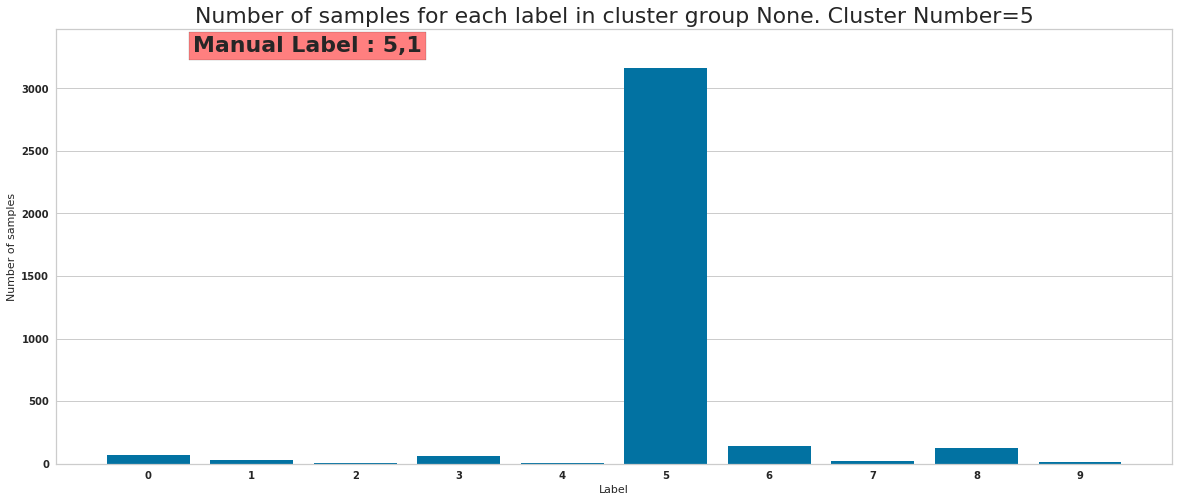

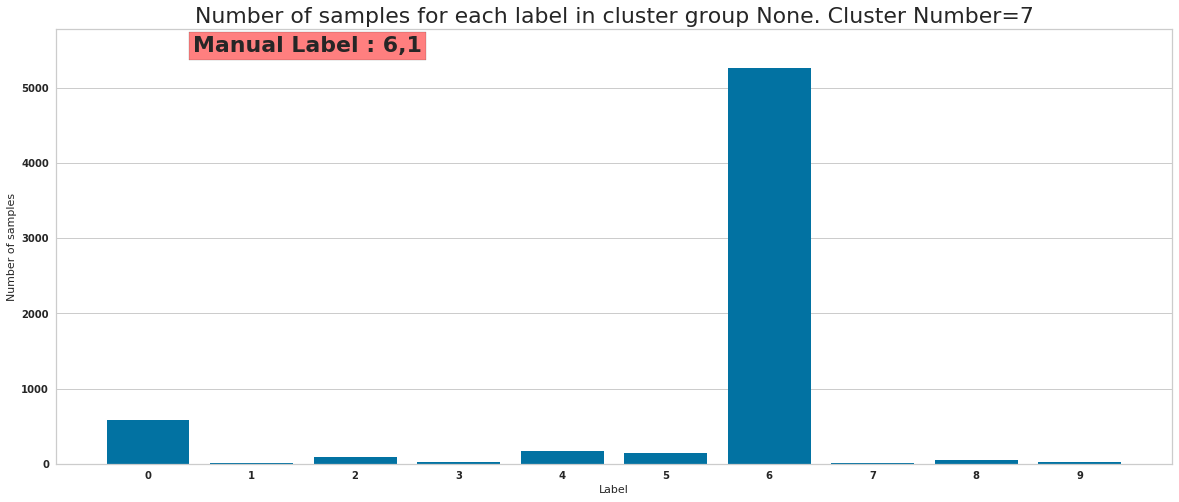

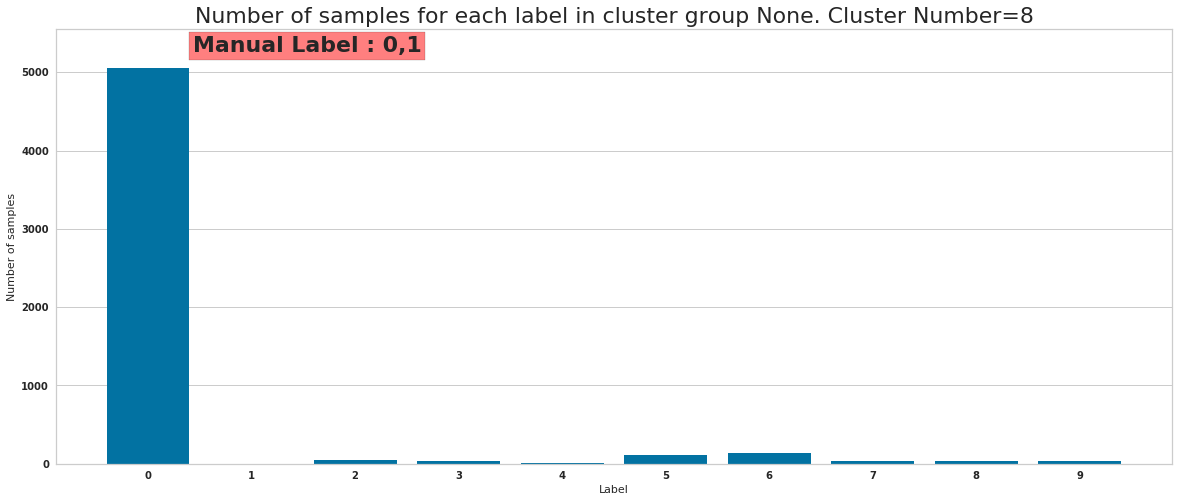

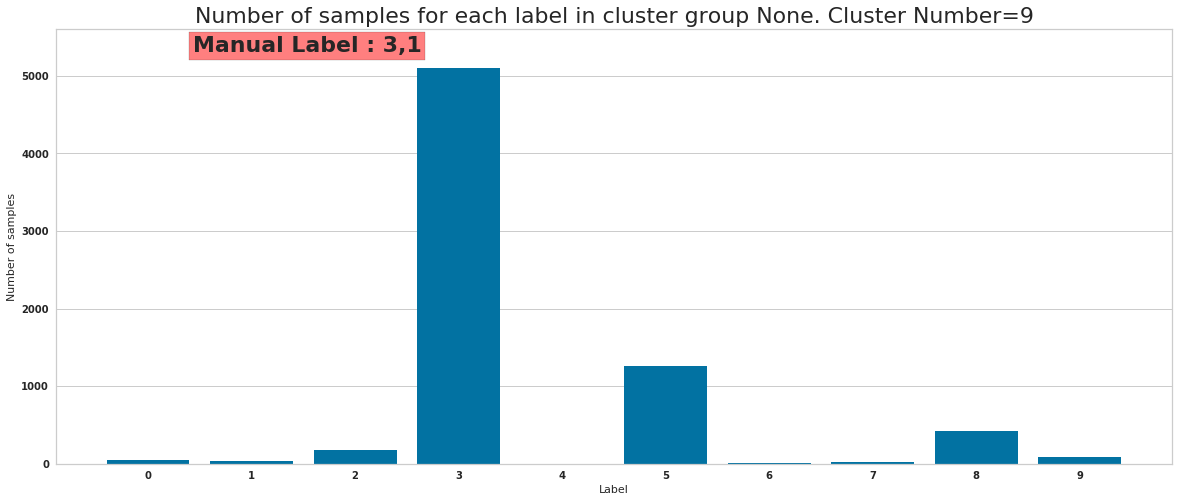

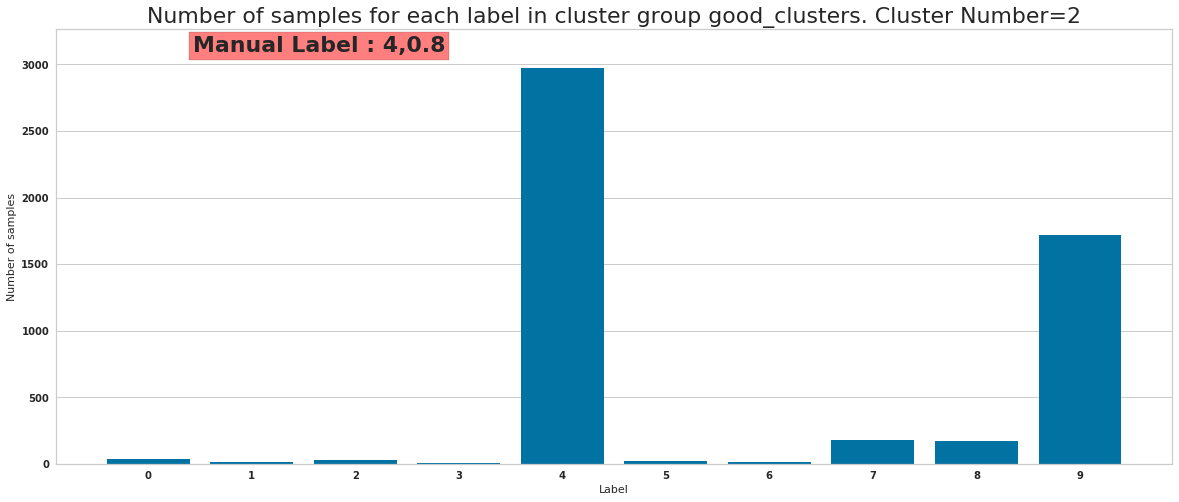

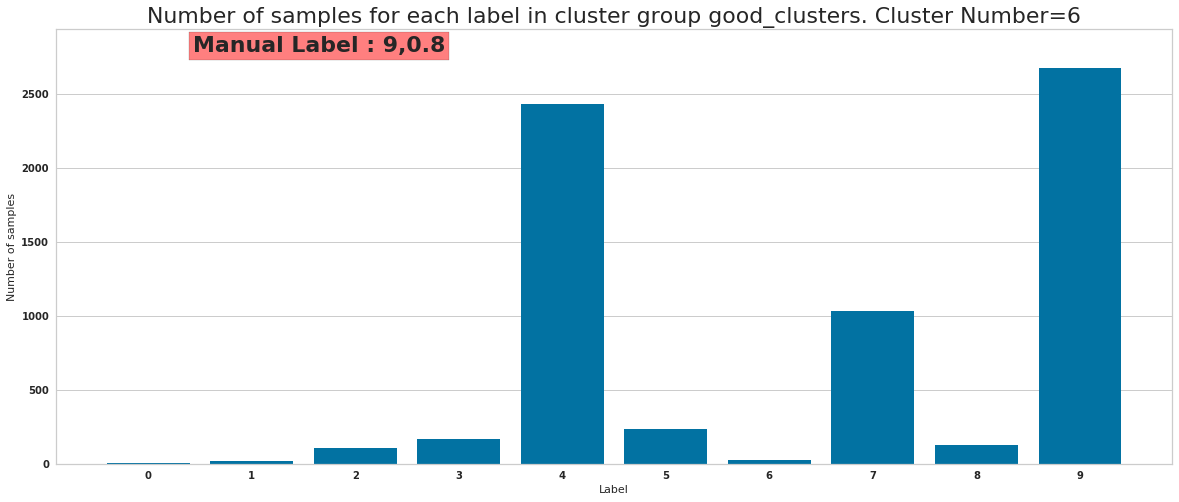

In [70]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [71]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(6031, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(6092, 10)
(5157, 10)
(7263, 10)
(5826, 10)
(3639, 10)
(6819, 10)
(6357, 10)
(5507, 10)
(7149, 10)


In [72]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,-1,-1,7,
#                                          4,4,9,-1,
#                                          -1,9
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0,0,0.6,
#                                              0.8,0.8,0.9,0,
#                                              0,0.9]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [73]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 7
(6031, 47) (6031, 33)
Num correct=4625
Cluster 0 Manual Label 7 Percentage correct 76.68711656441718
********************************
Manual Label 8
(6092, 47) (6092, 33)
Num correct=4647
Cluster 1 Manual Label 8 Percentage correct 76.28036769533814
********************************
Manual Label 4
(5157, 47) (5157, 33)
Num correct=2970
Cluster 2 Manual Label 4 Percentage correct 57.59162303664922
********************************
Manual Label 1
(7263, 47) (7263, 33)
Num correct=6392
Cluster 3 Manual Label 1 Percentage correct 88.00771031254303
********************************
Manual Label 2
(5826, 47) (5826, 33)
Num correct=5010
Cluster 4 Manual Label 2 Percentage correct 85.99382080329558
********************************
Manual Label 5
(3639, 47) (3639, 33)
Num correct=3158
Cluster 5 Manual Label 5 Percentage correct 86.78208298983238
********************************
Manual Label 9
(6819, 47) (6819, 33)
Num correct=2670
Cluster 6 Manual Label 9 Percentage correct 39.15530

In [74]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [75]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

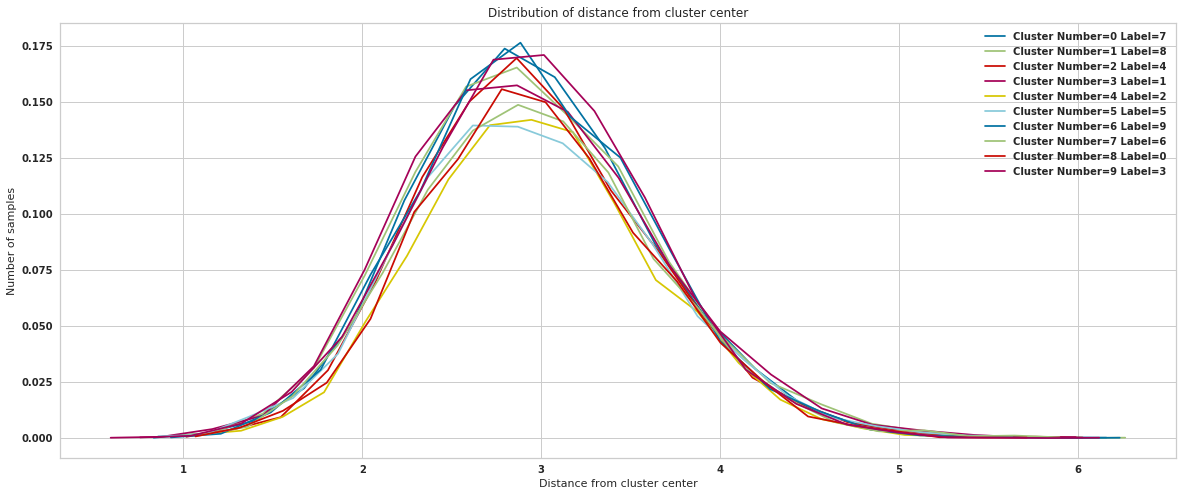

In [76]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

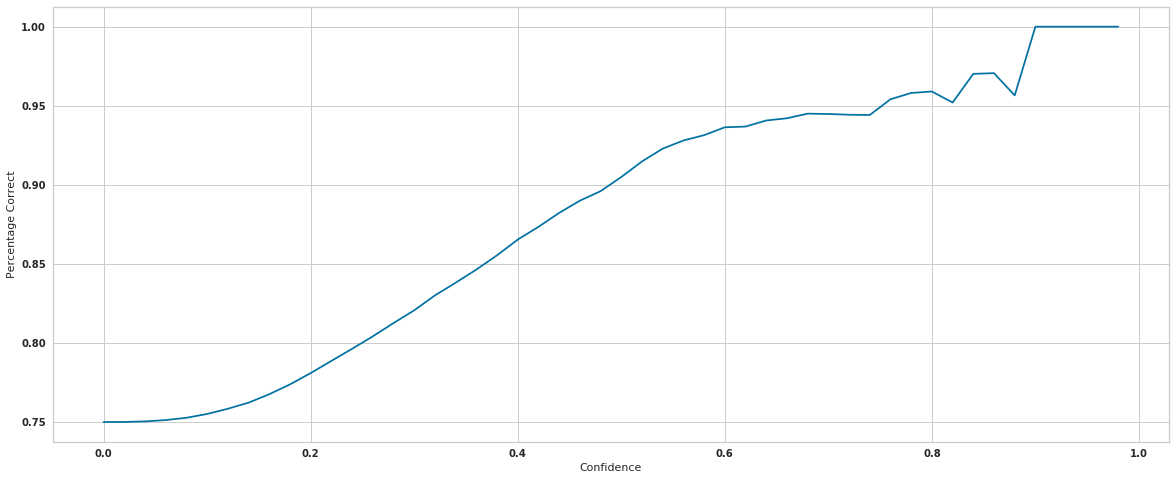

In [77]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

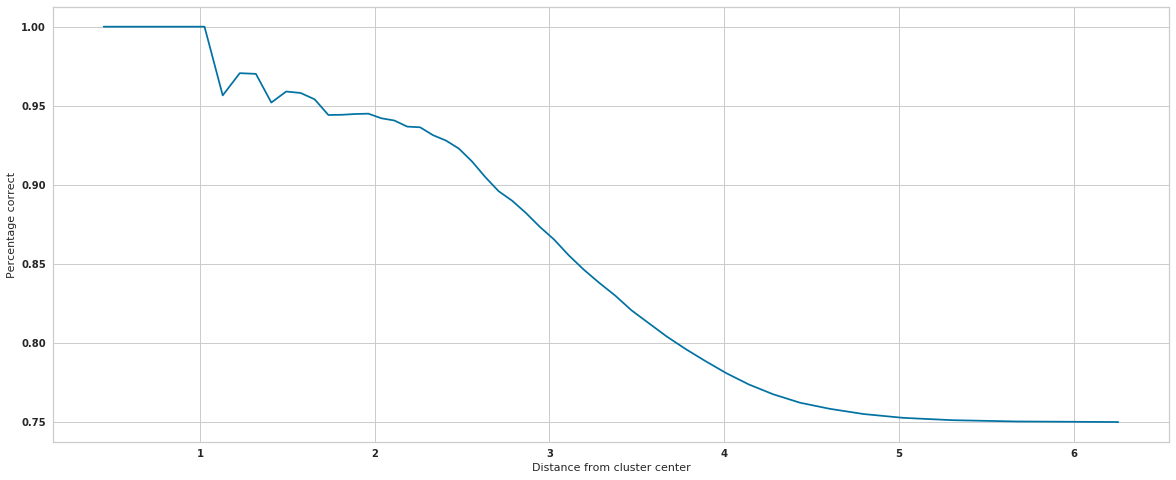

In [78]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

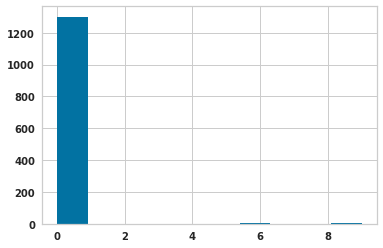

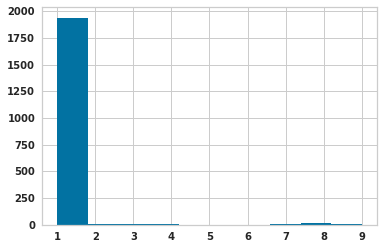

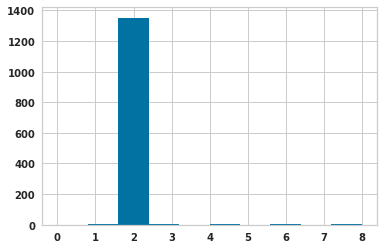

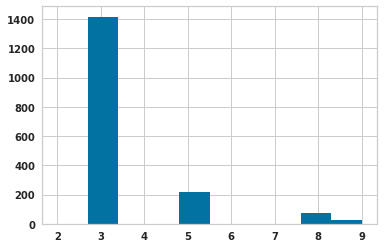

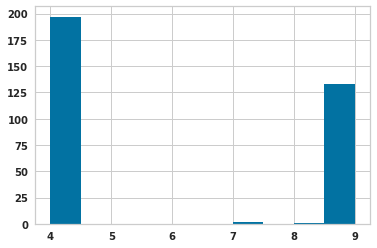

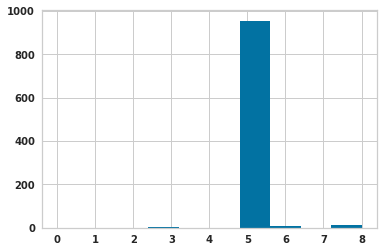

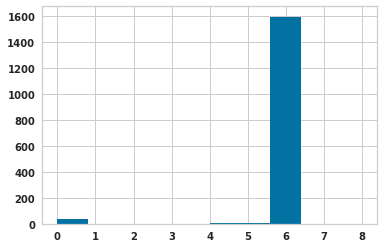

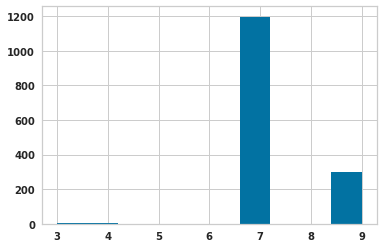

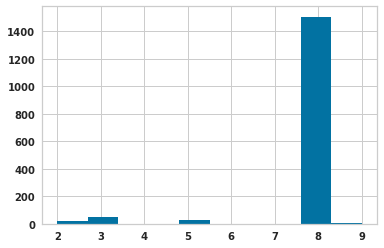

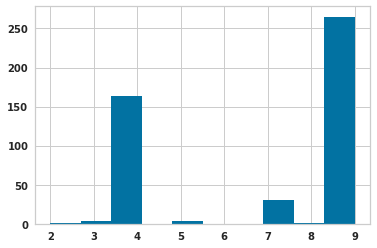

In [79]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 4

In [80]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 22925.87822849719
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 3/61, Nll_loss : 117.17681884765625 KLD:9.763785362243652  Supervised loss:0.12550005316734314
Epoch: 3/62, Nll_loss : 127.93971252441406 KLD:10.310578346252441  Supervised loss:0.10940564423799515
Epoch: 3/63, Nll_loss : 117.96676635742188 KLD:10.005069732666016  Supervised loss:0.14923615753650665
Epoch: 3/64, Nll_loss : 119.12142944335938 KLD:9.44152545928955  Supervised loss:0.14584864675998688
Epoch: 3/65, Nll_loss : 122.18089294433594 KLD:9.905122756958008  Supervised loss:0.11689554154872894
Epoch: 3/66, Nll_loss : 108.13368225097656 KLD:9.334554672241211  Supervised loss:0.10498318076133728
Epoch: 3/67, Nll_loss : 109.26907348632812 KLD:9.00544548034668  Supervised loss:0.11655373126268387
Epoch: 3/68, Nll_loss : 121.6733169555664 KLD:9.332842826843262  Supervised loss:0.08930602669715881
Epoch: 3/69, Nll_loss : 123.0806884765625 KLD:9.448984146118164  Supervised loss:0.15631598234176636
Epoch: 3/70, Nll_loss : 118.45138549804688 KLD:9.287775993347168  Supervised loss:0.

Epoch: 3/143, Nll_loss : 117.20713806152344 KLD:9.661216735839844  Supervised loss:0.10746732354164124
Epoch: 3/144, Nll_loss : 115.35685729980469 KLD:9.846124649047852  Supervised loss:0.07968698441982269
Epoch: 3/145, Nll_loss : 117.17729949951172 KLD:9.414945602416992  Supervised loss:0.13360154628753662
Epoch: 3/146, Nll_loss : 113.88298034667969 KLD:9.921087265014648  Supervised loss:0.08900424093008041
Epoch: 3/147, Nll_loss : 121.90921020507812 KLD:9.80052375793457  Supervised loss:0.13754621148109436
Epoch: 3/148, Nll_loss : 124.33214569091797 KLD:9.493522644042969  Supervised loss:0.16103199124336243
Epoch: 3/149, Nll_loss : 117.69969177246094 KLD:9.142938613891602  Supervised loss:0.14745856821537018
Epoch: 3/150, Nll_loss : 124.43993377685547 KLD:9.653664588928223  Supervised loss:0.11985510587692261
Epoch: 3/151, Nll_loss : 118.34300994873047 KLD:9.094804763793945  Supervised loss:0.09693406522274017
Epoch: 3/152, Nll_loss : 118.5902099609375 KLD:8.942983627319336  Supervis

Epoch: 3/223, Nll_loss : 118.42634582519531 KLD:9.792525291442871  Supervised loss:0.10999222099781036
Epoch: 3/224, Nll_loss : 122.83209228515625 KLD:10.368429183959961  Supervised loss:0.0801066905260086
Epoch: 3/225, Nll_loss : 122.22161865234375 KLD:9.915727615356445  Supervised loss:0.1323530375957489
Epoch: 3/226, Nll_loss : 118.98204040527344 KLD:9.902854919433594  Supervised loss:0.12903714179992676
Epoch: 3/227, Nll_loss : 120.09916687011719 KLD:9.304259300231934  Supervised loss:0.14193865656852722
Epoch: 3/228, Nll_loss : 124.39910125732422 KLD:9.394233703613281  Supervised loss:0.13578614592552185
Epoch: 3/229, Nll_loss : 118.59842681884766 KLD:9.60513687133789  Supervised loss:0.14101642370224
Epoch: 3/230, Nll_loss : 125.13259887695312 KLD:9.294816970825195  Supervised loss:0.13269853591918945
Epoch: 3/231, Nll_loss : 124.96876525878906 KLD:9.504470825195312  Supervised loss:0.1388433277606964
Epoch: 3/232, Nll_loss : 115.08921813964844 KLD:9.623930931091309  Supervised l

Epoch: 3/303, Nll_loss : 116.90487670898438 KLD:9.561823844909668  Supervised loss:0.11945225298404694
Epoch: 3/304, Nll_loss : 119.77093505859375 KLD:9.676366806030273  Supervised loss:0.1732182502746582
Epoch: 3/305, Nll_loss : 113.99305725097656 KLD:9.472014427185059  Supervised loss:0.11473678052425385
Epoch: 3/306, Nll_loss : 122.47285461425781 KLD:9.598649978637695  Supervised loss:0.14993885159492493
Epoch: 3/307, Nll_loss : 117.69298553466797 KLD:9.474126815795898  Supervised loss:0.09843771159648895
Epoch: 3/308, Nll_loss : 127.79541015625 KLD:9.975906372070312  Supervised loss:0.10279220342636108
Epoch: 3/309, Nll_loss : 111.92606353759766 KLD:9.520120620727539  Supervised loss:0.08141113072633743
Epoch: 3/310, Nll_loss : 126.25950622558594 KLD:9.82540512084961  Supervised loss:0.19358792901039124
Epoch: 3/311, Nll_loss : 128.80308532714844 KLD:9.769729614257812  Supervised loss:0.12016616761684418
Epoch: 3/312, Nll_loss : 123.28939056396484 KLD:9.856561660766602  Supervised 

Epoch: 3/383, Nll_loss : 121.77857971191406 KLD:9.353981971740723  Supervised loss:0.07781410217285156
Epoch: 3/384, Nll_loss : 127.8100357055664 KLD:9.719491004943848  Supervised loss:0.15323306620121002
Epoch: 3/385, Nll_loss : 119.47607421875 KLD:9.472522735595703  Supervised loss:0.09775006771087646
Epoch: 3/386, Nll_loss : 121.3025894165039 KLD:9.304512023925781  Supervised loss:0.1247544139623642
Epoch: 3/387, Nll_loss : 117.67889404296875 KLD:9.046749114990234  Supervised loss:0.13853217661380768
Epoch: 3/388, Nll_loss : 123.47428894042969 KLD:9.192831039428711  Supervised loss:0.121104396879673
Epoch: 3/389, Nll_loss : 115.5459213256836 KLD:9.504660606384277  Supervised loss:0.1296762228012085
Epoch: 3/390, Nll_loss : 119.26750946044922 KLD:9.864795684814453  Supervised loss:0.0886305570602417
Epoch: 3/391, Nll_loss : 112.30520629882812 KLD:9.578298568725586  Supervised loss:0.13006025552749634
Epoch: 3/392, Nll_loss : 116.18109130859375 KLD:9.671977996826172  Supervised loss:0

Epoch: 3/466, Nll_loss : 115.39109802246094 KLD:8.960736274719238  Supervised loss:0.15391071140766144
Epoch: 3/467, Nll_loss : 114.3420181274414 KLD:9.133668899536133  Supervised loss:0.15170852839946747
Epoch: 3/468, Nll_loss : 121.8022232055664 KLD:9.339111328125  Supervised loss:0.1445055603981018
Epoch: 3/469, Nll_loss : 114.27987670898438 KLD:9.236215591430664  Supervised loss:0.0901777446269989
Epoch: 3/470, Nll_loss : 114.71015930175781 KLD:9.644308090209961  Supervised loss:0.09651438891887665
Epoch: 3/471, Nll_loss : 116.69200134277344 KLD:9.626947402954102  Supervised loss:0.1327836513519287
Epoch: 3/472, Nll_loss : 120.94336700439453 KLD:9.785096168518066  Supervised loss:0.1092689037322998
Epoch: 3/473, Nll_loss : 115.06355285644531 KLD:9.945981979370117  Supervised loss:0.17709484696388245
Epoch: 3/474, Nll_loss : 114.79849243164062 KLD:9.89675521850586  Supervised loss:0.10423436760902405
Epoch: 3/475, Nll_loss : 118.35408782958984 KLD:9.999859809875488  Supervised loss:

Epoch: 3/546, Nll_loss : 115.5187759399414 KLD:10.166996955871582  Supervised loss:0.10345558077096939
Epoch: 3/547, Nll_loss : 121.17874145507812 KLD:9.71690559387207  Supervised loss:0.12974518537521362
Epoch: 3/548, Nll_loss : 110.80366516113281 KLD:9.472208023071289  Supervised loss:0.09201891720294952
Epoch: 3/549, Nll_loss : 115.38310241699219 KLD:9.227839469909668  Supervised loss:0.1389487385749817
Epoch: 3/550, Nll_loss : 116.8897705078125 KLD:9.318260192871094  Supervised loss:0.1289380043745041
Epoch: 3/551, Nll_loss : 117.08435821533203 KLD:9.260050773620605  Supervised loss:0.11509386450052261
Epoch: 3/552, Nll_loss : 111.84303283691406 KLD:9.124550819396973  Supervised loss:0.13629016280174255
Epoch: 3/553, Nll_loss : 121.86380004882812 KLD:9.311729431152344  Supervised loss:0.11636698246002197
Epoch: 3/554, Nll_loss : 119.19119262695312 KLD:9.19730281829834  Supervised loss:0.1315905898809433
Epoch: 3/555, Nll_loss : 119.3922119140625 KLD:9.691554069519043  Supervised lo

Epoch: 3/627, Nll_loss : 114.96859741210938 KLD:8.932600021362305  Supervised loss:0.16166821122169495
Epoch: 3/628, Nll_loss : 118.36215209960938 KLD:9.43667221069336  Supervised loss:0.18605199456214905
Epoch: 3/629, Nll_loss : 117.55635070800781 KLD:9.466619491577148  Supervised loss:0.147475004196167
Epoch: 3/630, Nll_loss : 120.99742126464844 KLD:9.760284423828125  Supervised loss:0.13029873371124268
Epoch: 3/631, Nll_loss : 112.18246459960938 KLD:9.929389953613281  Supervised loss:0.1583923101425171
Epoch: 3/632, Nll_loss : 115.67039489746094 KLD:10.083658218383789  Supervised loss:0.1317109912633896
Epoch: 3/633, Nll_loss : 113.45429992675781 KLD:10.011765480041504  Supervised loss:0.0947260856628418
Epoch: 3/634, Nll_loss : 114.54318237304688 KLD:9.901010513305664  Supervised loss:0.14101222157478333
Epoch: 3/635, Nll_loss : 120.1634292602539 KLD:10.034814834594727  Supervised loss:0.13214409351348877
Epoch: 3/636, Nll_loss : 117.43647003173828 KLD:9.782085418701172  Supervised

Epoch: 3/708, Nll_loss : 105.5824966430664 KLD:9.09771728515625  Supervised loss:0.08047737181186676
Epoch: 3/709, Nll_loss : 122.01994323730469 KLD:9.4188232421875  Supervised loss:0.12200632691383362
Epoch: 3/710, Nll_loss : 120.41185760498047 KLD:9.231931686401367  Supervised loss:0.11975086480379105
Epoch: 3/711, Nll_loss : 117.31827545166016 KLD:9.225263595581055  Supervised loss:0.12529399991035461
Epoch: 3/712, Nll_loss : 118.21332550048828 KLD:9.61594009399414  Supervised loss:0.11349433660507202
Epoch: 3/713, Nll_loss : 117.20006561279297 KLD:9.557209014892578  Supervised loss:0.13659510016441345
Epoch: 3/714, Nll_loss : 110.65394592285156 KLD:10.21943187713623  Supervised loss:0.08245699107646942
Epoch: 3/715, Nll_loss : 115.05770874023438 KLD:9.73366928100586  Supervised loss:0.08097711205482483
Epoch: 3/716, Nll_loss : 114.38821411132812 KLD:9.691965103149414  Supervised loss:0.06808348000049591
Epoch: 3/717, Nll_loss : 120.31908416748047 KLD:10.151289939880371  Supervised 

Epoch: 3/788, Nll_loss : 124.60369873046875 KLD:9.339200973510742  Supervised loss:0.1458917260169983
Epoch: 3/789, Nll_loss : 120.69833374023438 KLD:9.703397750854492  Supervised loss:0.10655441135168076
Epoch: 3/790, Nll_loss : 119.28597259521484 KLD:9.82990837097168  Supervised loss:0.10722579061985016
Epoch: 3/791, Nll_loss : 108.656982421875 KLD:9.885013580322266  Supervised loss:0.10472927242517471
Epoch: 3/792, Nll_loss : 115.71670532226562 KLD:9.93850326538086  Supervised loss:0.06599713116884232
Epoch: 3/793, Nll_loss : 108.76116180419922 KLD:9.481103897094727  Supervised loss:0.1333526223897934
Epoch: 3/794, Nll_loss : 119.07654571533203 KLD:9.837202072143555  Supervised loss:0.07463392615318298
Epoch: 3/795, Nll_loss : 113.62004089355469 KLD:9.702465057373047  Supervised loss:0.11698000133037567
Epoch: 3/796, Nll_loss : 127.3248291015625 KLD:9.644859313964844  Supervised loss:0.09126129746437073
Epoch: 3/797, Nll_loss : 117.1285629272461 KLD:9.3740873336792  Supervised loss:

Epoch: 3/870, Nll_loss : 126.671875 KLD:9.089532852172852  Supervised loss:0.08678683638572693
Epoch: 3/871, Nll_loss : 116.72041320800781 KLD:8.887773513793945  Supervised loss:0.13261854648590088
Epoch: 3/872, Nll_loss : 114.70768737792969 KLD:9.221338272094727  Supervised loss:0.10572758316993713
Epoch: 3/873, Nll_loss : 119.72277069091797 KLD:9.532100677490234  Supervised loss:0.10877509415149689
Epoch: 3/874, Nll_loss : 116.3280029296875 KLD:9.736228942871094  Supervised loss:0.09835732728242874
Epoch: 3/875, Nll_loss : 117.61592102050781 KLD:9.691822052001953  Supervised loss:0.12149929255247116
Epoch: 3/876, Nll_loss : 112.32130432128906 KLD:9.68051528930664  Supervised loss:0.11478480696678162
Epoch: 3/877, Nll_loss : 119.2777099609375 KLD:10.058335304260254  Supervised loss:0.1347784399986267
Epoch: 3/878, Nll_loss : 121.98841094970703 KLD:10.064023971557617  Supervised loss:0.09593057632446289
Epoch: 3/879, Nll_loss : 110.41765594482422 KLD:10.043197631835938  Supervised loss

In [81]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-3740"
 
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

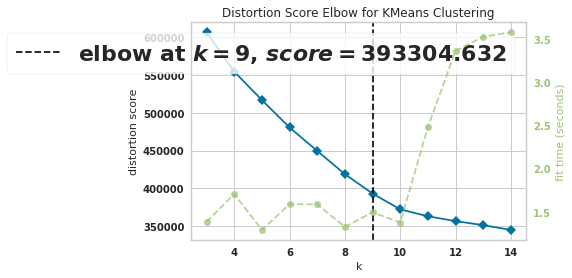

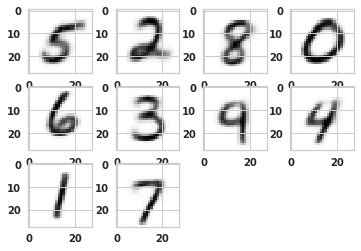

In [82]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [83]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [5, 2, 8, 0,
                                           6, 3, 9, 4,
                                           1, 7
                                          ]
manual_annotation_json["manual_confidence"] = [1, 1, 1, 1,
                                               1, 1, 0.9, 0.9,
                                               1, 1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


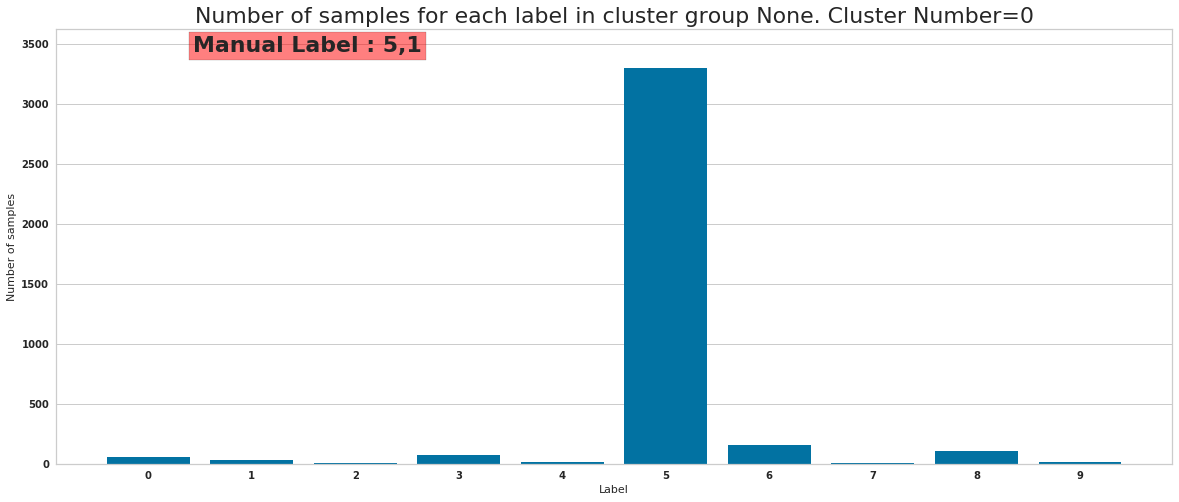

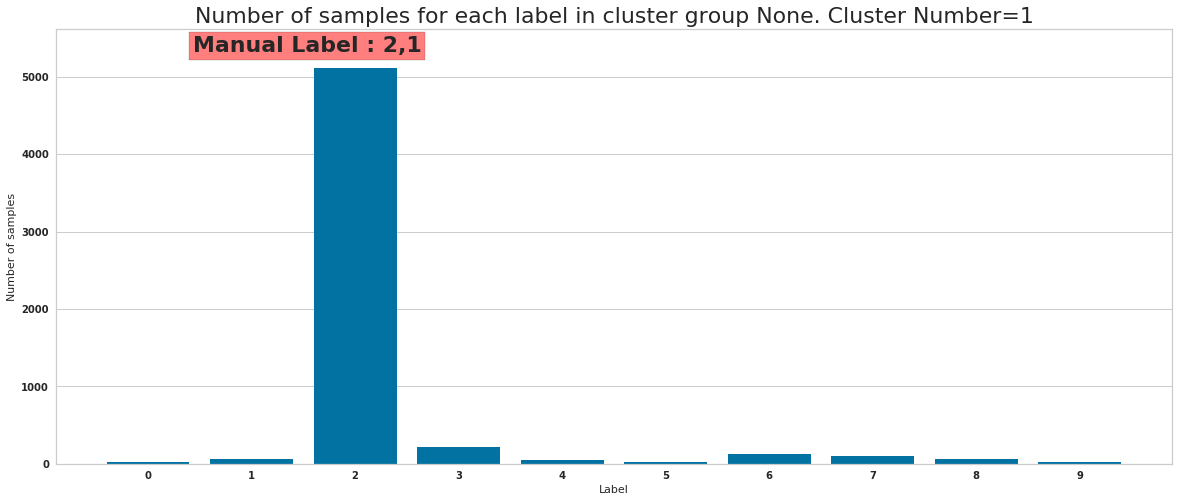

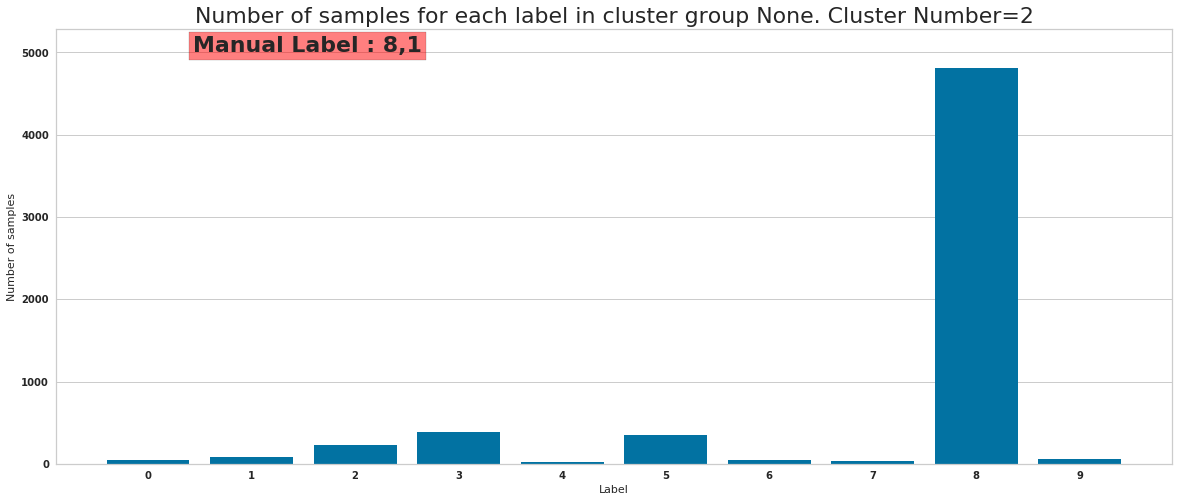

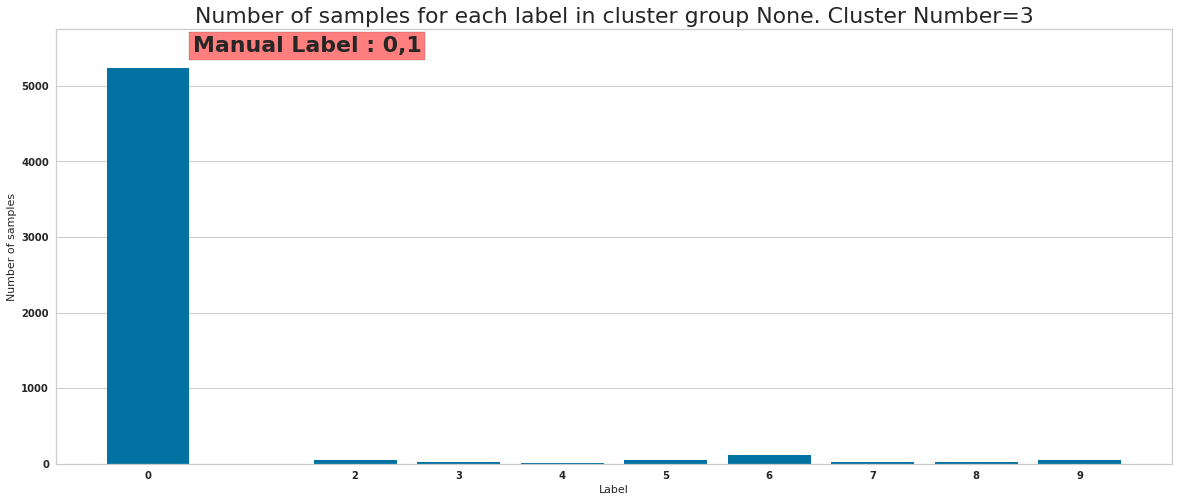

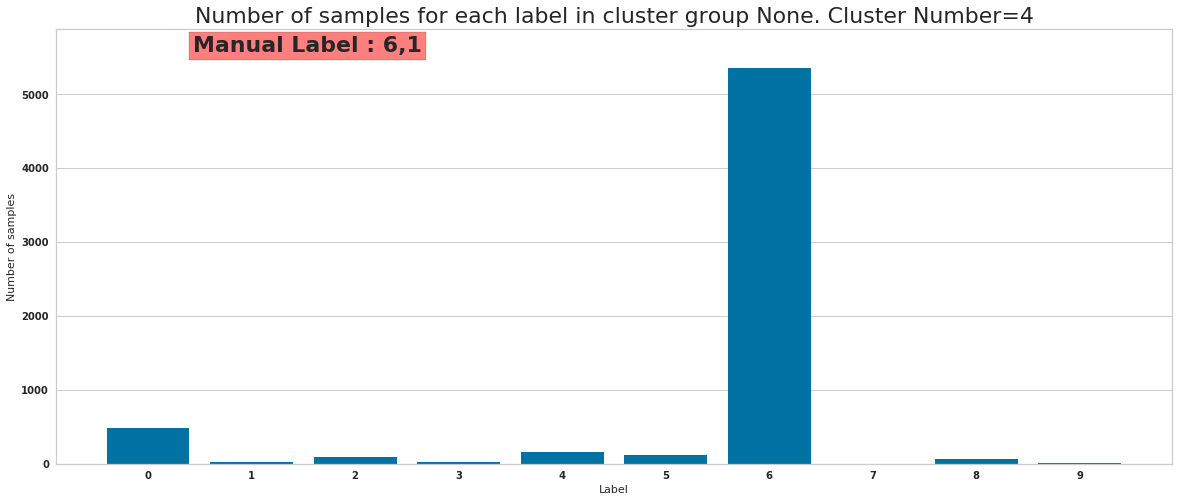

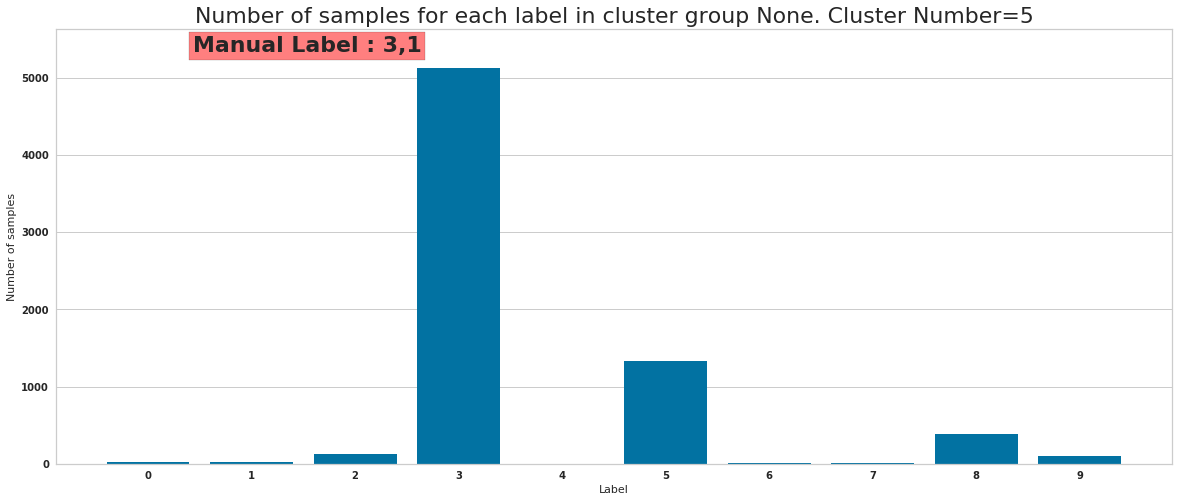

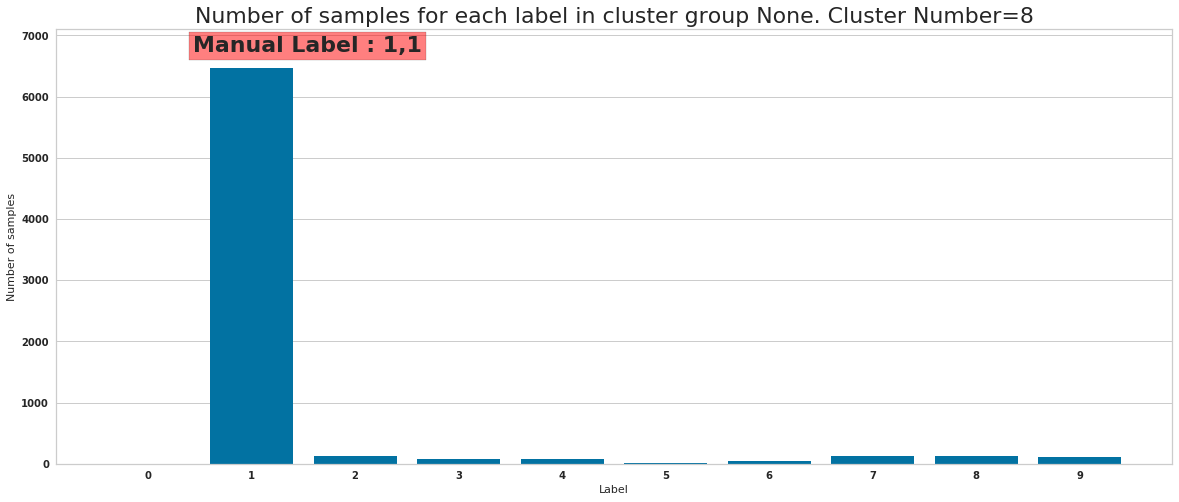

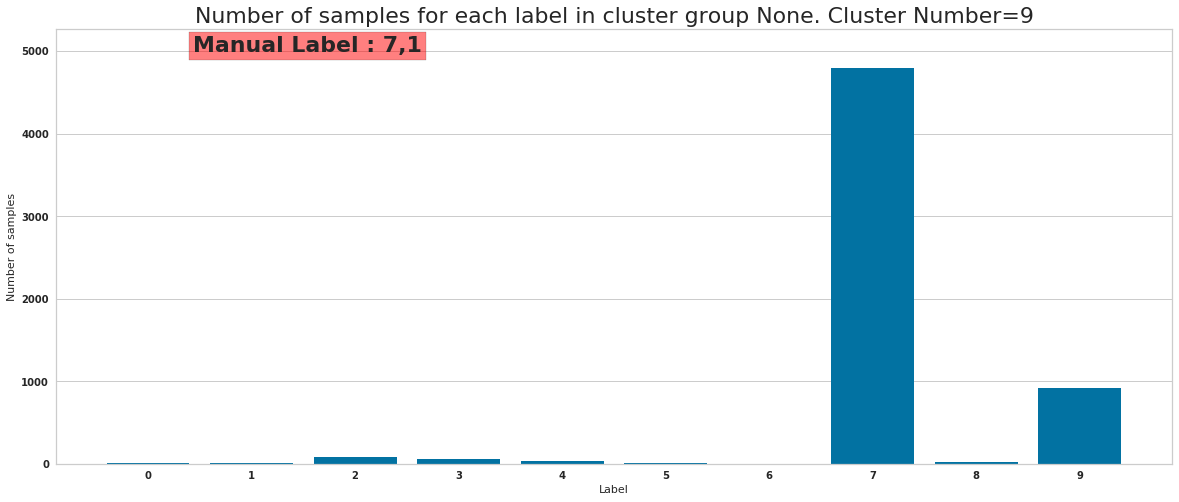

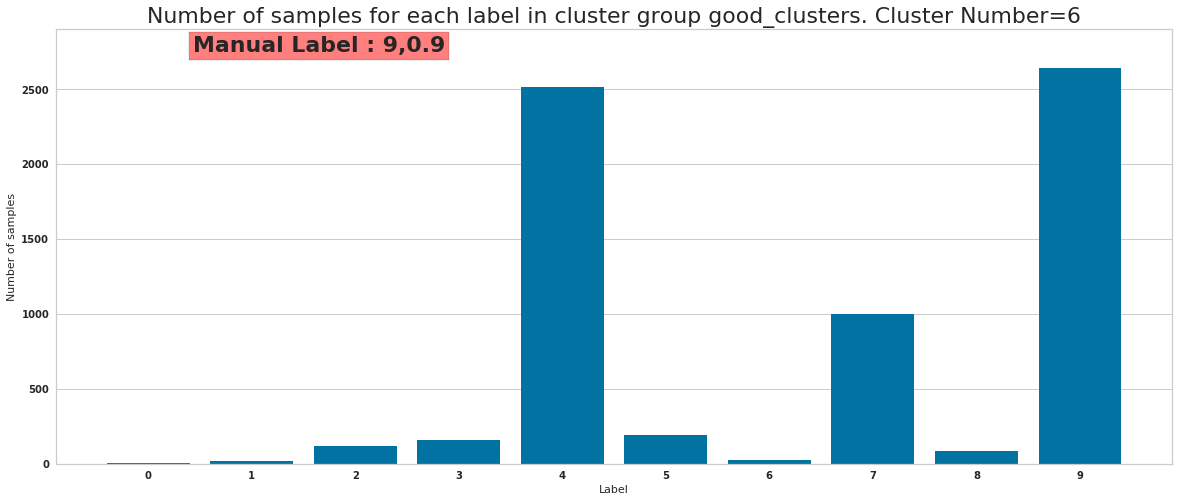

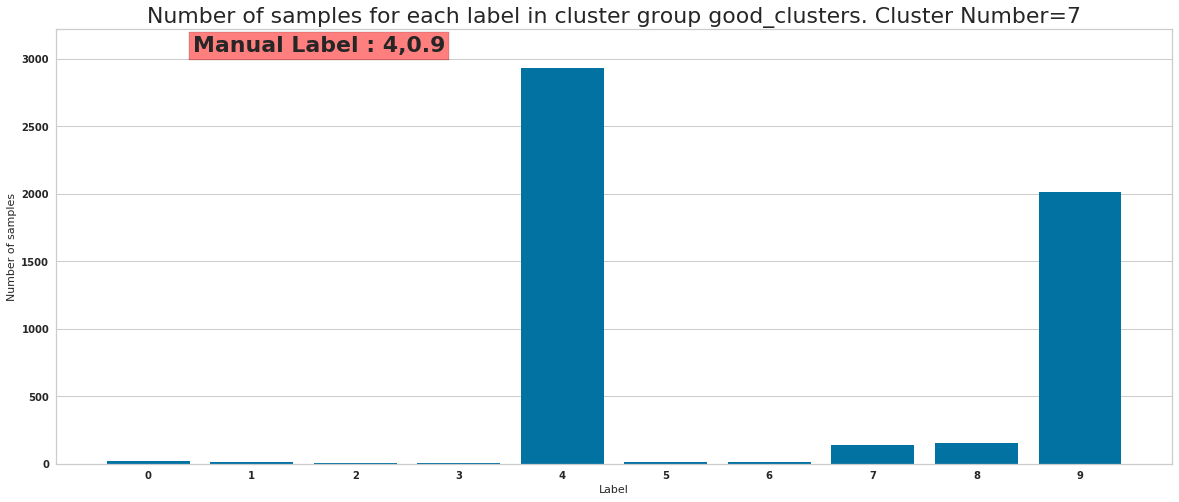

In [84]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [85]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(3758, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5805, 10)
(6057, 10)
(5573, 10)
(6316, 10)
(7158, 10)
(6746, 10)
(5322, 10)
(7174, 10)
(5931, 10)


In [86]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [5,0,-1,5,
#                                          5,8,1,5,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0.7,
#                                              0.8,0.8,0.9,0.7,
#                                              0,0]
# level2_manual_annotations[0] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [87]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 5
(3758, 47) (3758, 33)
Num correct=3297
Cluster 0 Manual Label 5 Percentage correct 87.73283661522086
********************************
Manual Label 2
(5805, 47) (5805, 33)
Num correct=5106
Cluster 1 Manual Label 2 Percentage correct 87.95865633074935
********************************
Manual Label 8
(6057, 47) (6057, 33)
Num correct=4804
Cluster 2 Manual Label 8 Percentage correct 79.31319134885257
********************************
Manual Label 0
(5573, 47) (5573, 33)
Num correct=5229
Cluster 3 Manual Label 0 Percentage correct 93.82738202045577
********************************
Manual Label 6
(6316, 47) (6316, 33)
Num correct=5350
Cluster 4 Manual Label 6 Percentage correct 84.70550981633946
********************************
Manual Label 3
(7158, 47) (7158, 33)
Num correct=5121
Cluster 5 Manual Label 3 Percentage correct 71.54233025984912
********************************
Manual Label 9
(6746, 47) (6746, 33)
Num correct=2639
Cluster 6 Manual Label 9 Percentage correct 39.11947

In [88]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

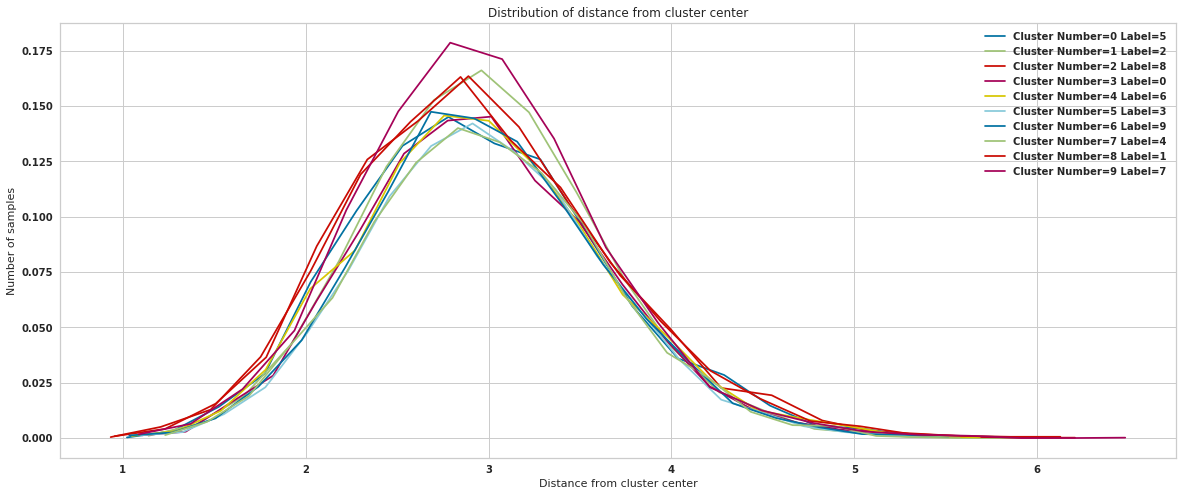

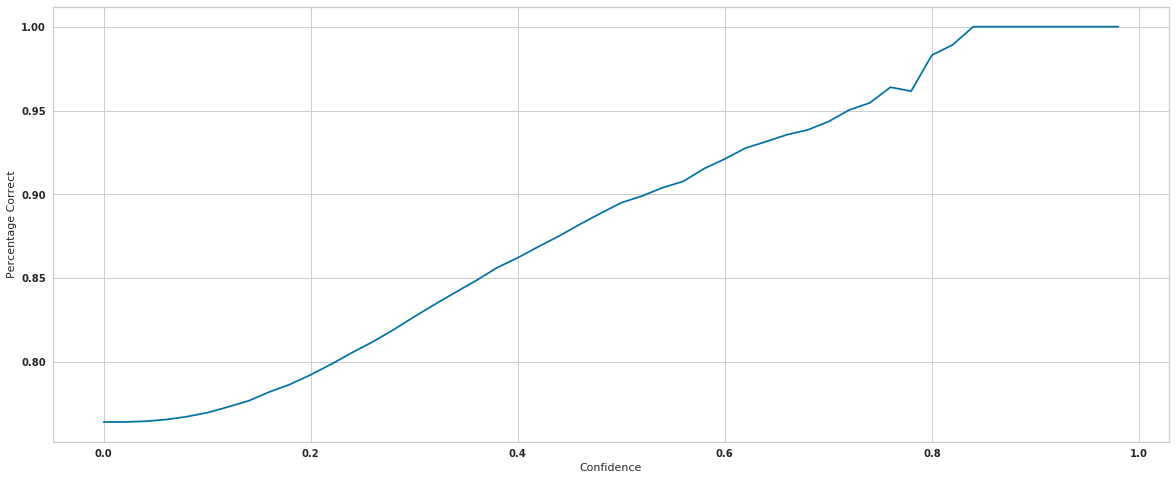

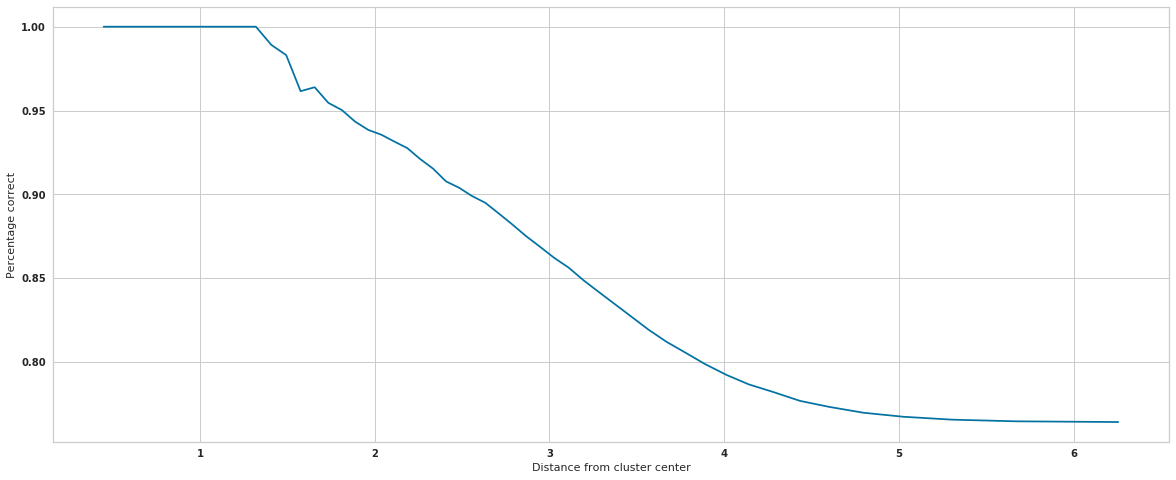

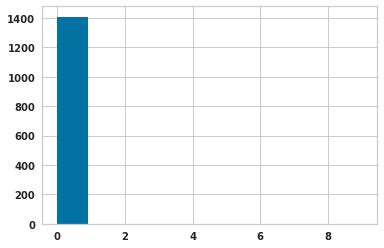

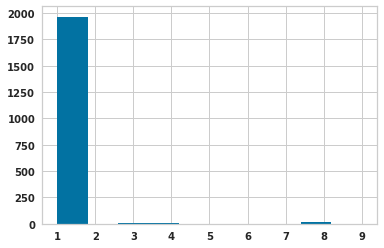

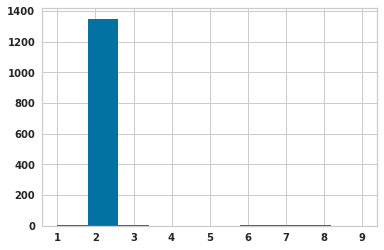

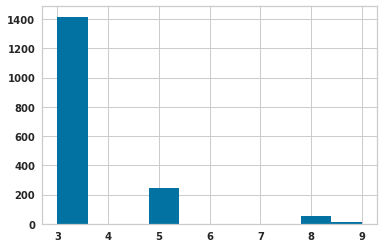

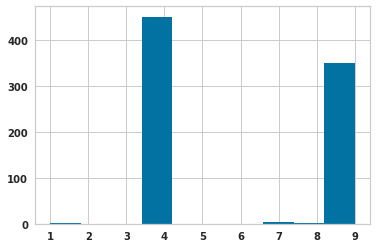

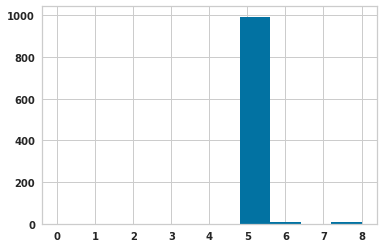

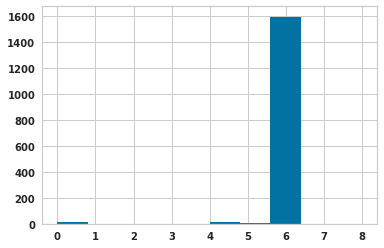

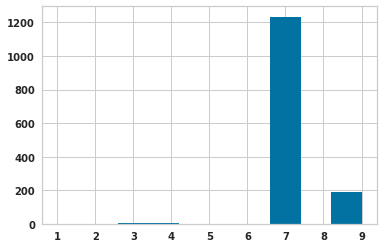

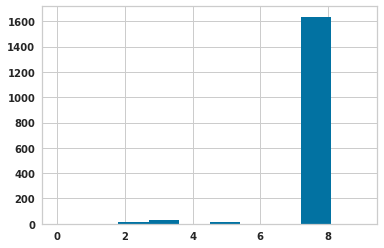

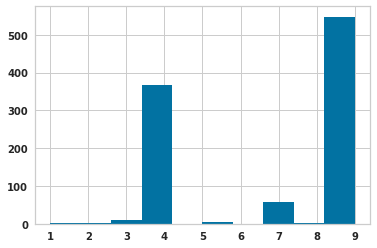

In [89]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [90]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 23427.70988863215
INFO:tensorflow:Summary name Negative Log Likel

Epoch: 4/62, Nll_loss : 126.22969055175781 KLD:9.928390502929688  Supervised loss:0.11189315468072891
Epoch: 4/63, Nll_loss : 117.29022216796875 KLD:9.843719482421875  Supervised loss:0.11585240066051483
Epoch: 4/64, Nll_loss : 116.48080444335938 KLD:9.658452987670898  Supervised loss:0.10083229839801788
Epoch: 4/65, Nll_loss : 119.21955871582031 KLD:10.405048370361328  Supervised loss:0.07699277251958847
Epoch: 4/66, Nll_loss : 107.85926055908203 KLD:9.929045677185059  Supervised loss:0.07226277142763138
Epoch: 4/67, Nll_loss : 110.13924407958984 KLD:9.645943641662598  Supervised loss:0.06802442669868469
Epoch: 4/68, Nll_loss : 115.79106140136719 KLD:10.06246566772461  Supervised loss:0.061781883239746094
Epoch: 4/69, Nll_loss : 120.81173706054688 KLD:10.066740989685059  Supervised loss:0.10932783782482147
Epoch: 4/70, Nll_loss : 113.5738525390625 KLD:9.869287490844727  Supervised loss:0.09857577830553055
Epoch: 4/71, Nll_loss : 109.62028503417969 KLD:9.674278259277344  Supervised los

Epoch: 4/144, Nll_loss : 113.73808288574219 KLD:10.008393287658691  Supervised loss:0.0956931784749031
Epoch: 4/145, Nll_loss : 114.1379165649414 KLD:10.004446029663086  Supervised loss:0.08325089514255524
Epoch: 4/146, Nll_loss : 108.58074951171875 KLD:10.259265899658203  Supervised loss:0.07788097113370895
Epoch: 4/147, Nll_loss : 121.09713745117188 KLD:9.922966003417969  Supervised loss:0.09882956743240356
Epoch: 4/148, Nll_loss : 123.36111450195312 KLD:9.767696380615234  Supervised loss:0.12818625569343567
Epoch: 4/149, Nll_loss : 113.16952514648438 KLD:9.438102722167969  Supervised loss:0.12669603526592255
Epoch: 4/150, Nll_loss : 121.43730163574219 KLD:9.85683536529541  Supervised loss:0.09562485665082932
Epoch: 4/151, Nll_loss : 115.58032989501953 KLD:9.510034561157227  Supervised loss:0.08523163199424744
Epoch: 4/152, Nll_loss : 120.8451919555664 KLD:9.456016540527344  Supervised loss:0.16362524032592773
Epoch: 4/153, Nll_loss : 111.87237548828125 KLD:9.69329833984375  Supervis

Epoch: 4/225, Nll_loss : 121.2960433959961 KLD:9.727785110473633  Supervised loss:0.10829056054353714
Epoch: 4/226, Nll_loss : 118.0748291015625 KLD:9.839006423950195  Supervised loss:0.07522093504667282
Epoch: 4/227, Nll_loss : 115.37001037597656 KLD:9.621444702148438  Supervised loss:0.12900879979133606
Epoch: 4/228, Nll_loss : 121.46780395507812 KLD:9.720625877380371  Supervised loss:0.11860673129558563
Epoch: 4/229, Nll_loss : 114.7591323852539 KLD:9.90478515625  Supervised loss:0.10896618664264679
Epoch: 4/230, Nll_loss : 121.76325988769531 KLD:9.526628494262695  Supervised loss:0.09665165841579437
Epoch: 4/231, Nll_loss : 124.450927734375 KLD:9.676328659057617  Supervised loss:0.0925593227148056
Epoch: 4/232, Nll_loss : 113.39833068847656 KLD:9.629589080810547  Supervised loss:0.06000497192144394
Epoch: 4/233, Nll_loss : 115.61927795410156 KLD:9.93825912475586  Supervised loss:0.05857032537460327
Epoch: 4/234, Nll_loss : 117.95880889892578 KLD:9.692811965942383  Supervised loss:0

Epoch: 4/306, Nll_loss : 122.4287109375 KLD:9.392478942871094  Supervised loss:0.1312253326177597
Epoch: 4/307, Nll_loss : 114.20138549804688 KLD:9.454270362854004  Supervised loss:0.0825970470905304
Epoch: 4/308, Nll_loss : 124.87275695800781 KLD:9.875471115112305  Supervised loss:0.09024085104465485
Epoch: 4/309, Nll_loss : 112.22984313964844 KLD:9.532886505126953  Supervised loss:0.10262338072061539
Epoch: 4/310, Nll_loss : 125.56322479248047 KLD:9.848321914672852  Supervised loss:0.17966723442077637
Epoch: 4/311, Nll_loss : 125.07405853271484 KLD:10.103203773498535  Supervised loss:0.11553814262151718
Epoch: 4/312, Nll_loss : 118.09801483154297 KLD:10.316097259521484  Supervised loss:0.08463115990161896
Epoch: 4/313, Nll_loss : 117.517822265625 KLD:9.97006607055664  Supervised loss:0.096959687769413
Epoch: 4/314, Nll_loss : 109.82243347167969 KLD:9.86130142211914  Supervised loss:0.10376093536615372
Epoch: 4/315, Nll_loss : 111.77848815917969 KLD:9.98025131225586  Supervised loss:0

Epoch: 4/389, Nll_loss : 115.19205474853516 KLD:9.898773193359375  Supervised loss:0.06985314190387726
Epoch: 4/390, Nll_loss : 119.02347564697266 KLD:10.163396835327148  Supervised loss:0.07332636415958405
Epoch: 4/391, Nll_loss : 114.08927917480469 KLD:9.693382263183594  Supervised loss:0.11964575201272964
Epoch: 4/392, Nll_loss : 113.78593444824219 KLD:9.952709197998047  Supervised loss:0.04241747409105301
Epoch: 4/393, Nll_loss : 123.49357604980469 KLD:10.128497123718262  Supervised loss:0.07939384132623672
Epoch: 4/394, Nll_loss : 115.47760009765625 KLD:9.972764015197754  Supervised loss:0.11585219204425812
Epoch: 4/395, Nll_loss : 115.17411804199219 KLD:9.770180702209473  Supervised loss:0.10082556307315826
Epoch: 4/396, Nll_loss : 110.95718383789062 KLD:10.150146484375  Supervised loss:0.07782163470983505
Epoch: 4/397, Nll_loss : 109.5433578491211 KLD:9.476068496704102  Supervised loss:0.08944988250732422
Epoch: 4/398, Nll_loss : 123.68952941894531 KLD:9.980926513671875  Supervi

Epoch: 4/469, Nll_loss : 112.79678344726562 KLD:9.335051536560059  Supervised loss:0.12072084099054337
Epoch: 4/470, Nll_loss : 117.94965362548828 KLD:9.435466766357422  Supervised loss:0.11279323697090149
Epoch: 4/471, Nll_loss : 117.88258361816406 KLD:9.483268737792969  Supervised loss:0.07915841042995453
Epoch: 4/472, Nll_loss : 118.29362487792969 KLD:9.598467826843262  Supervised loss:0.13951636850833893
Epoch: 4/473, Nll_loss : 112.63822937011719 KLD:9.641899108886719  Supervised loss:0.11503016948699951
Epoch: 4/474, Nll_loss : 116.15165710449219 KLD:9.529631614685059  Supervised loss:0.12815630435943604
Epoch: 4/475, Nll_loss : 116.55934143066406 KLD:9.817546844482422  Supervised loss:0.09639111906290054
Epoch: 4/476, Nll_loss : 113.71483612060547 KLD:10.008716583251953  Supervised loss:0.11633999645709991
Epoch: 4/477, Nll_loss : 118.55570983886719 KLD:9.953197479248047  Supervised loss:0.08691179752349854
Epoch: 4/478, Nll_loss : 112.70304870605469 KLD:9.684664726257324  Super

Epoch: 4/551, Nll_loss : 116.88259887695312 KLD:9.712553024291992  Supervised loss:0.11516115069389343
Epoch: 4/552, Nll_loss : 107.72428894042969 KLD:9.405121803283691  Supervised loss:0.09101371467113495
Epoch: 4/553, Nll_loss : 118.50408935546875 KLD:9.624828338623047  Supervised loss:0.0936063826084137
Epoch: 4/554, Nll_loss : 117.90046691894531 KLD:9.498943328857422  Supervised loss:0.08883607387542725
Epoch: 4/555, Nll_loss : 115.25357818603516 KLD:9.868240356445312  Supervised loss:0.11031679064035416
Epoch: 4/556, Nll_loss : 124.1502456665039 KLD:9.698493957519531  Supervised loss:0.11492562294006348
Epoch: 4/557, Nll_loss : 113.14810180664062 KLD:9.84054183959961  Supervised loss:0.1042141318321228
Epoch: 4/558, Nll_loss : 113.1136474609375 KLD:9.733577728271484  Supervised loss:0.1286647915840149
Epoch: 4/559, Nll_loss : 114.05754852294922 KLD:9.618471145629883  Supervised loss:0.07052236795425415
Epoch: 4/560, Nll_loss : 110.22866821289062 KLD:9.34950065612793  Supervised lo

Epoch: 4/632, Nll_loss : 113.00777435302734 KLD:9.564495086669922  Supervised loss:0.08355999737977982
Epoch: 4/633, Nll_loss : 112.33151245117188 KLD:9.551024436950684  Supervised loss:0.1527348756790161
Epoch: 4/634, Nll_loss : 112.84319305419922 KLD:9.816462516784668  Supervised loss:0.08625955134630203
Epoch: 4/635, Nll_loss : 116.49011993408203 KLD:10.126495361328125  Supervised loss:0.1090298742055893
Epoch: 4/636, Nll_loss : 111.67450714111328 KLD:10.358339309692383  Supervised loss:0.12520146369934082
Epoch: 4/637, Nll_loss : 108.47805786132812 KLD:9.690938949584961  Supervised loss:0.058251529932022095
Epoch: 4/638, Nll_loss : 116.10591125488281 KLD:9.675256729125977  Supervised loss:0.1028234213590622
Epoch: 4/639, Nll_loss : 121.04595184326172 KLD:9.474702835083008  Supervised loss:0.09396449476480484
Epoch: 4/640, Nll_loss : 119.22035217285156 KLD:9.064570426940918  Supervised loss:0.15058523416519165
Epoch: 4/641, Nll_loss : 116.38591003417969 KLD:8.839303970336914  Superv

Epoch: 4/712, Nll_loss : 121.0374755859375 KLD:9.627408981323242  Supervised loss:0.12372107803821564
Epoch: 4/713, Nll_loss : 118.53828430175781 KLD:9.486978530883789  Supervised loss:0.10288333147764206
Epoch: 4/714, Nll_loss : 112.71424865722656 KLD:10.167880058288574  Supervised loss:0.09373481571674347
Epoch: 4/715, Nll_loss : 111.13836669921875 KLD:9.834860801696777  Supervised loss:0.054344542324543
Epoch: 4/716, Nll_loss : 113.17234802246094 KLD:9.754207611083984  Supervised loss:0.05821741744875908
Epoch: 4/717, Nll_loss : 120.87043762207031 KLD:10.135980606079102  Supervised loss:0.06073184683918953
Epoch: 4/718, Nll_loss : 104.9593505859375 KLD:9.57960319519043  Supervised loss:0.12379198521375656
Epoch: 4/719, Nll_loss : 117.82974243164062 KLD:9.390958786010742  Supervised loss:0.13303780555725098
Epoch: 4/720, Nll_loss : 115.5008544921875 KLD:9.354673385620117  Supervised loss:0.11473432183265686
Epoch: 4/721, Nll_loss : 118.85801696777344 KLD:9.324667930603027  Supervised

Epoch: 4/792, Nll_loss : 115.94993591308594 KLD:9.750890731811523  Supervised loss:0.07032998651266098
Epoch: 4/793, Nll_loss : 112.06948852539062 KLD:9.028505325317383  Supervised loss:0.0967443436384201
Epoch: 4/794, Nll_loss : 119.88404846191406 KLD:9.315460205078125  Supervised loss:0.07029285281896591
Epoch: 4/795, Nll_loss : 115.48609924316406 KLD:9.332443237304688  Supervised loss:0.1043989434838295
Epoch: 4/796, Nll_loss : 121.19942474365234 KLD:9.476129531860352  Supervised loss:0.09211559593677521
Epoch: 4/797, Nll_loss : 118.30648803710938 KLD:9.378862380981445  Supervised loss:0.10380327701568604
Epoch: 4/798, Nll_loss : 118.18024444580078 KLD:9.163792610168457  Supervised loss:0.11630948632955551
Epoch: 4/799, Nll_loss : 123.55421447753906 KLD:9.924482345581055  Supervised loss:0.09330632537603378
Epoch: 4/800, Nll_loss : 117.42058563232422 KLD:9.648229598999023  Supervised loss:0.06042534112930298
Epoch: 4/801, Nll_loss : 112.98703002929688 KLD:9.451053619384766  Supervis

Epoch: 4/873, Nll_loss : 117.98472595214844 KLD:9.810284614562988  Supervised loss:0.10425339639186859
Epoch: 4/874, Nll_loss : 117.7362289428711 KLD:9.971674919128418  Supervised loss:0.14717721939086914
Epoch: 4/875, Nll_loss : 115.74320220947266 KLD:10.019582748413086  Supervised loss:0.10523951053619385
Epoch: 4/876, Nll_loss : 109.15403747558594 KLD:10.164764404296875  Supervised loss:0.09819227457046509
Epoch: 4/877, Nll_loss : 116.57479858398438 KLD:10.391375541687012  Supervised loss:0.10982446372509003
Epoch: 4/878, Nll_loss : 118.40299224853516 KLD:10.54558277130127  Supervised loss:0.07447969913482666
Epoch: 4/879, Nll_loss : 108.56575012207031 KLD:10.283863067626953  Supervised loss:0.07206583023071289
Epoch: 4/880, Nll_loss : 113.51956176757812 KLD:9.56005573272705  Supervised loss:0.1070123016834259
Epoch: 4/881, Nll_loss : 116.15918731689453 KLD:9.906112670898438  Supervised loss:0.10831061750650406
Epoch: 4/882, Nll_loss : 115.13719940185547 KLD:9.555183410644531  Super

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-4675"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-4675"
 
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

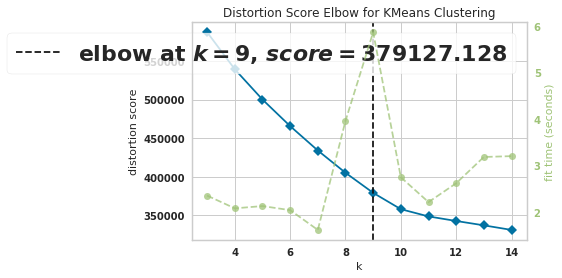

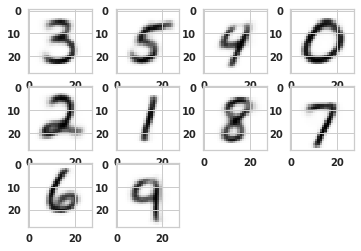

In [91]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


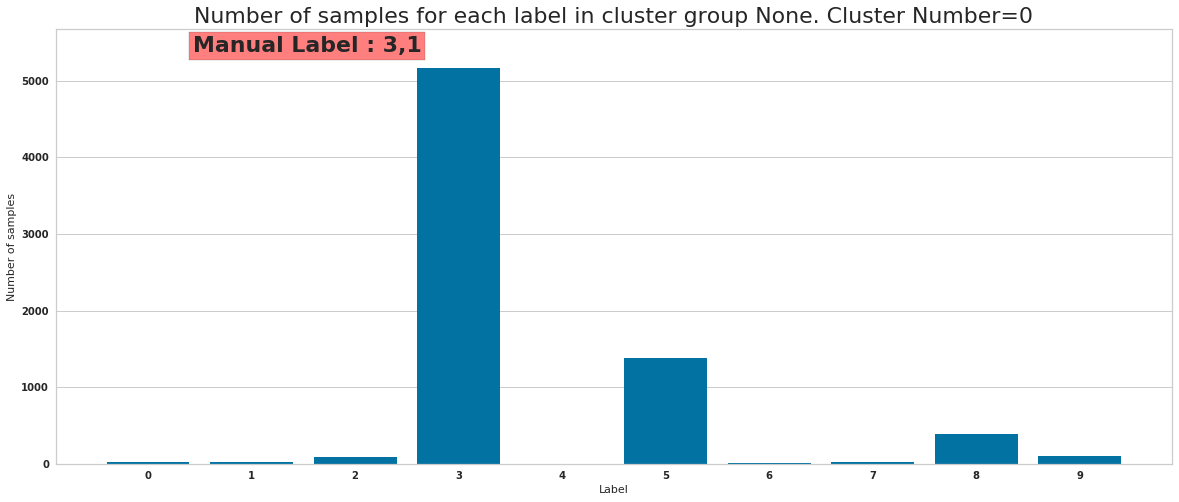

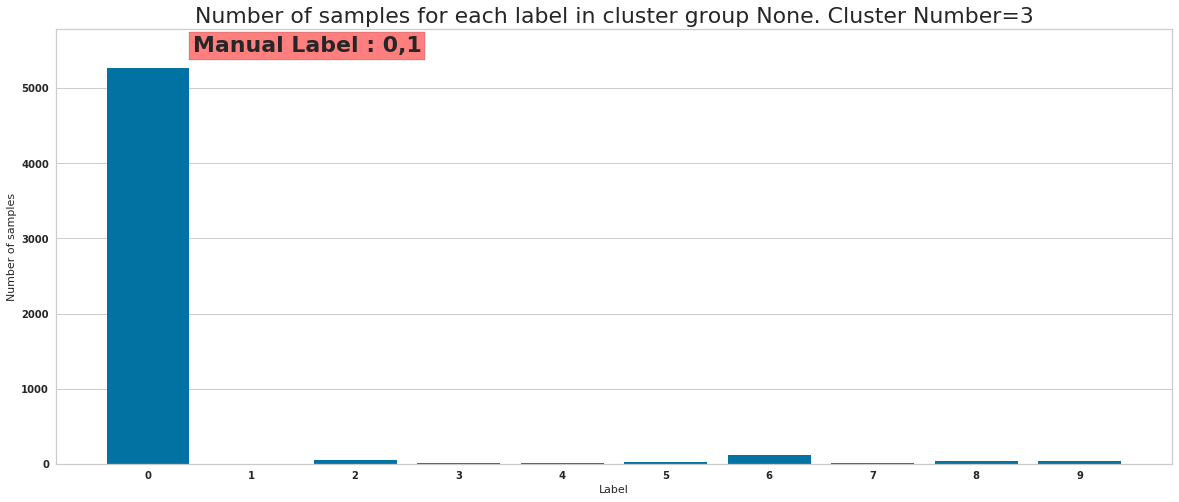

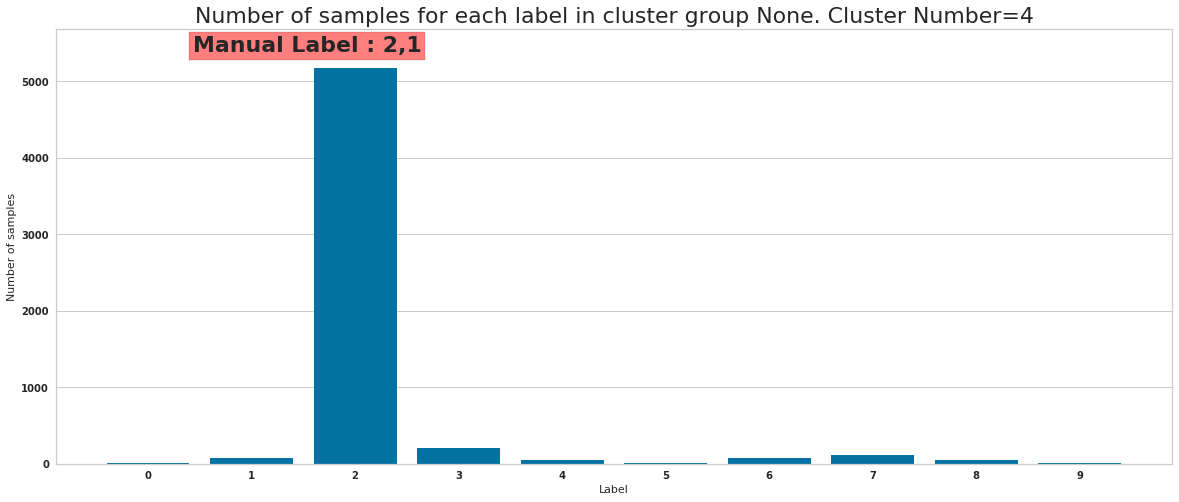

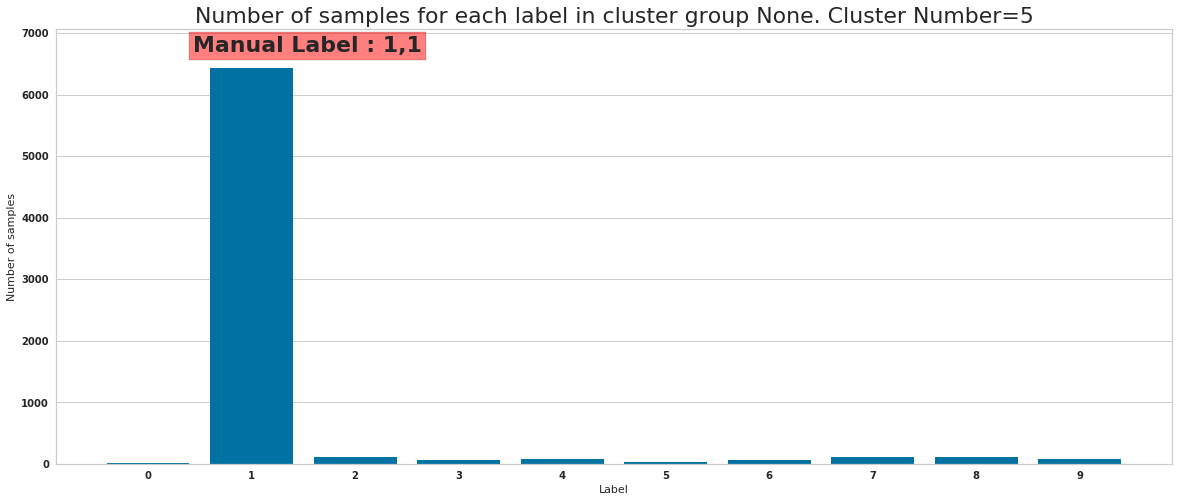

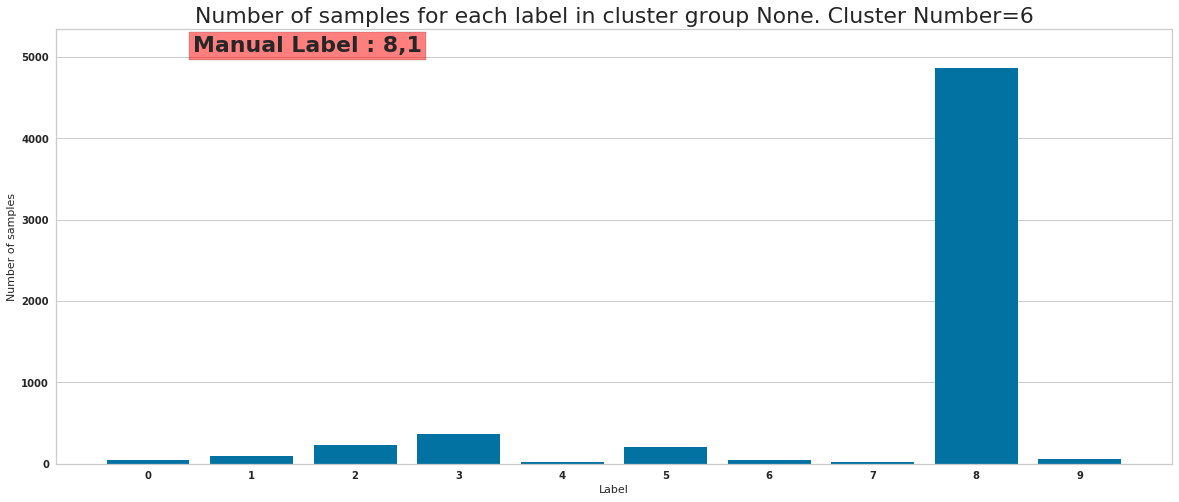

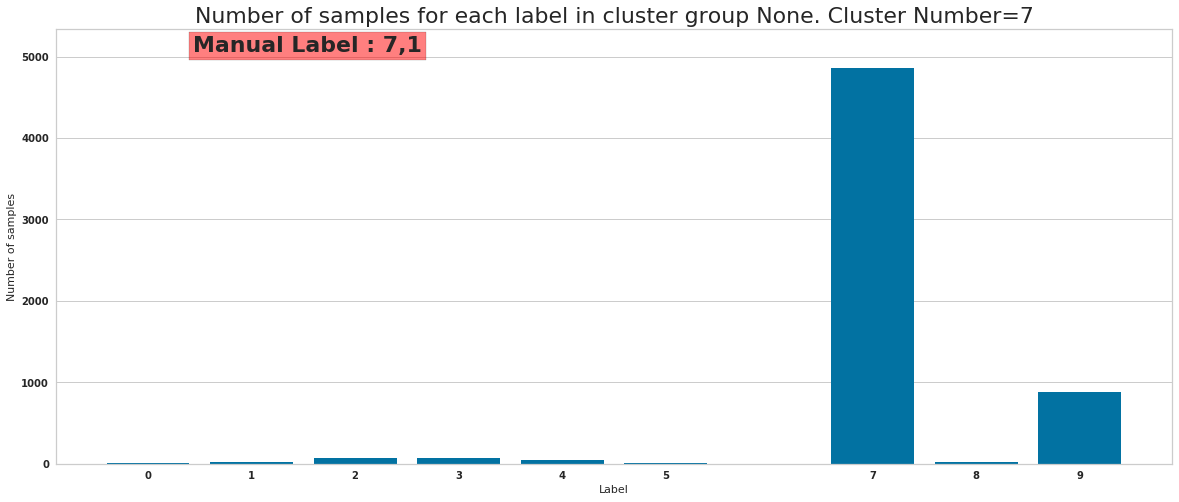

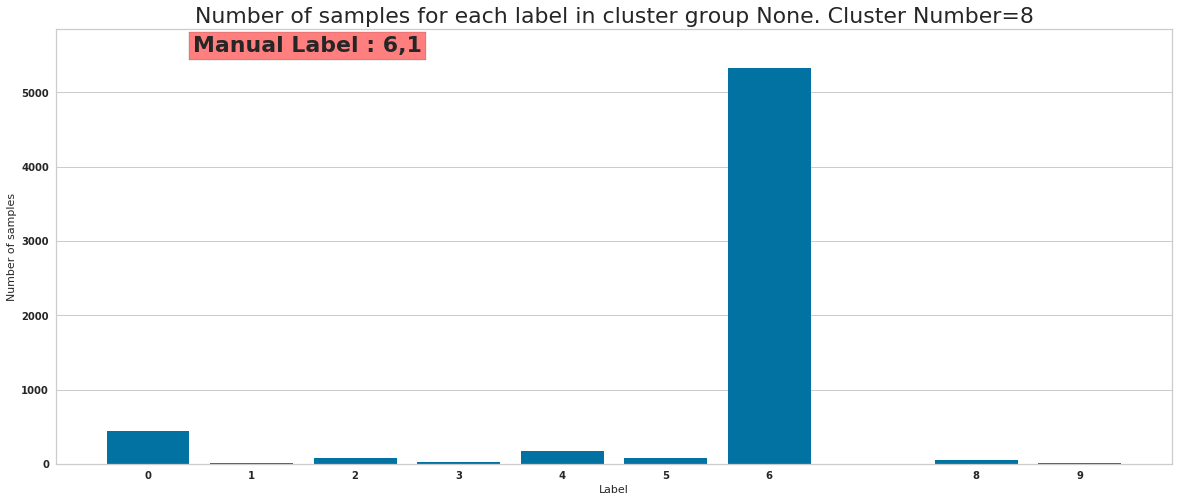

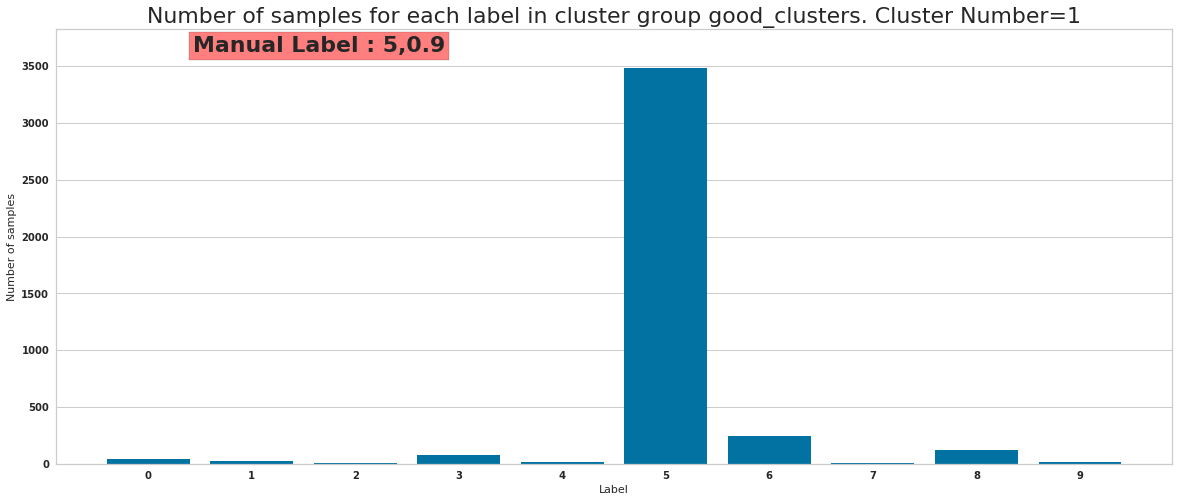

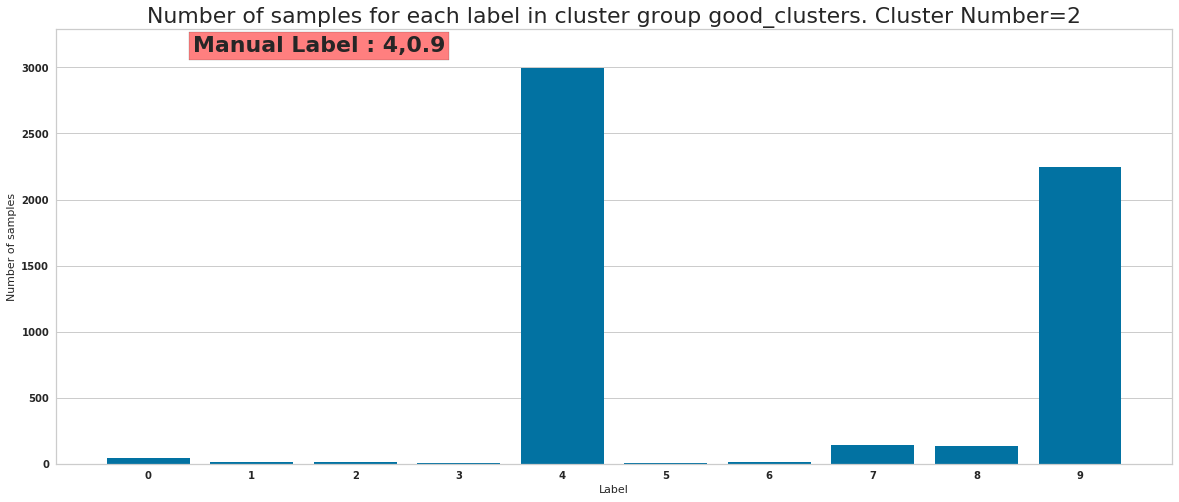

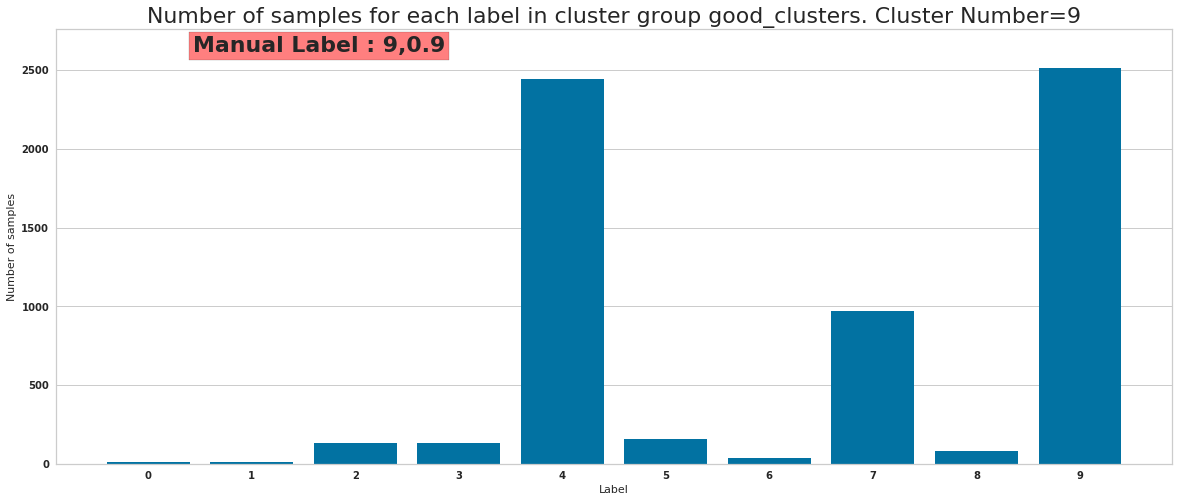

In [92]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [3, 5, 4, 0,
                                           2, 1, 8, 7,
                                           6, 9
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,0.9,1,
                                               1,1,1,1,
                                               1,0.9
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [93]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



(7194, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(4028, 10)
(5610, 10)
(5552, 10)
(5773, 10)
(7055, 10)
(5968, 10)
(5985, 10)
(6191, 10)
(6484, 10)


In [94]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [95]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    compute_distance_level_2(df, num_level_2_clusters, cluster_labels, z_col_names, cluster_centers)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 3
(7194, 47) (7194, 33)
Num correct=5158
Cluster 0 Manual Label 3 Percentage correct 71.69863775368363
********************************
Manual Label 5
(4028, 47) (4028, 33)
Num correct=3479
Cluster 1 Manual Label 5 Percentage correct 86.37040714995035
********************************
Manual Label 4
(5610, 47) (5610, 33)
Num correct=2992
Cluster 2 Manual Label 4 Percentage correct 53.333333333333336
********************************
Manual Label 0
(5552, 47) (5552, 33)
Num correct=5262
Cluster 3 Manual Label 0 Percentage correct 94.77665706051873
********************************
Manual Label 2
(5773, 47) (5773, 33)
Num correct=5168
Cluster 4 Manual Label 2 Percentage correct 89.52018014896935
********************************
Manual Label 1
(7055, 47) (7055, 33)
Num correct=6425
Cluster 5 Manual Label 1 Percentage correct 91.07016300496102
********************************
Manual Label 8
(5968, 47) (5968, 33)
Num correct=4861
Cluster 6 Manual Label 8 Percentage correct 81.4510

In [96]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

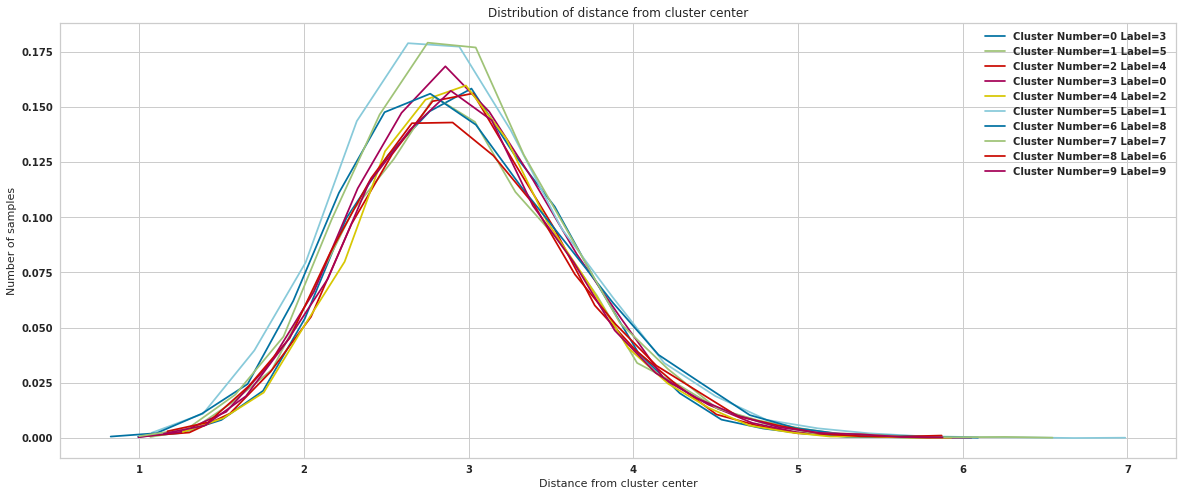

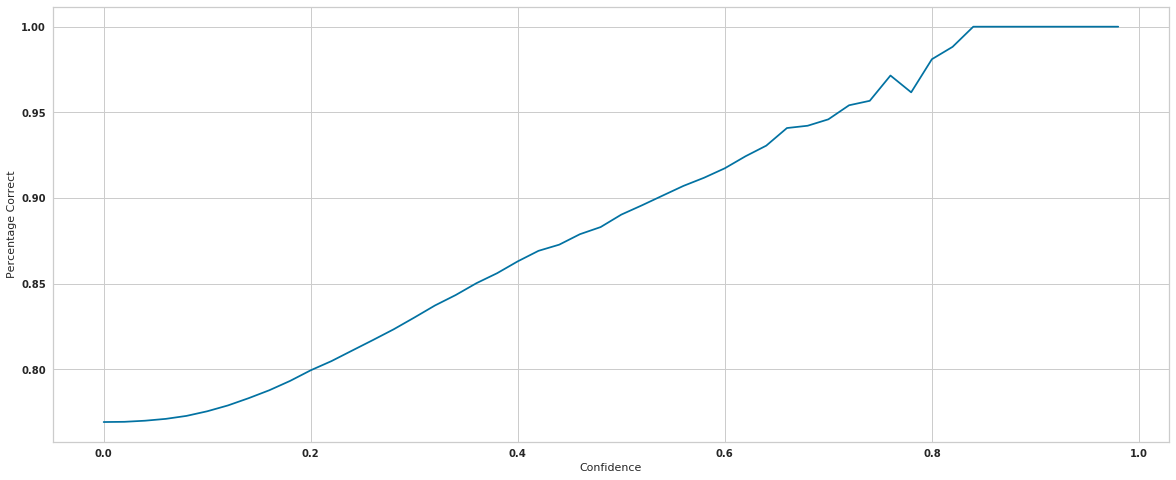

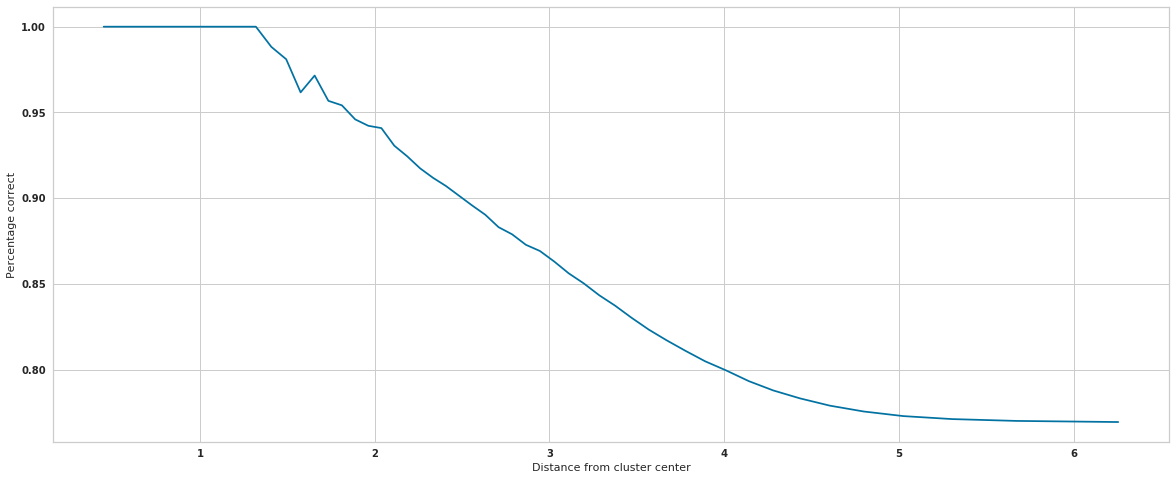

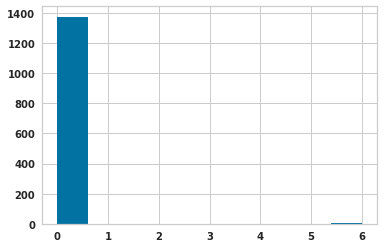

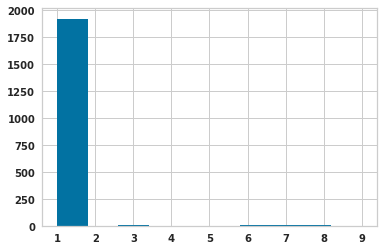

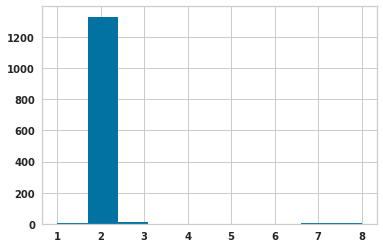

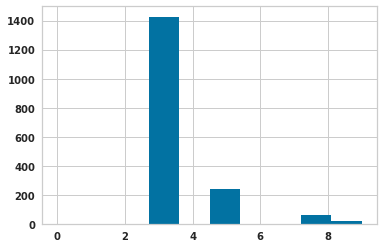

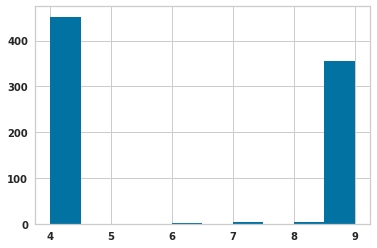

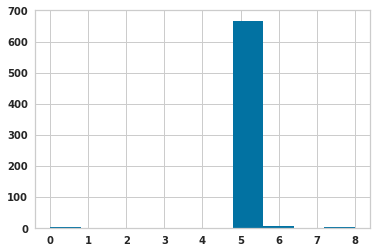

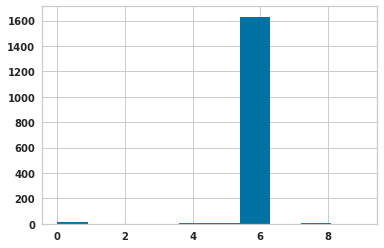

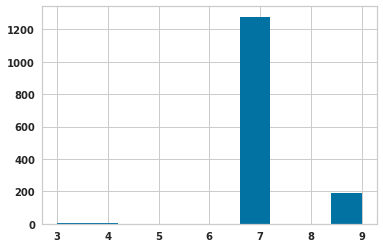

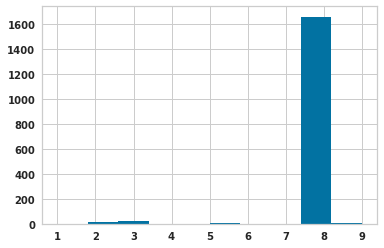

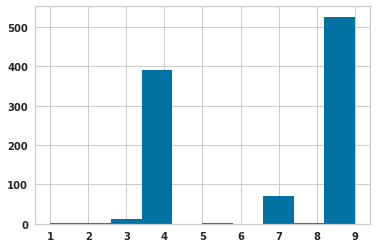

In [97]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 6

In [98]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 46, 'ID': 1, 'name': 'semi_sup_gaussian_mah_k10'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 23299.200864491453
INFO:tensorflow:Summary name Negative Log Like

Epoch: 5/61, Nll_loss : 111.91512298583984 KLD:9.703889846801758  Supervised loss:0.08817346394062042
Epoch: 5/62, Nll_loss : 124.35150909423828 KLD:10.167241096496582  Supervised loss:0.06210636720061302
Epoch: 5/63, Nll_loss : 116.07888793945312 KLD:9.985695838928223  Supervised loss:0.11157479137182236
Epoch: 5/64, Nll_loss : 115.36280822753906 KLD:9.781314849853516  Supervised loss:0.06434126943349838
Epoch: 5/65, Nll_loss : 117.17216491699219 KLD:10.562450408935547  Supervised loss:0.08959201723337173
Epoch: 5/66, Nll_loss : 105.49592590332031 KLD:9.76019287109375  Supervised loss:0.04188747704029083
Epoch: 5/67, Nll_loss : 107.88164520263672 KLD:9.495943069458008  Supervised loss:0.12168726325035095
Epoch: 5/68, Nll_loss : 114.57299041748047 KLD:9.740974426269531  Supervised loss:0.08176450431346893
Epoch: 5/69, Nll_loss : 121.45819091796875 KLD:9.773866653442383  Supervised loss:0.10310490429401398
Epoch: 5/70, Nll_loss : 112.84872436523438 KLD:9.72230052947998  Supervised loss:

Epoch: 5/143, Nll_loss : 115.10160064697266 KLD:9.618231773376465  Supervised loss:0.11633750796318054
Epoch: 5/144, Nll_loss : 114.06269836425781 KLD:9.642426490783691  Supervised loss:0.09802009910345078
Epoch: 5/145, Nll_loss : 114.45726776123047 KLD:9.603218078613281  Supervised loss:0.11687971651554108
Epoch: 5/146, Nll_loss : 110.6169662475586 KLD:10.14000129699707  Supervised loss:0.0682496726512909
Epoch: 5/147, Nll_loss : 115.44955444335938 KLD:10.28663158416748  Supervised loss:0.09470602869987488
Epoch: 5/148, Nll_loss : 119.32006072998047 KLD:10.352144241333008  Supervised loss:0.09451887011528015
Epoch: 5/149, Nll_loss : 110.08699035644531 KLD:10.12295150756836  Supervised loss:0.1026262417435646
Epoch: 5/150, Nll_loss : 116.95927429199219 KLD:10.485743522644043  Supervised loss:0.11138555407524109
Epoch: 5/151, Nll_loss : 111.9017105102539 KLD:10.009593963623047  Supervised loss:0.05653470754623413
Epoch: 5/152, Nll_loss : 114.19502258300781 KLD:9.76799201965332  Supervis

Epoch: 5/224, Nll_loss : 119.97233581542969 KLD:9.817955017089844  Supervised loss:0.08581218868494034
Epoch: 5/225, Nll_loss : 122.6191177368164 KLD:9.312087059020996  Supervised loss:0.11118802428245544
Epoch: 5/226, Nll_loss : 116.9075927734375 KLD:9.448102951049805  Supervised loss:0.11153559386730194
Epoch: 5/227, Nll_loss : 117.19662475585938 KLD:9.335941314697266  Supervised loss:0.13525789976119995
Epoch: 5/228, Nll_loss : 119.78668212890625 KLD:9.592506408691406  Supervised loss:0.11266067624092102
Epoch: 5/229, Nll_loss : 111.59246063232422 KLD:9.89844036102295  Supervised loss:0.12059511244297028
Epoch: 5/230, Nll_loss : 119.97993469238281 KLD:9.68187427520752  Supervised loss:0.10872307419776917
Epoch: 5/231, Nll_loss : 118.85838317871094 KLD:9.827194213867188  Supervised loss:0.09290523827075958
Epoch: 5/232, Nll_loss : 110.59089660644531 KLD:9.85400390625  Supervised loss:0.06122712790966034
Epoch: 5/233, Nll_loss : 114.59843444824219 KLD:9.984904289245605  Supervised los

Epoch: 5/305, Nll_loss : 112.98513793945312 KLD:9.189249038696289  Supervised loss:0.08212009072303772
Epoch: 5/306, Nll_loss : 120.02131652832031 KLD:9.171547889709473  Supervised loss:0.11706171184778214
Epoch: 5/307, Nll_loss : 113.88667297363281 KLD:9.067529678344727  Supervised loss:0.05881934612989426
Epoch: 5/308, Nll_loss : 123.23297882080078 KLD:9.594375610351562  Supervised loss:0.08204594254493713
Epoch: 5/309, Nll_loss : 113.18699645996094 KLD:9.137992858886719  Supervised loss:0.09008993953466415
Epoch: 5/310, Nll_loss : 123.92536926269531 KLD:9.593465805053711  Supervised loss:0.09194223582744598
Epoch: 5/311, Nll_loss : 122.01103973388672 KLD:9.995092391967773  Supervised loss:0.07519868016242981
Epoch: 5/312, Nll_loss : 116.2645492553711 KLD:10.366606712341309  Supervised loss:0.07842797040939331
Epoch: 5/313, Nll_loss : 116.73162078857422 KLD:10.131787300109863  Supervised loss:0.05816539376974106
Epoch: 5/314, Nll_loss : 109.82614135742188 KLD:10.155009269714355  Supe

Epoch: 5/385, Nll_loss : 120.29378509521484 KLD:9.585180282592773  Supervised loss:0.16299742460250854
Epoch: 5/386, Nll_loss : 118.5511703491211 KLD:9.485260009765625  Supervised loss:0.07166855037212372
Epoch: 5/387, Nll_loss : 111.9761962890625 KLD:9.172842025756836  Supervised loss:0.08790013939142227
Epoch: 5/388, Nll_loss : 119.40410614013672 KLD:9.537328720092773  Supervised loss:0.13459569215774536
Epoch: 5/389, Nll_loss : 112.54828643798828 KLD:9.687482833862305  Supervised loss:0.08046486973762512
Epoch: 5/390, Nll_loss : 116.83842468261719 KLD:10.170408248901367  Supervised loss:0.07373809814453125
Epoch: 5/391, Nll_loss : 106.9434814453125 KLD:10.022472381591797  Supervised loss:0.04475487768650055
Epoch: 5/392, Nll_loss : 113.49609375 KLD:9.990453720092773  Supervised loss:0.08644570410251617
Epoch: 5/393, Nll_loss : 116.3386001586914 KLD:10.276827812194824  Supervised loss:0.09484607726335526
Epoch: 5/394, Nll_loss : 114.959716796875 KLD:9.853331565856934  Supervised loss

Epoch: 5/467, Nll_loss : 110.63941955566406 KLD:9.784143447875977  Supervised loss:0.0644167810678482
Epoch: 5/468, Nll_loss : 119.86129760742188 KLD:9.881903648376465  Supervised loss:0.08107995986938477
Epoch: 5/469, Nll_loss : 108.42632293701172 KLD:9.925918579101562  Supervised loss:0.08935264497995377
Epoch: 5/470, Nll_loss : 113.49186706542969 KLD:10.03257942199707  Supervised loss:0.05381098762154579
Epoch: 5/471, Nll_loss : 110.22766876220703 KLD:10.241676330566406  Supervised loss:0.04518497735261917
Epoch: 5/472, Nll_loss : 115.94215393066406 KLD:10.151473999023438  Supervised loss:0.1225314661860466
Epoch: 5/473, Nll_loss : 113.33820343017578 KLD:10.0096435546875  Supervised loss:0.12776948511600494
Epoch: 5/474, Nll_loss : 113.12481689453125 KLD:9.676447868347168  Supervised loss:0.09417983889579773
Epoch: 5/475, Nll_loss : 114.48457336425781 KLD:9.818470001220703  Supervised loss:0.08070715516805649
Epoch: 5/476, Nll_loss : 114.47064208984375 KLD:9.72973918914795  Supervis

Epoch: 5/548, Nll_loss : 112.56428527832031 KLD:9.250041007995605  Supervised loss:0.10451988875865936
Epoch: 5/549, Nll_loss : 113.18345642089844 KLD:9.284680366516113  Supervised loss:0.0805177092552185
Epoch: 5/550, Nll_loss : 112.99414825439453 KLD:9.649032592773438  Supervised loss:0.0660967230796814
Epoch: 5/551, Nll_loss : 113.83175659179688 KLD:9.741693496704102  Supervised loss:0.10588519275188446
Epoch: 5/552, Nll_loss : 106.98497772216797 KLD:9.63974380493164  Supervised loss:0.1053503006696701
Epoch: 5/553, Nll_loss : 114.45136260986328 KLD:10.053964614868164  Supervised loss:0.09659025818109512
Epoch: 5/554, Nll_loss : 112.43516540527344 KLD:10.018916130065918  Supervised loss:0.07110432535409927
Epoch: 5/555, Nll_loss : 114.1923828125 KLD:10.417427062988281  Supervised loss:0.10215769708156586
Epoch: 5/556, Nll_loss : 119.30995178222656 KLD:10.073029518127441  Supervised loss:0.12025612592697144
Epoch: 5/557, Nll_loss : 110.21403503417969 KLD:9.917234420776367  Supervised

Epoch: 5/628, Nll_loss : 112.69808197021484 KLD:9.7853364944458  Supervised loss:0.08541502058506012
Epoch: 5/629, Nll_loss : 117.82392120361328 KLD:9.614749908447266  Supervised loss:0.1378002017736435
Epoch: 5/630, Nll_loss : 117.59754943847656 KLD:9.496333122253418  Supervised loss:0.09082761406898499
Epoch: 5/631, Nll_loss : 111.66357421875 KLD:9.489356994628906  Supervised loss:0.08780227601528168
Epoch: 5/632, Nll_loss : 113.91508483886719 KLD:9.455095291137695  Supervised loss:0.08239490538835526
Epoch: 5/633, Nll_loss : 110.84988403320312 KLD:9.44720458984375  Supervised loss:0.08364980667829514
Epoch: 5/634, Nll_loss : 113.18113708496094 KLD:9.684282302856445  Supervised loss:0.10022846609354019
Epoch: 5/635, Nll_loss : 116.44347381591797 KLD:9.984609603881836  Supervised loss:0.122014619410038
Epoch: 5/636, Nll_loss : 108.41302490234375 KLD:10.235625267028809  Supervised loss:0.06364747881889343
Epoch: 5/637, Nll_loss : 105.55354309082031 KLD:9.659622192382812  Supervised los

Epoch: 5/710, Nll_loss : 116.39689636230469 KLD:9.687179565429688  Supervised loss:0.06814494729042053
Epoch: 5/711, Nll_loss : 117.12114715576172 KLD:9.543477058410645  Supervised loss:0.059824395924806595
Epoch: 5/712, Nll_loss : 117.81202697753906 KLD:9.695594787597656  Supervised loss:0.09061587601900101
Epoch: 5/713, Nll_loss : 112.52801513671875 KLD:9.636178016662598  Supervised loss:0.057471517473459244
Epoch: 5/714, Nll_loss : 111.6727294921875 KLD:10.206104278564453  Supervised loss:0.06049306318163872
Epoch: 5/715, Nll_loss : 111.44136047363281 KLD:9.803056716918945  Supervised loss:0.10643935948610306
Epoch: 5/716, Nll_loss : 111.06961059570312 KLD:9.856925964355469  Supervised loss:0.050047099590301514
Epoch: 5/717, Nll_loss : 116.66677856445312 KLD:10.213493347167969  Supervised loss:0.055185504257678986
Epoch: 5/718, Nll_loss : 109.55116271972656 KLD:9.634099960327148  Supervised loss:0.07395963370800018
Epoch: 5/719, Nll_loss : 119.83016967773438 KLD:9.719877243041992  S

Epoch: 5/790, Nll_loss : 114.104248046875 KLD:10.466766357421875  Supervised loss:0.08156684786081314
Epoch: 5/791, Nll_loss : 108.91189575195312 KLD:10.281721115112305  Supervised loss:0.08436470478773117
Epoch: 5/792, Nll_loss : 112.9495849609375 KLD:10.324549674987793  Supervised loss:0.06179055571556091
Epoch: 5/793, Nll_loss : 105.848876953125 KLD:9.682271003723145  Supervised loss:0.10862899571657181
Epoch: 5/794, Nll_loss : 116.25570678710938 KLD:9.779378890991211  Supervised loss:0.08554216474294662
Epoch: 5/795, Nll_loss : 110.81500244140625 KLD:9.793851852416992  Supervised loss:0.11330892145633698
Epoch: 5/796, Nll_loss : 124.48949432373047 KLD:9.724082946777344  Supervised loss:0.07860291004180908
Epoch: 5/797, Nll_loss : 113.15902709960938 KLD:9.585610389709473  Supervised loss:0.08317074179649353
Epoch: 5/798, Nll_loss : 116.56318664550781 KLD:9.420576095581055  Supervised loss:0.10701531171798706
Epoch: 5/799, Nll_loss : 124.09349822998047 KLD:9.988094329833984  Supervis

Epoch: 5/871, Nll_loss : 112.04545593261719 KLD:10.333319664001465  Supervised loss:0.1212053894996643
Epoch: 5/872, Nll_loss : 110.37271118164062 KLD:10.026321411132812  Supervised loss:0.06932327896356583
Epoch: 5/873, Nll_loss : 113.35456085205078 KLD:9.973252296447754  Supervised loss:0.10154072940349579
Epoch: 5/874, Nll_loss : 115.96258544921875 KLD:9.682722091674805  Supervised loss:0.09022052586078644
Epoch: 5/875, Nll_loss : 114.38153839111328 KLD:9.499006271362305  Supervised loss:0.07913392037153244
Epoch: 5/876, Nll_loss : 111.06645965576172 KLD:9.421544075012207  Supervised loss:0.11608082056045532
Epoch: 5/877, Nll_loss : 117.91536712646484 KLD:9.859366416931152  Supervised loss:0.12684954702854156
Epoch: 5/878, Nll_loss : 122.20362091064453 KLD:10.08843994140625  Supervised loss:0.13301131129264832
Epoch: 5/879, Nll_loss : 107.95391845703125 KLD:10.294889450073242  Supervised loss:0.06363721191883087
Epoch: 5/880, Nll_loss : 109.6158447265625 KLD:9.86922550201416  Superv

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64

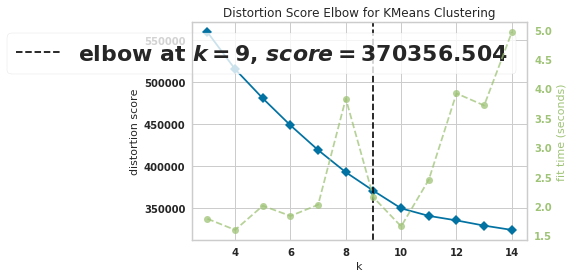

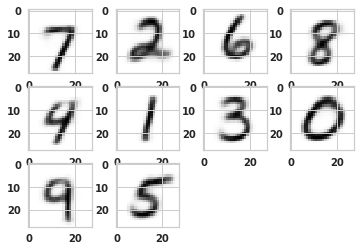

In [101]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


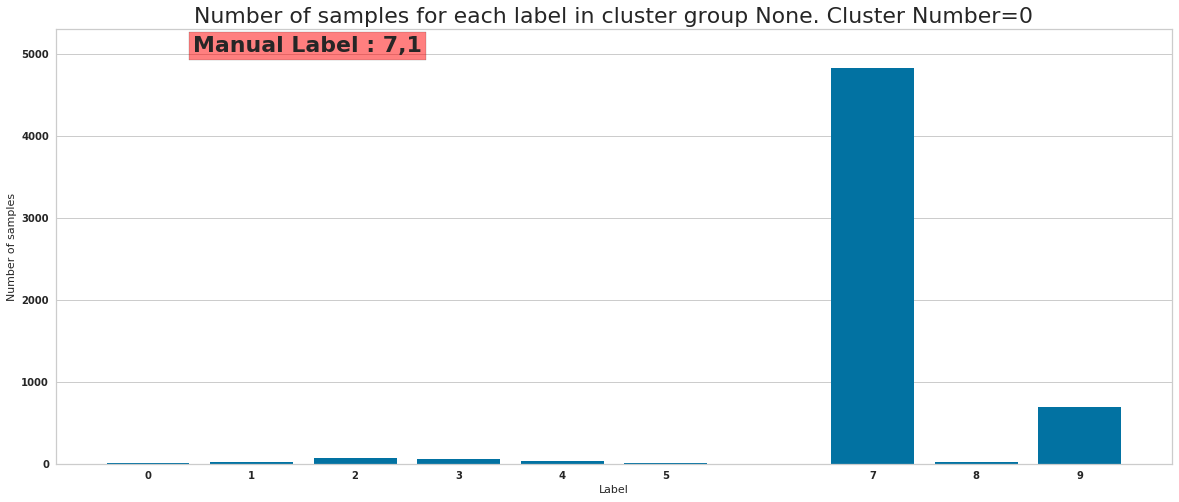

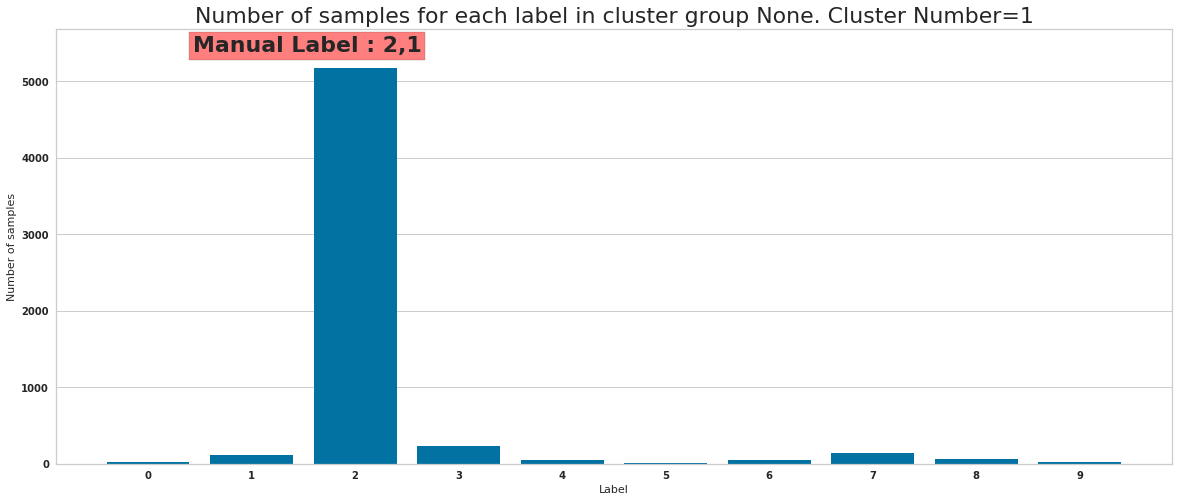

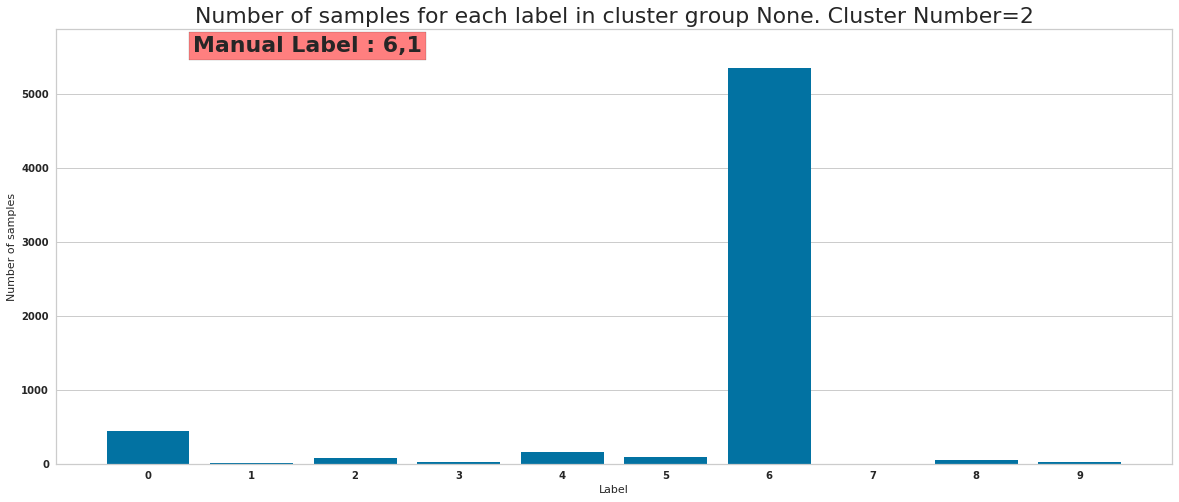

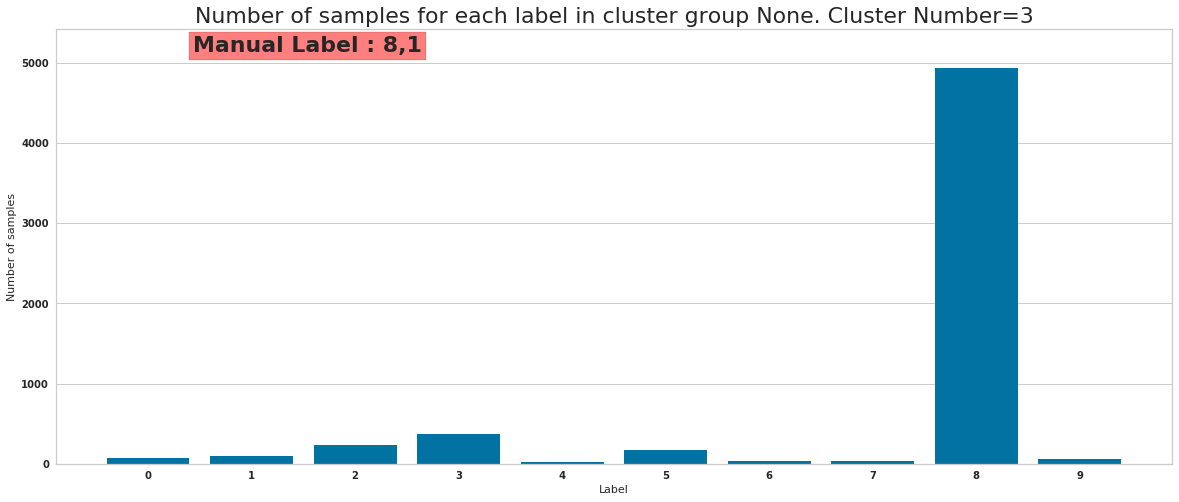

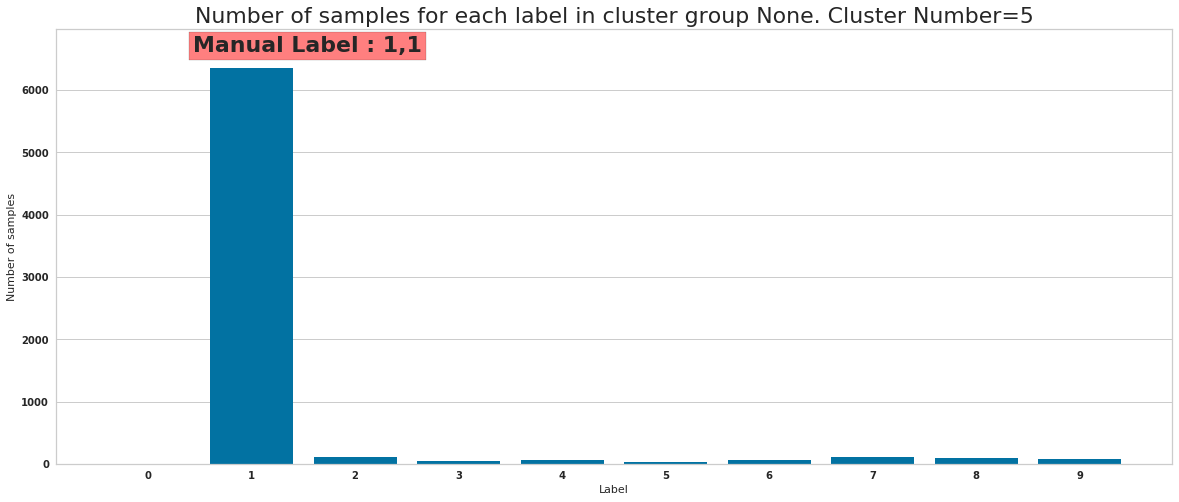

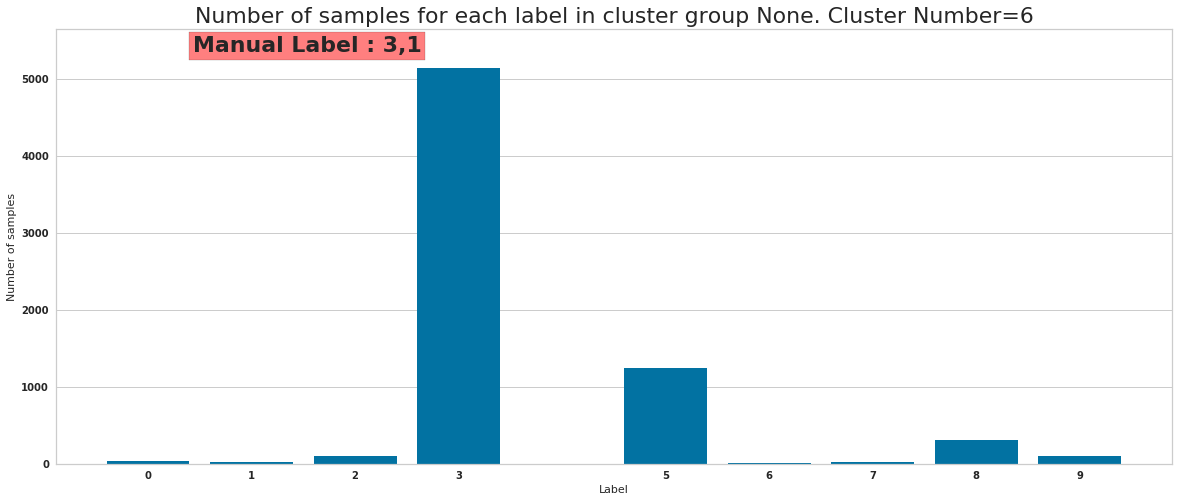

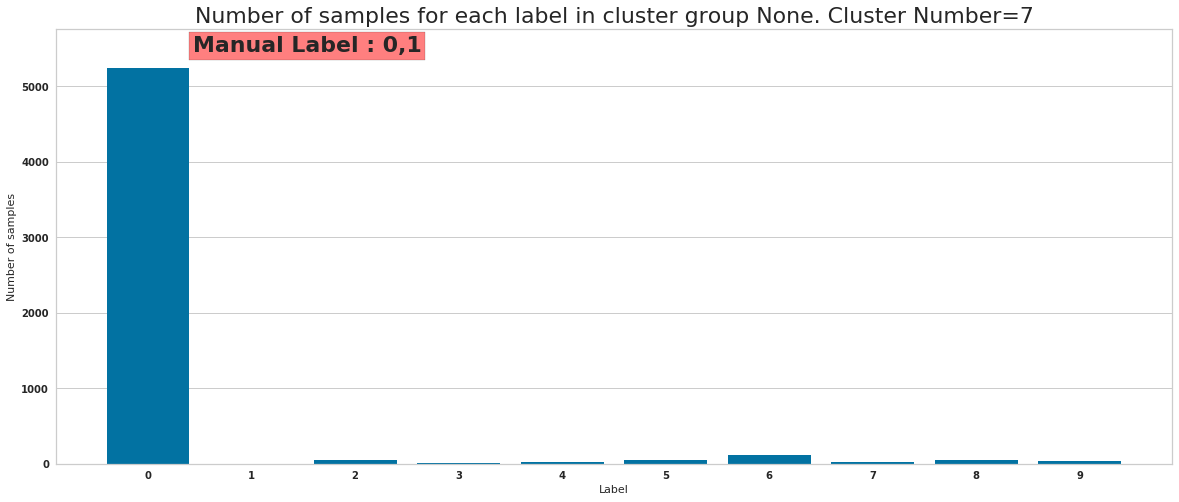

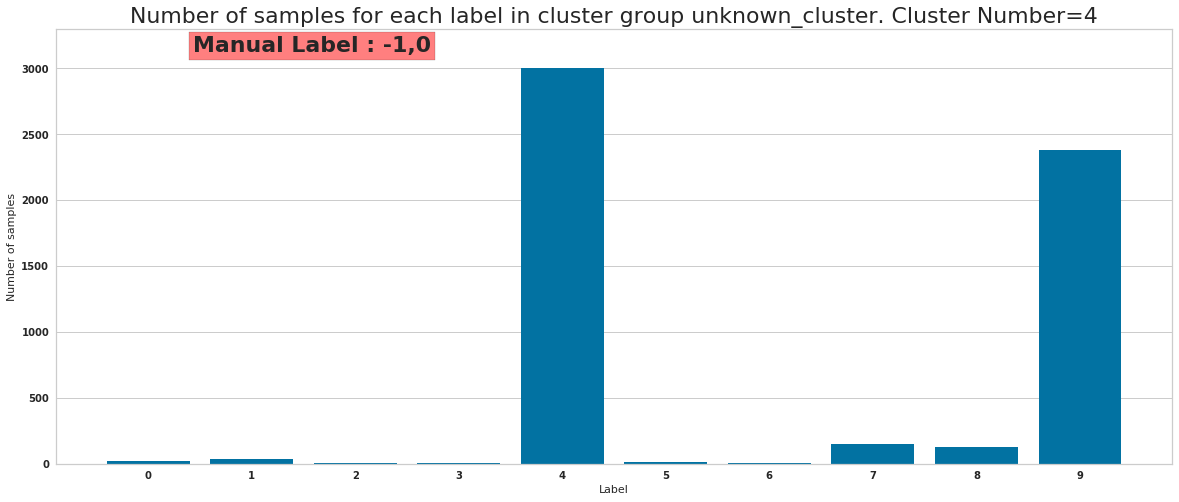

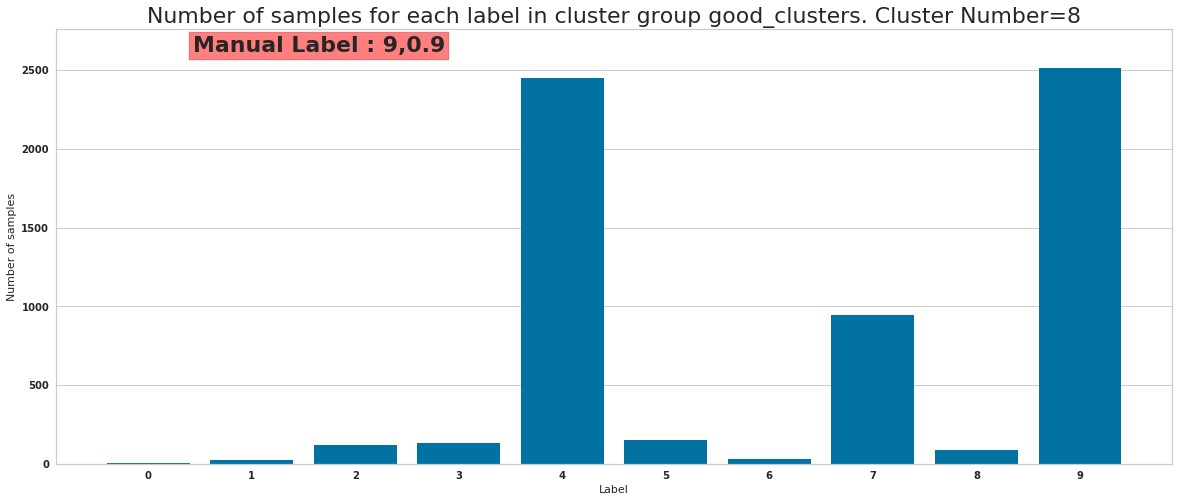

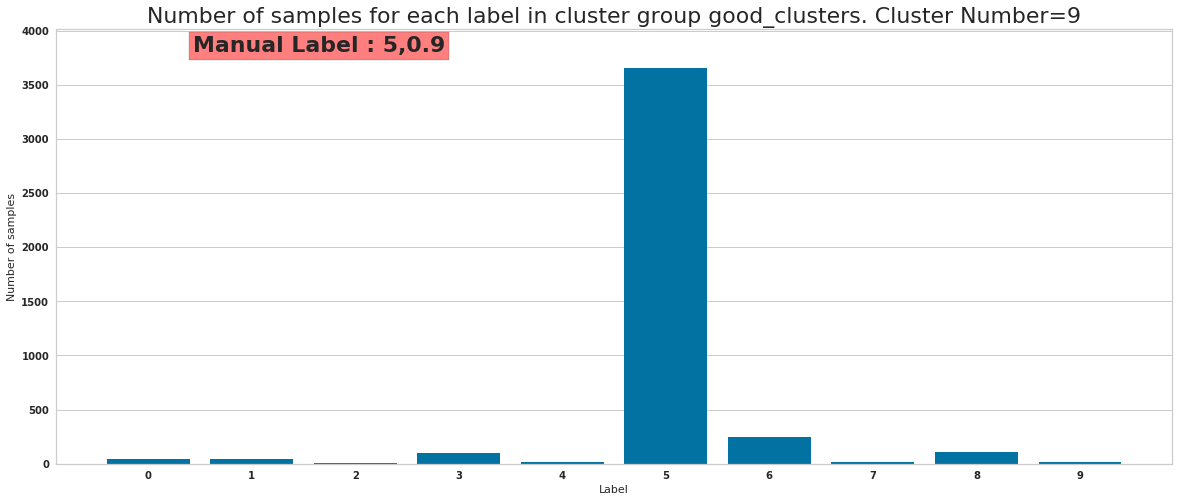

In [104]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7, 2, 6, 8,
                                           -1, 1, 3, 0,
                                           9, 5
                                          ]
manual_annotation_json["manual_confidence"] = [1 ,1, 1, 1,
                                               0, 1, 1, 1,
                                               0.9, 0.9
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )




(5727, 10)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(5883, 10)
(6257, 10)
(6031, 10)
(5737, 10)
(6917, 10)
(6977, 10)
(5608, 10)
(6454, 10)
(4249, 10)
4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
Reading checkpoints from /Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/ State model_checkpoint_path: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
all_model_checkpoint_paths: "/Users/sunilv/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_46/trained_models/SemiSupervisedClassifierMnist.model-5610"
 
ckpt_name SemiSupervisedClassifierMnist.model-5610
INFO:tensorflow

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


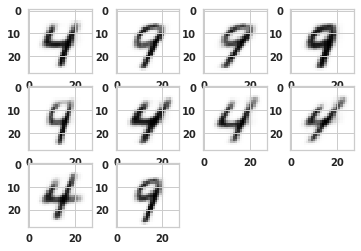

In [105]:
compute_distance(df, num_clusters, cluster_labels, z_col_names, cluster_centers)

df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [117]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [118]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


4
2
Skipping distance computation for unknown cluster
Manual Label 7
(4718, 54) (4718, 49)
Num correct=4536
Cluster 0 Manual Label 7 Percentage correct 96.14243323442136
********************************
Manual Label 2
(2847, 54) (2847, 49)
Num correct=2609
Cluster 1 Manual Label 2 Percentage correct 91.64032314717247
********************************
Manual Label 9
(5642, 54) (5642, 49)
Num correct=2549
Cluster 2 Manual Label 9 Percentage correct 45.17901453385324
********************************
Manual Label 0
(3158, 54) (3158, 49)
Num correct=2954
Cluster 3 Manual Label 0 Percentage correct 93.54021532615579
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 3
(3149, 54) (3149, 49)
Num correct=1646
Cluster 5 Manual Label 3 Percentage correct 52.270562083201014
********************************
Manual Label 8
(4202, 54) (4202, 49)
Num correct=2283
Cluster 6 Manual Label 8 Percentage correct 54.33127082341742
********

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

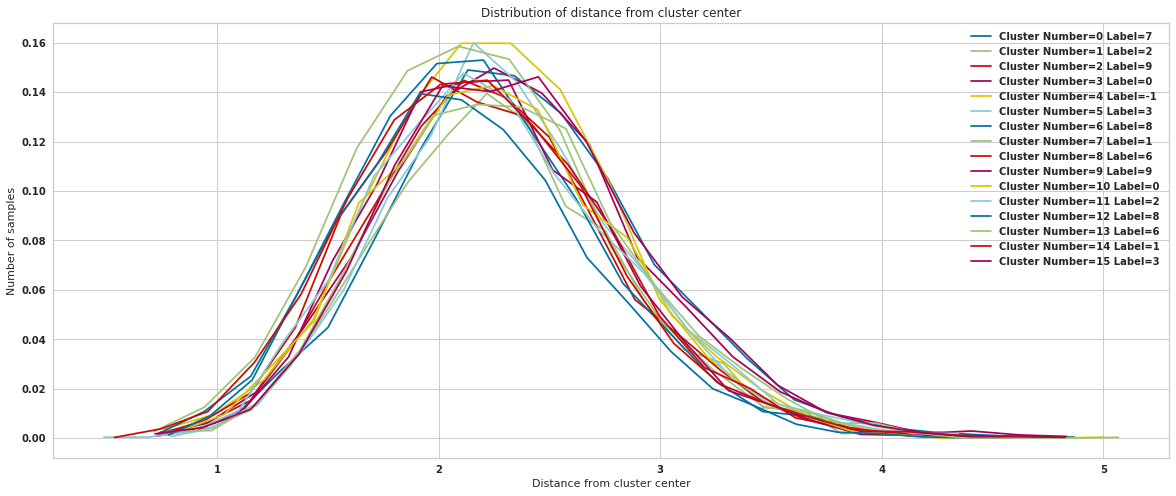

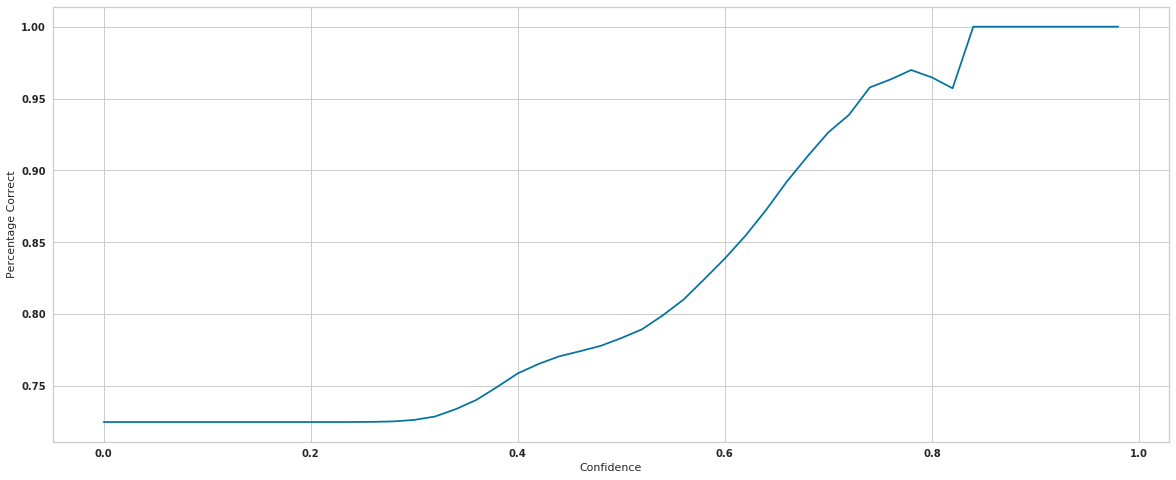

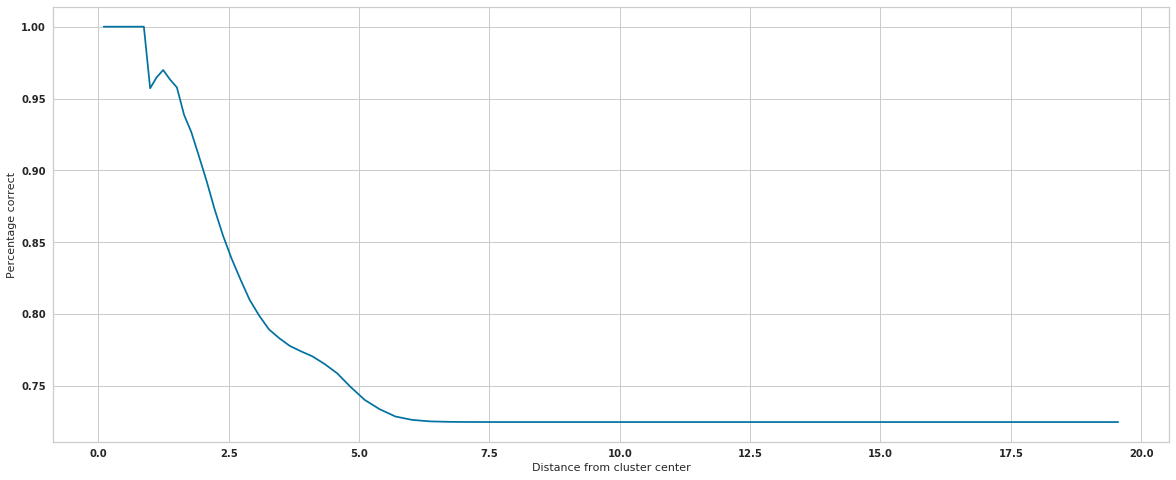

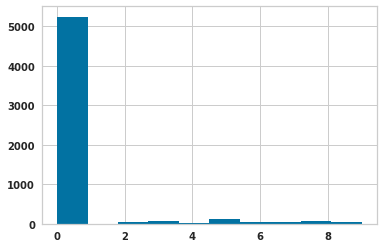

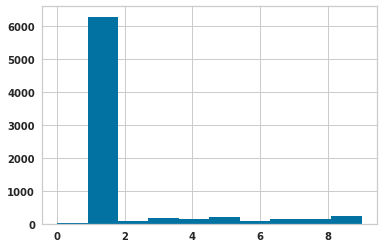

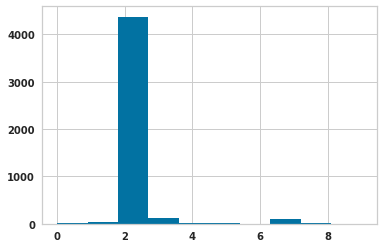

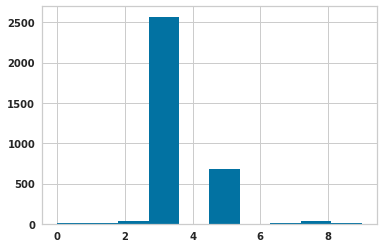

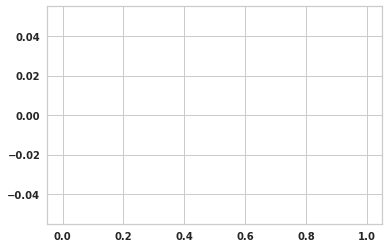

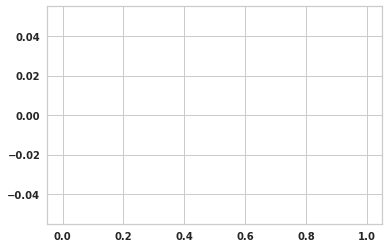

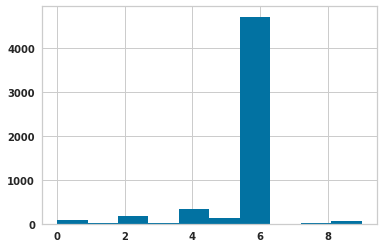

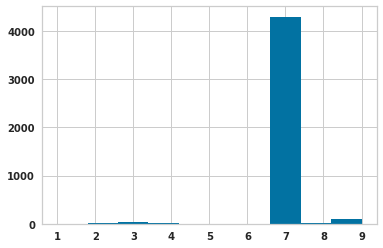

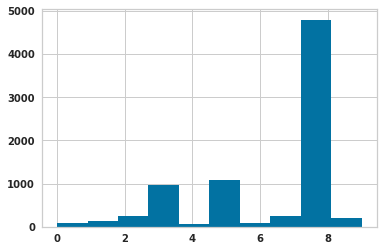

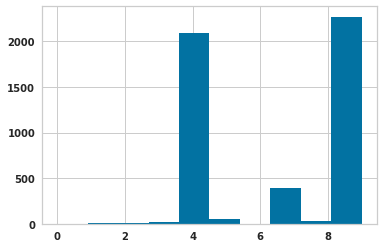

In [119]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [120]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56805
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:06 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS
Number of steps completed=6545
Number of epochs completed 7.0
run_id=2 z_min=-4.9489493 z_max=4.856212
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.

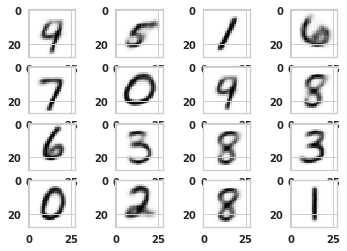

In [121]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


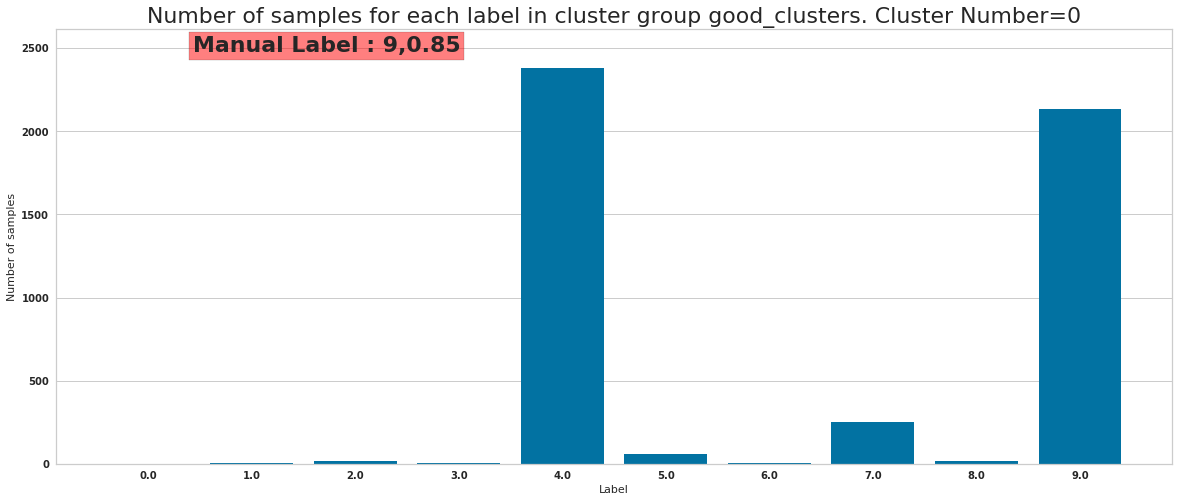

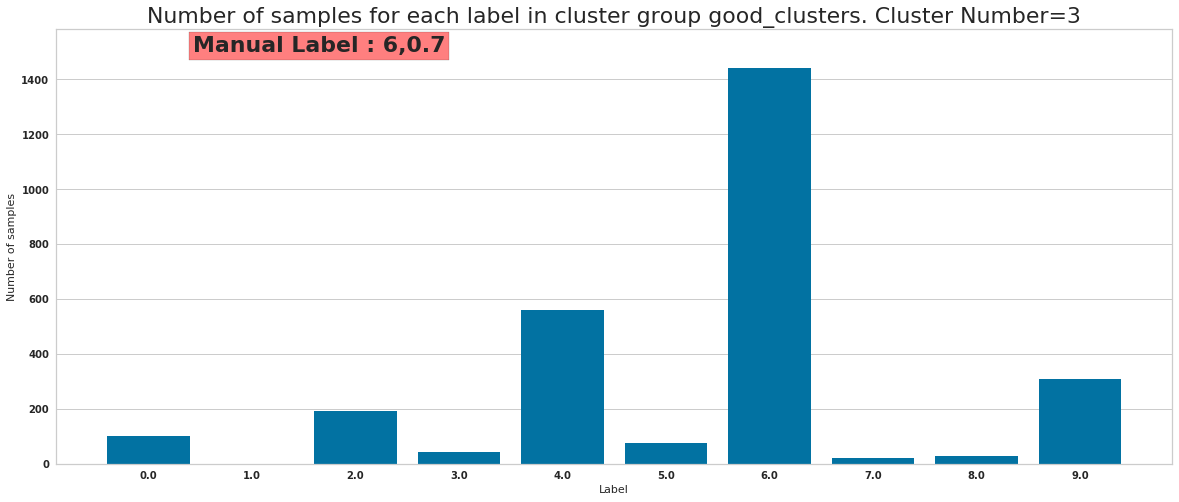

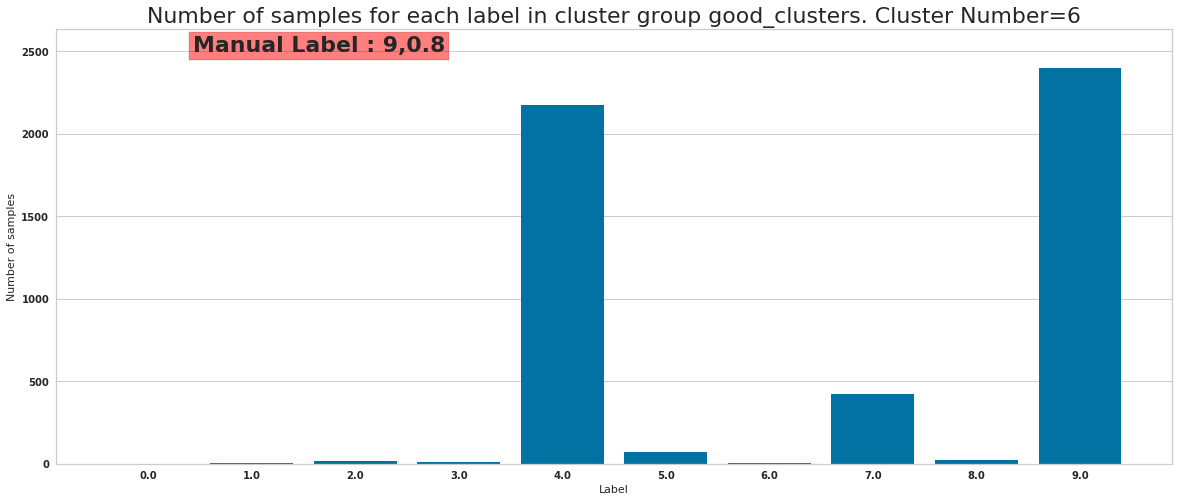

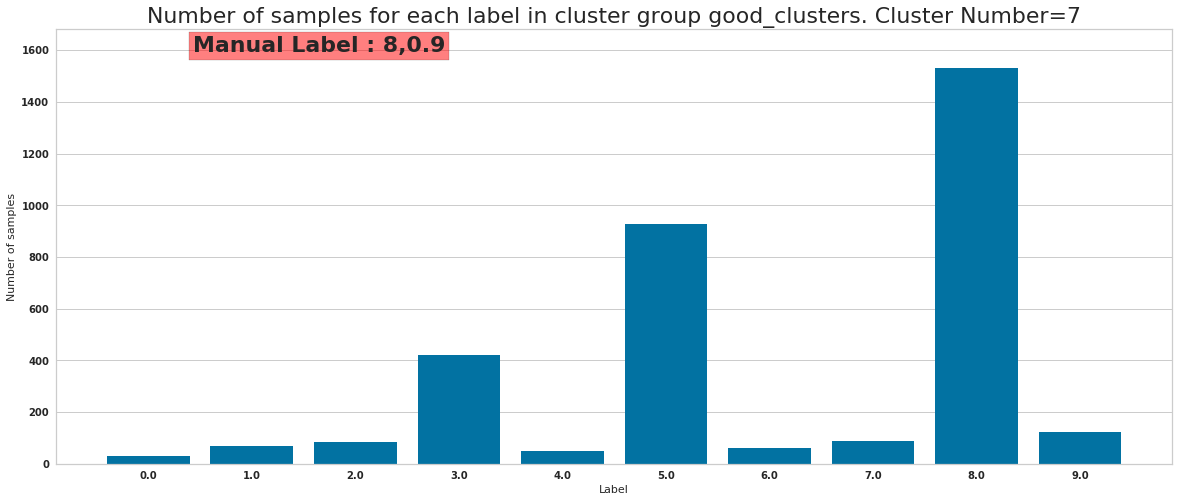

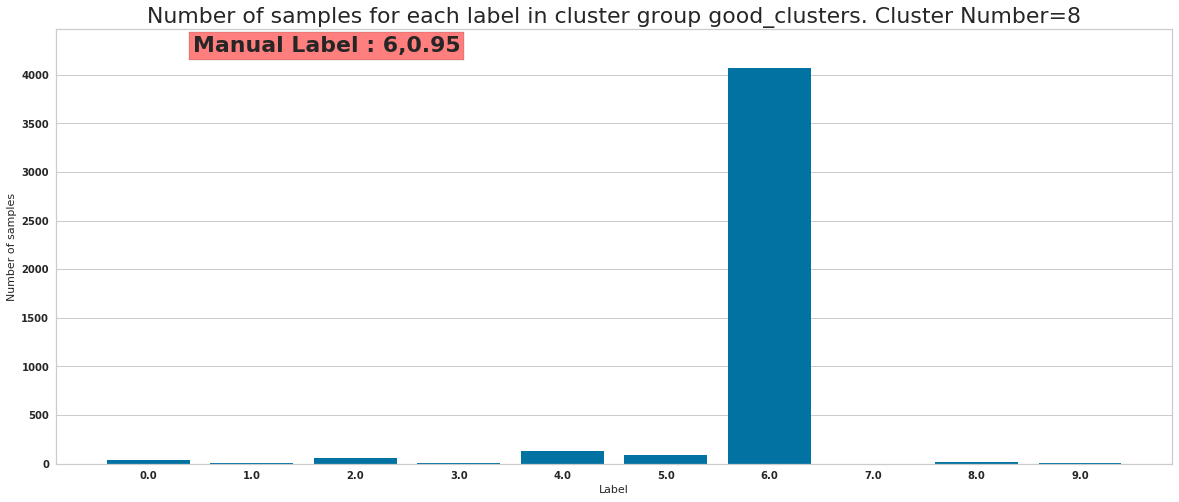

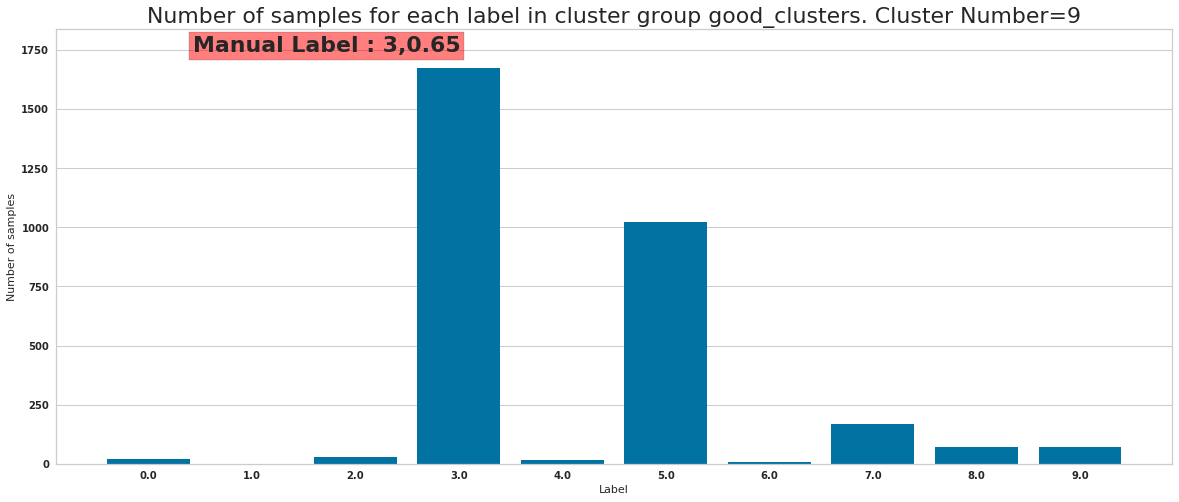

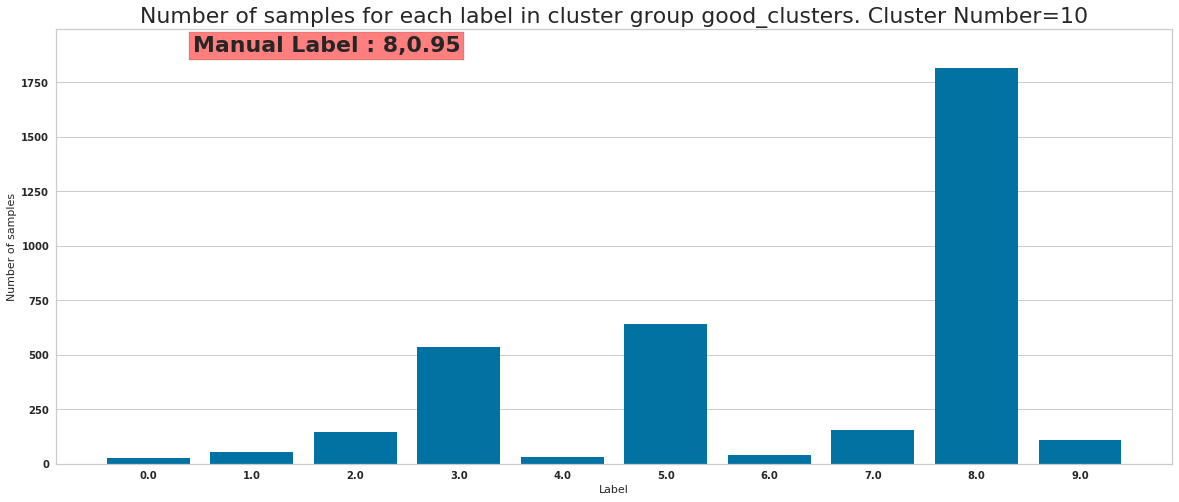

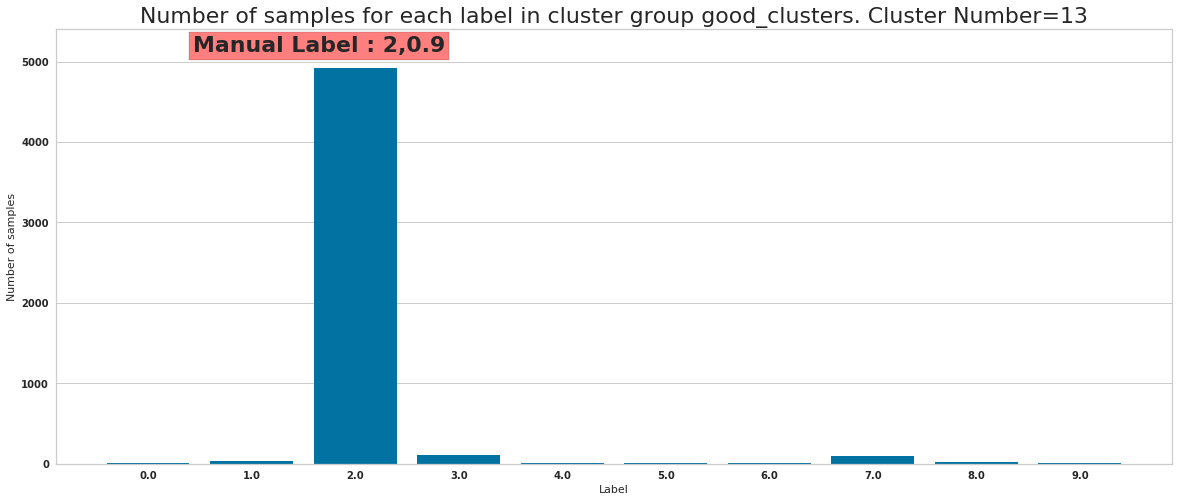

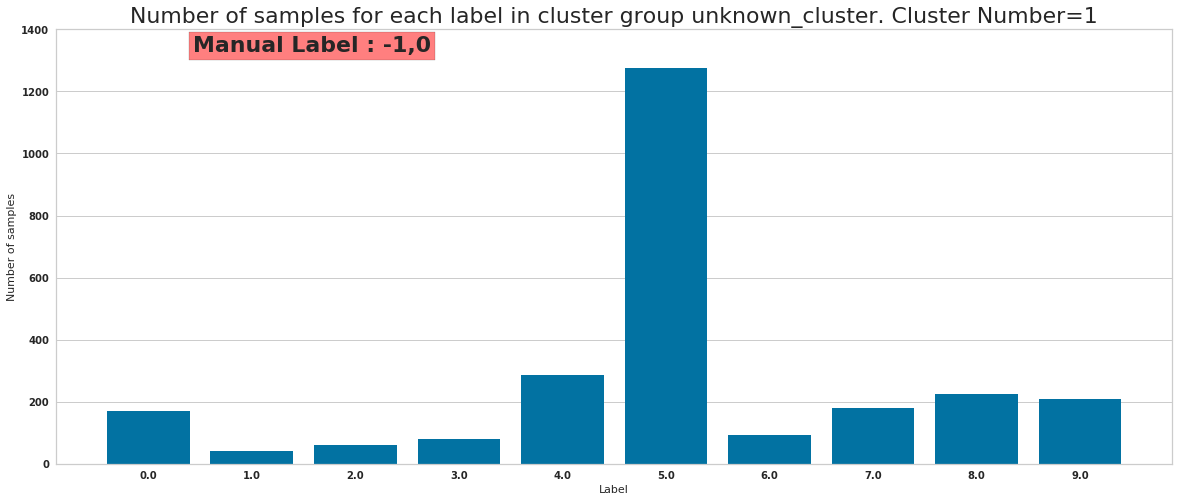

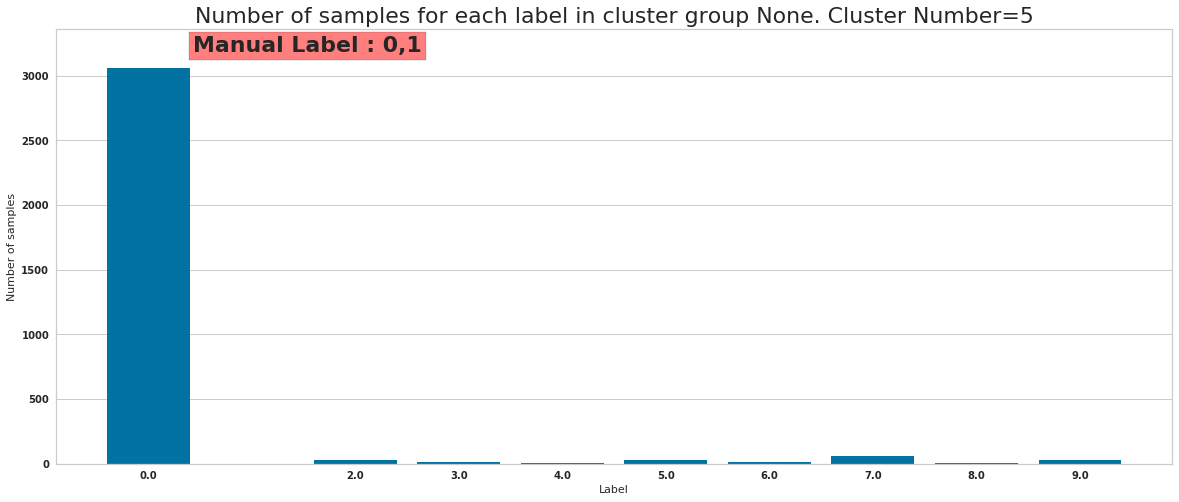

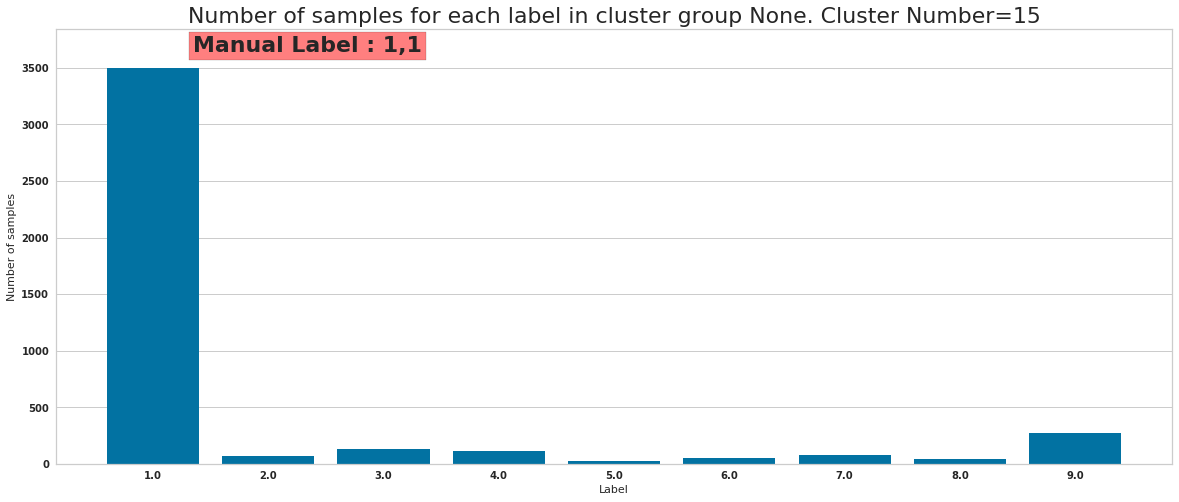

In [122]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,-1,1,6,
                                           7,0,9,8,
                                           6,3,8,3,
                                           0,2,8,1
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0,1,0.7,
                                               1,1,0.8,0.9,
                                               0.95,0.65,0.95,1,
                                               1,0.9,1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




In [123]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [124]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [125]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


1
2
Skipping distance computation for unknown cluster
Manual Label 9
(4878, 54) (4878, 32)
Num correct=2136
Cluster 0 Manual Label 9 Percentage correct 43.788437884378844
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 1
(3259, 54) (3259, 32)
Num correct=2902
Cluster 2 Manual Label 1 Percentage correct 89.04571954587297
********************************
Manual Label 6
(2766, 54) (2766, 32)
Num correct=1440
Cluster 3 Manual Label 6 Percentage correct 52.060737527114966
********************************
Manual Label 7
(4614, 54) (4614, 32)
Num correct=4453
Cluster 4 Manual Label 7 Percentage correct 96.51061985262245
********************************
Manual Label 0
(3247, 54) (3247, 32)
Num correct=3056
Cluster 5 Manual Label 0 Percentage correct 94.11764705882354
********************************
Manual Label 9
(9998, 54) (5120, 32)
Num correct=4532
Cluster 6 Manual Label 9 Percentage correct 45.329065813162636
******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

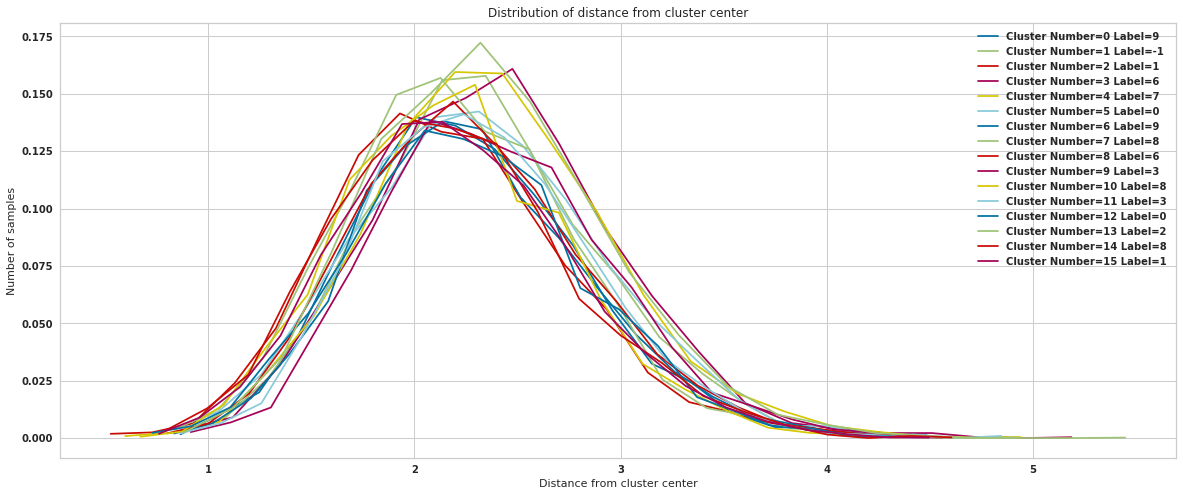

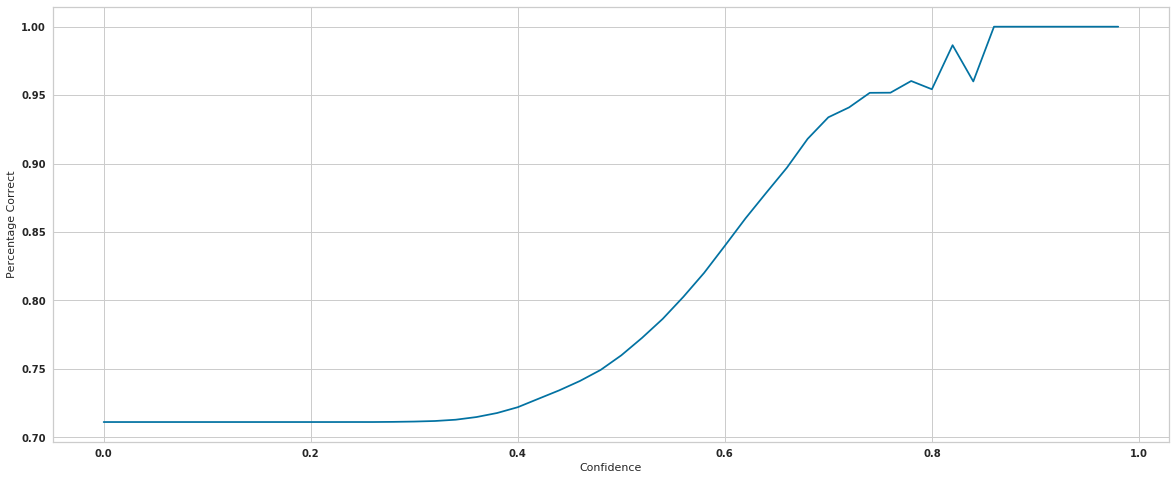

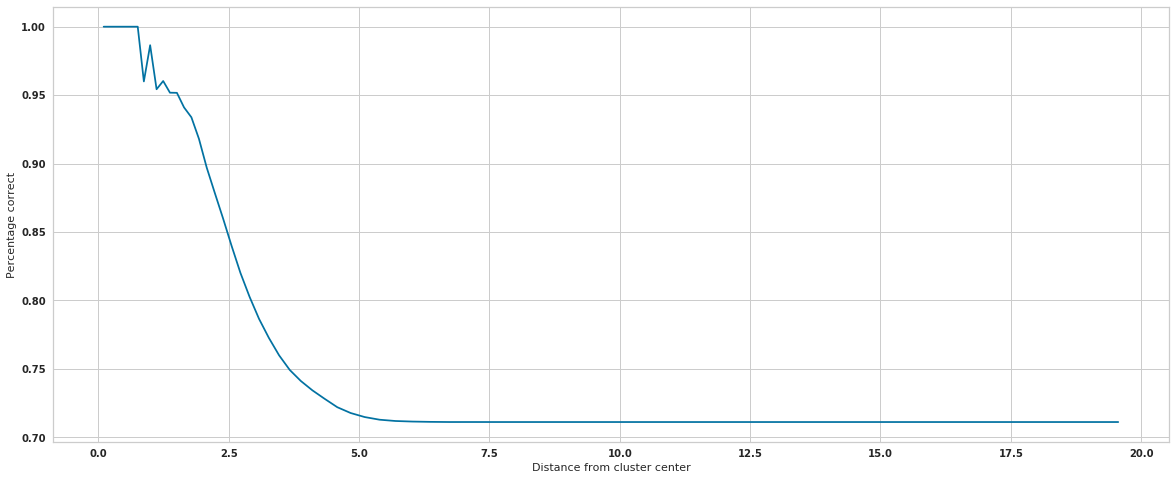

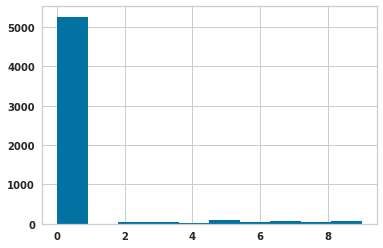

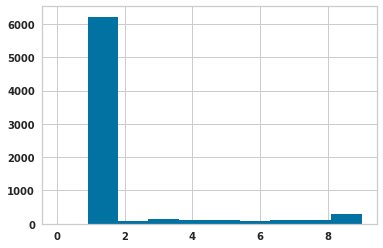

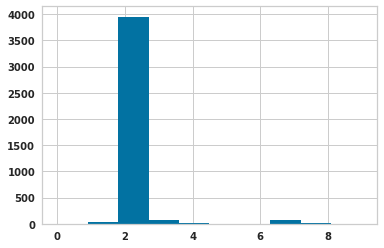

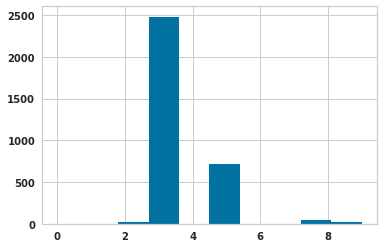

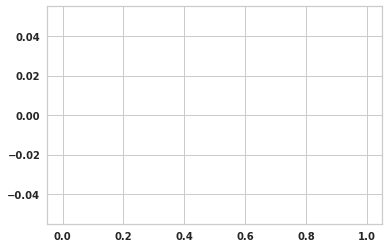

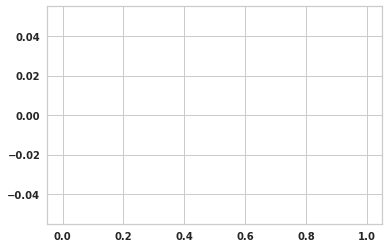

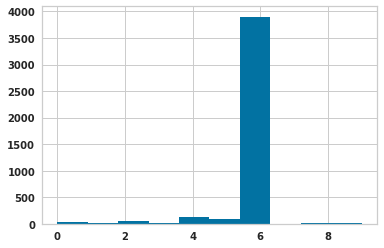

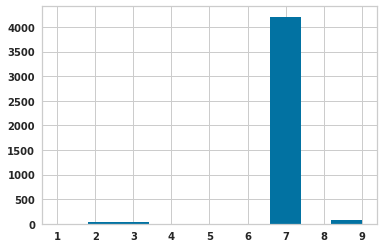

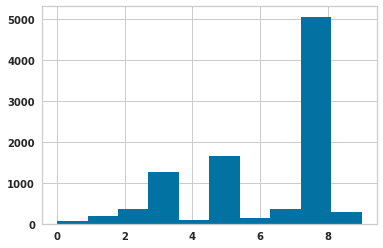

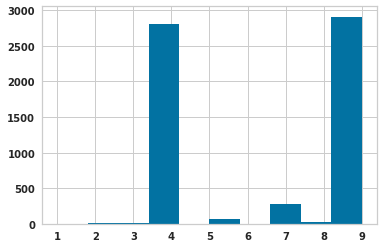

In [126]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [127]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 57217
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-7480
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-7480
 [*] Success to read ClassifierModel.model-7480
 [*] Load SUCCESS
Number of steps completed=7480
Number of epochs completed 8.0
run_id=2 z_min=-4.4770355 z_max=4.1615150000000005
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergenc

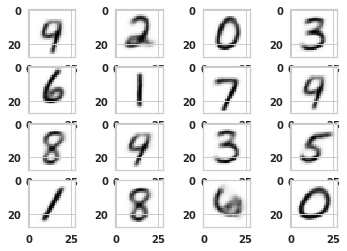

In [128]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


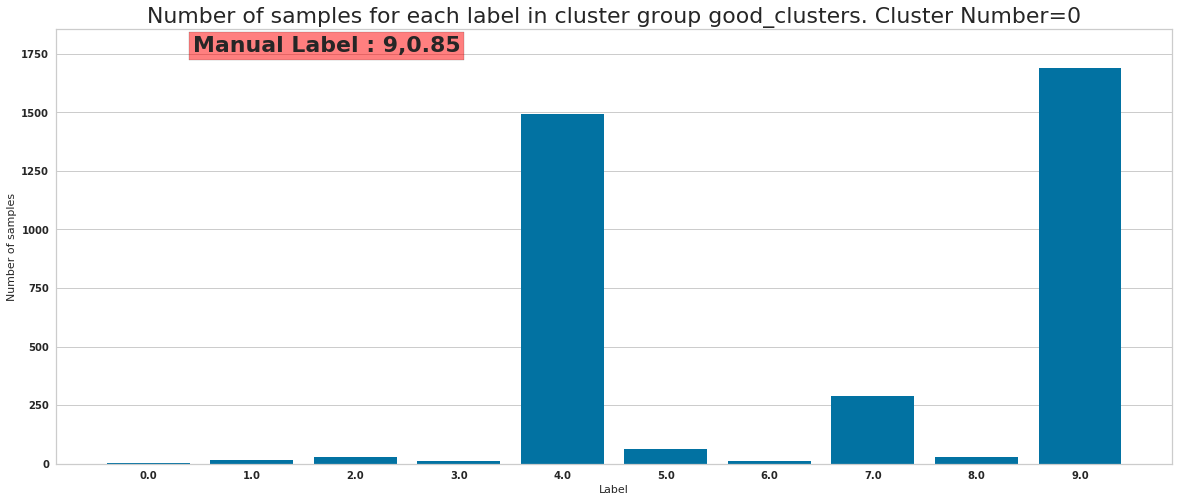

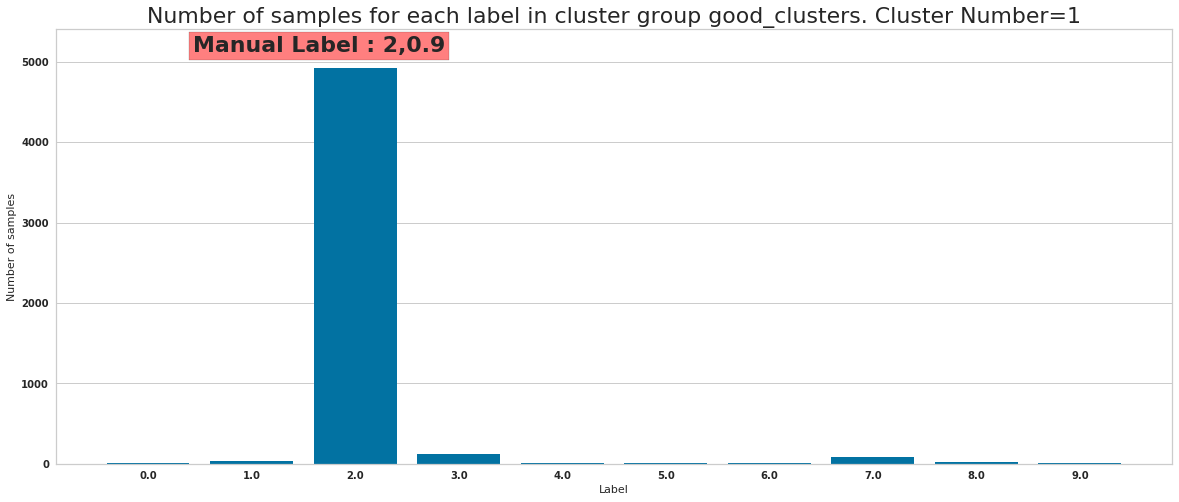

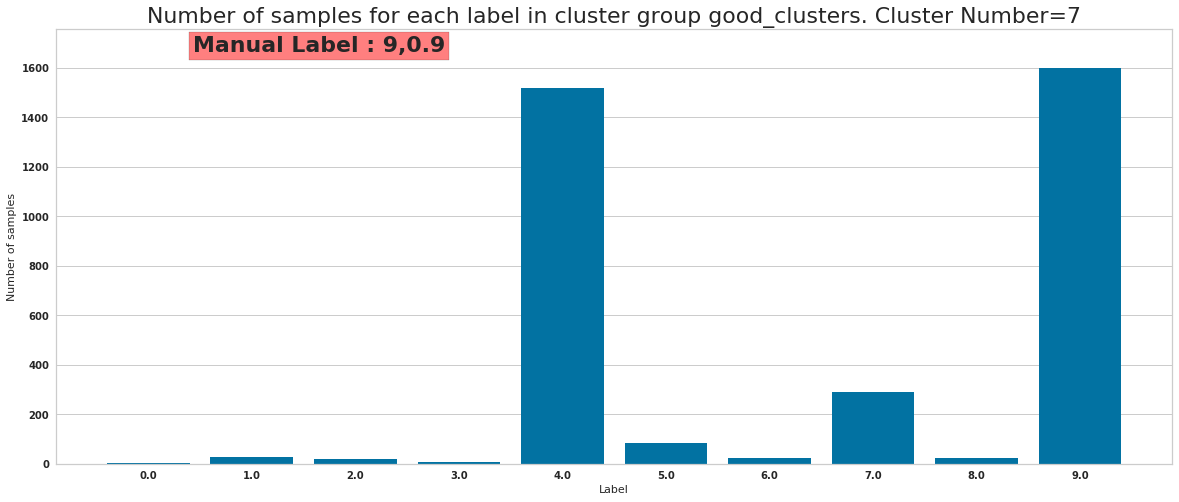

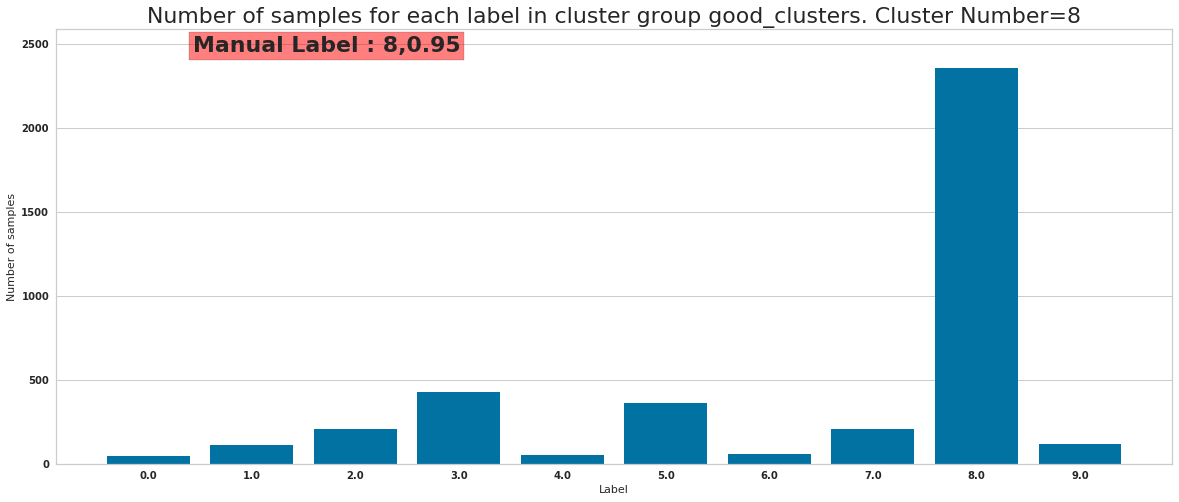

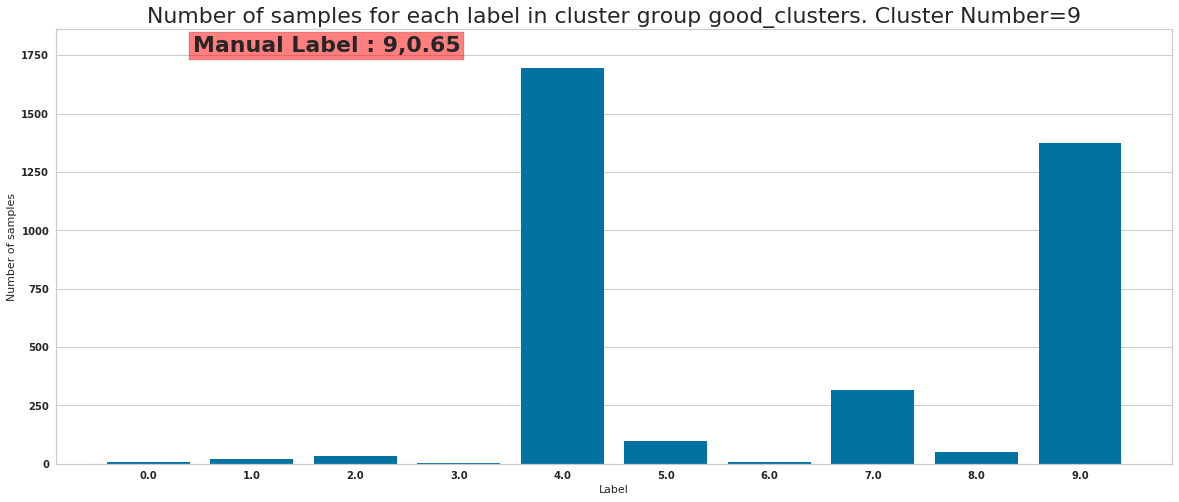

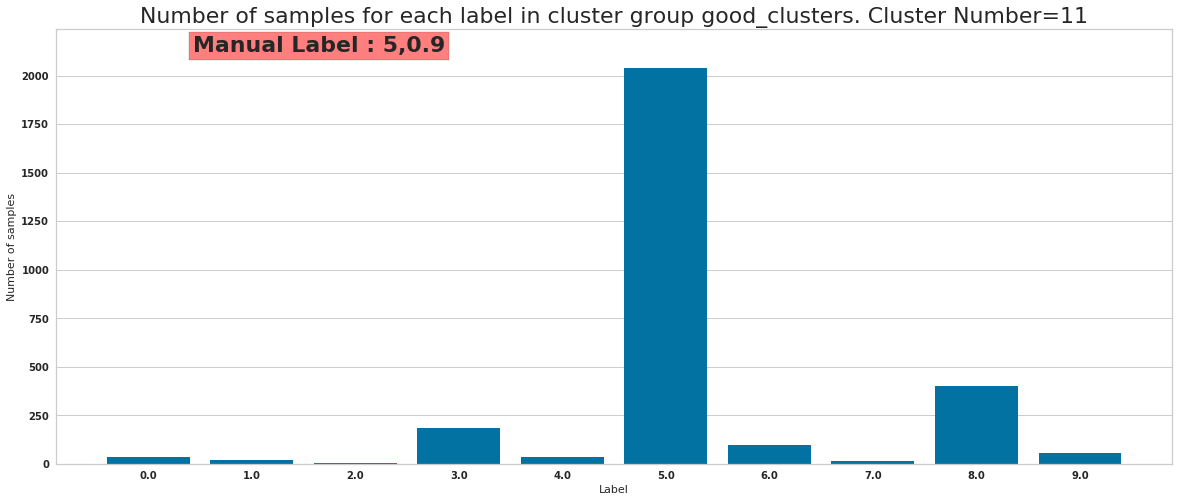

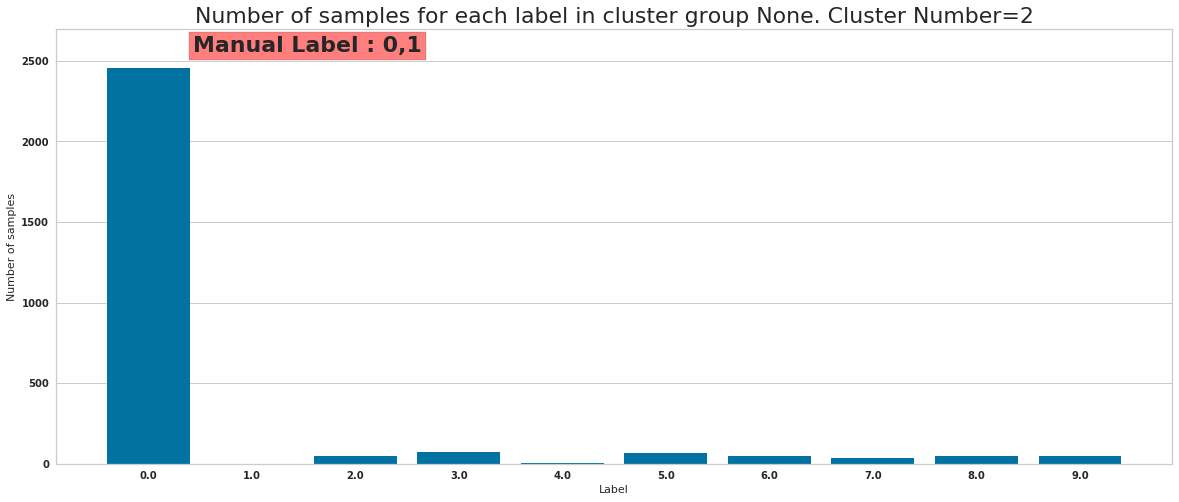

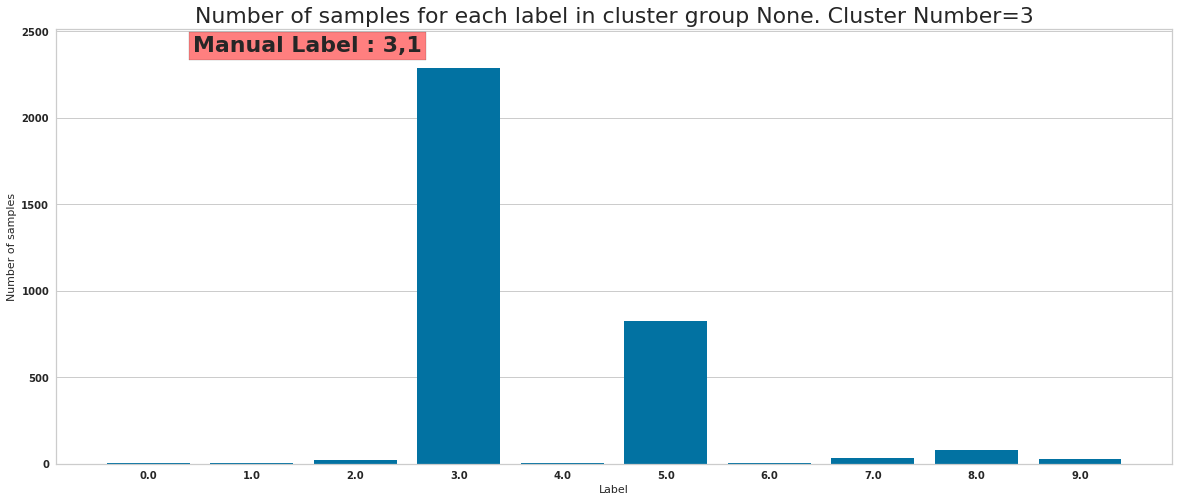

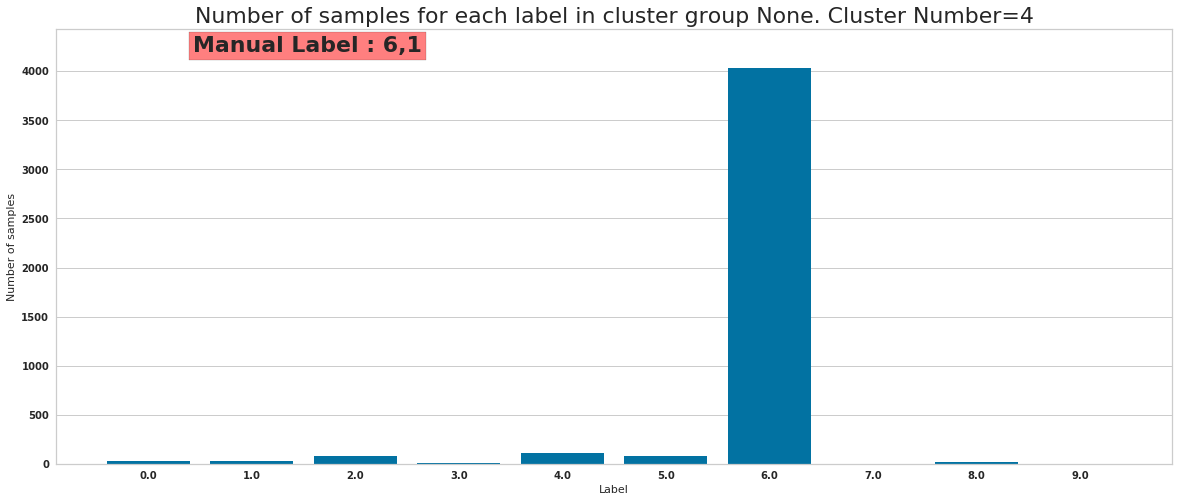

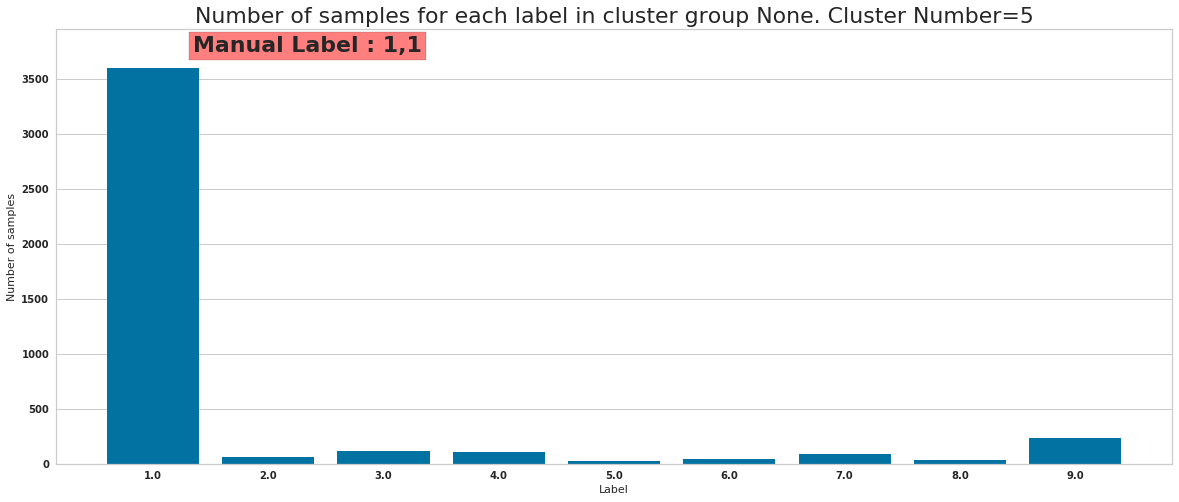

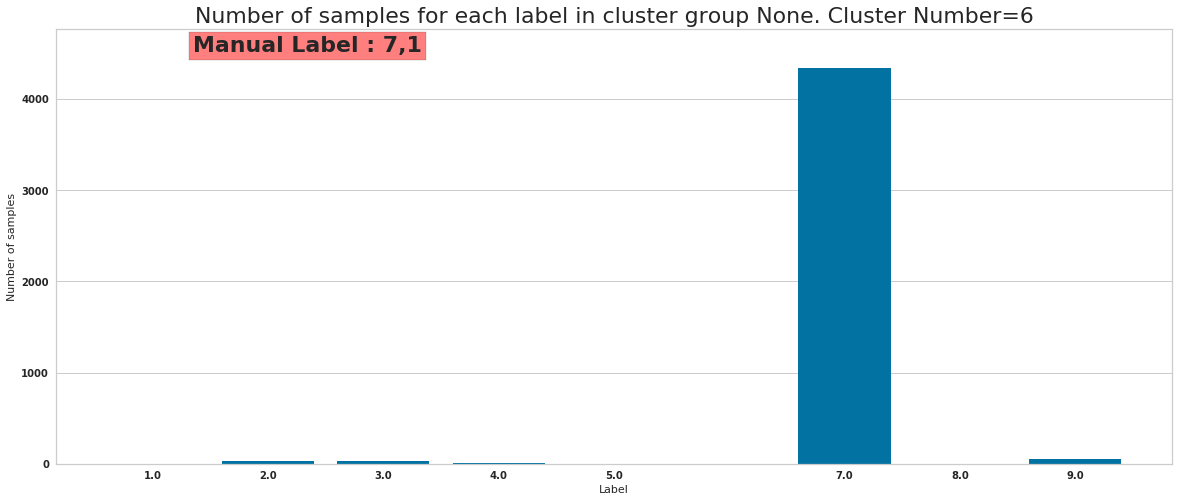

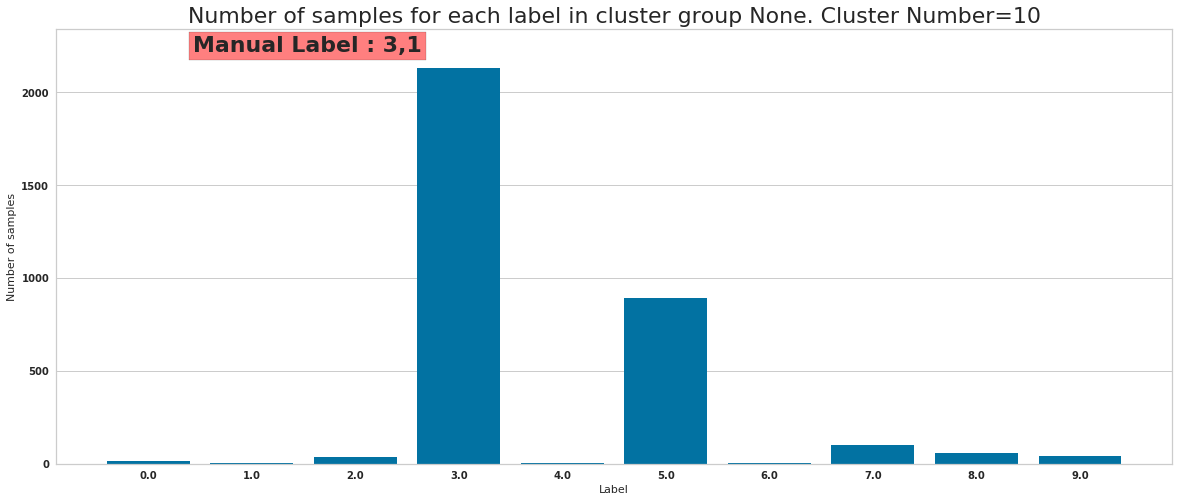

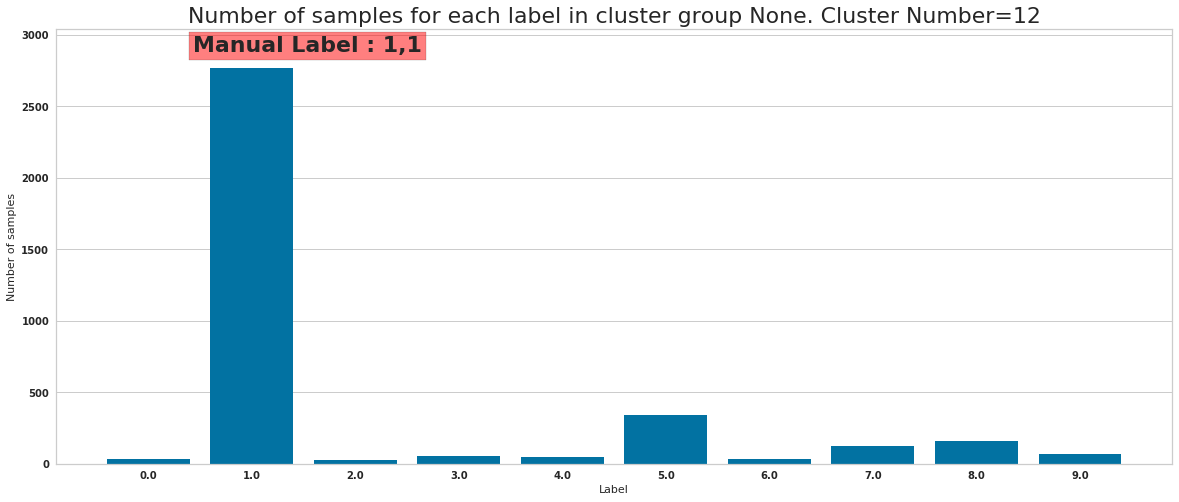

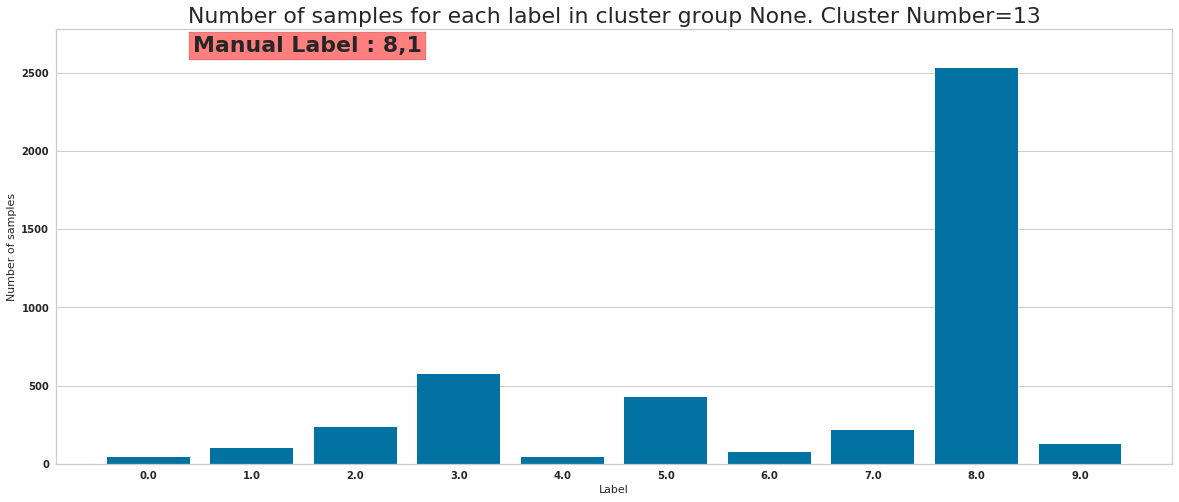

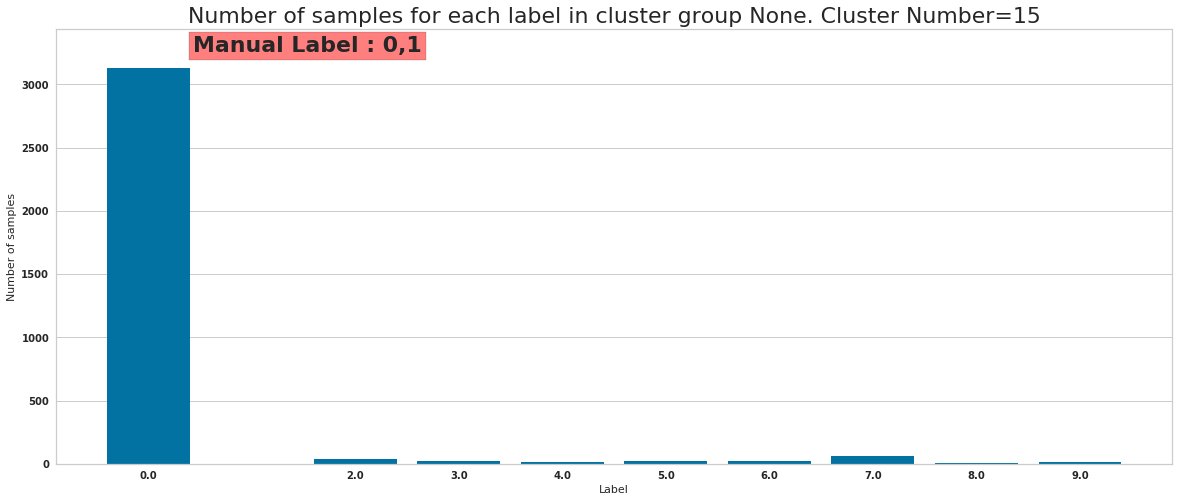

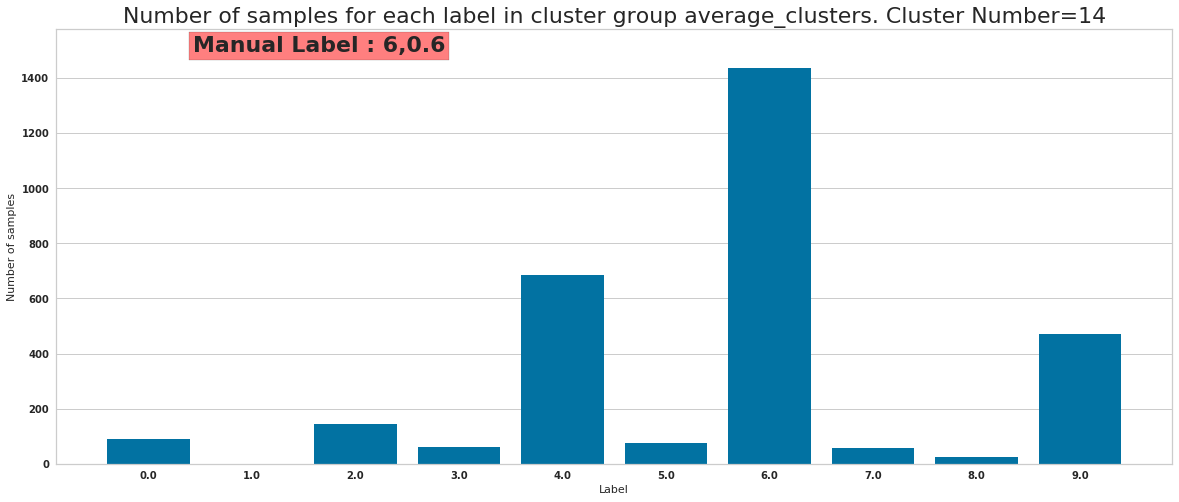

In [129]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,2,0,3,
                                           6,1,7,9,
                                           8,9,3,5,
                                           1,8,6,0
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0.9,1,1,
                                               1,1,1,0.9,
                                               0.95,0.65,1,0.9,
                                               1,1,0.6,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




In [130]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [131]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [132]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


Manual Label 9
(3640, 52) (3640, 32)
Num correct=1687
Cluster 0 Manual Label 9 Percentage correct 46.34615384615385
********************************
Manual Label 2
(5220, 52) (5220, 32)
Num correct=4917
Cluster 1 Manual Label 2 Percentage correct 94.19540229885058
********************************
Manual Label 0
(2829, 52) (2829, 32)
Num correct=2452
Cluster 2 Manual Label 0 Percentage correct 86.67373630258042
********************************
Manual Label 3
(3291, 52) (3291, 32)
Num correct=2285
Cluster 3 Manual Label 3 Percentage correct 69.43178365238529
********************************
Manual Label 6
(4384, 52) (4384, 32)
Num correct=4028
Cluster 4 Manual Label 6 Percentage correct 91.87956204379562
********************************
Manual Label 1
(4299, 52) (4299, 32)
Num correct=3592
Cluster 5 Manual Label 1 Percentage correct 83.55431495696673
********************************
Manual Label 7
(4472, 52) (4472, 32)
Num correct=4336
Cluster 6 Manual Label 7 Percentage correct 96.95885

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

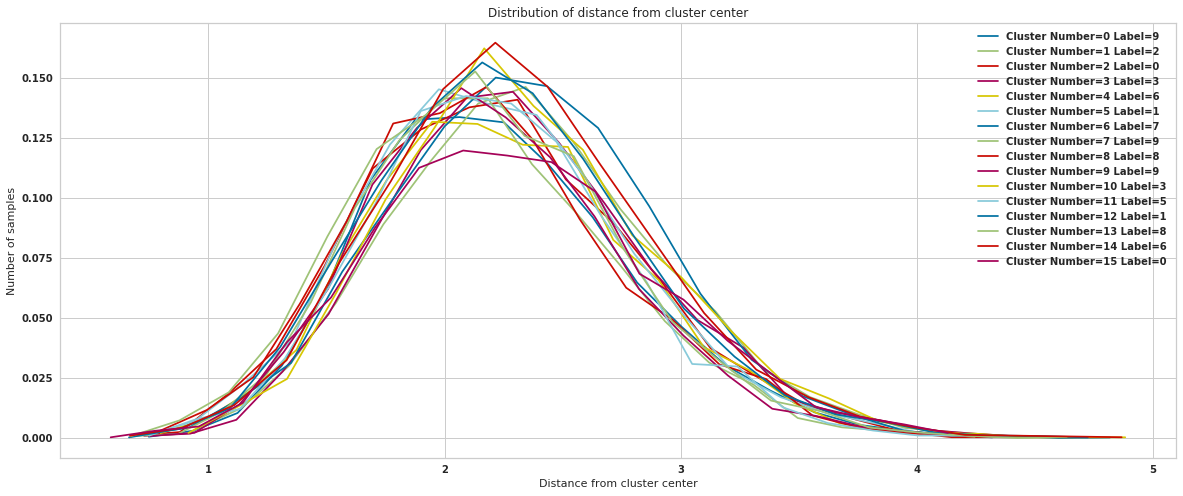

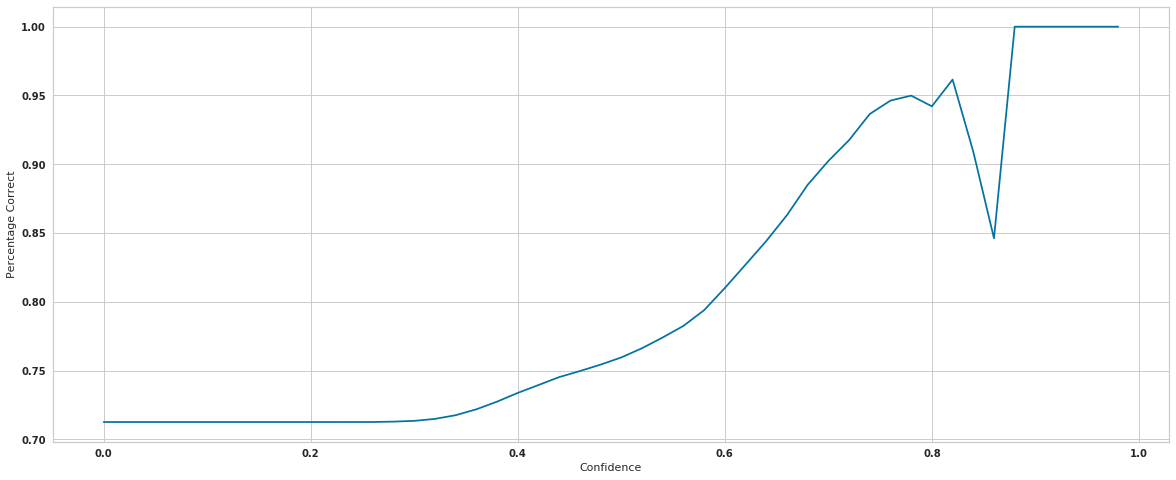

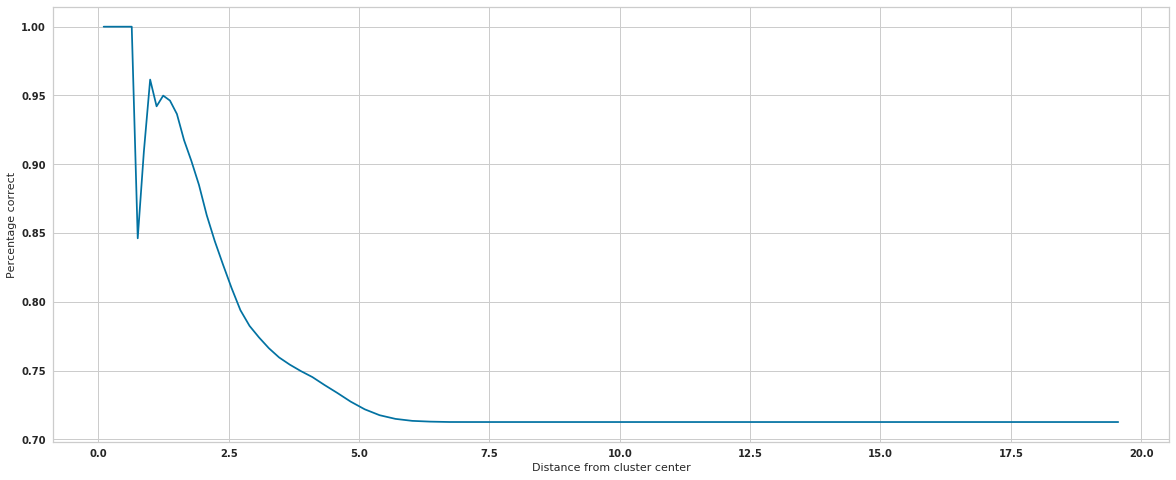

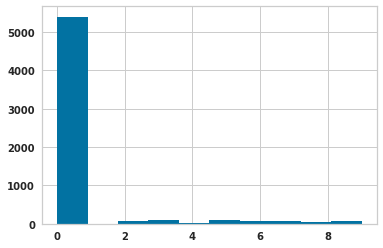

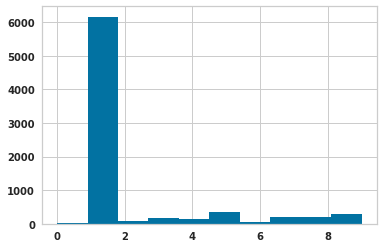

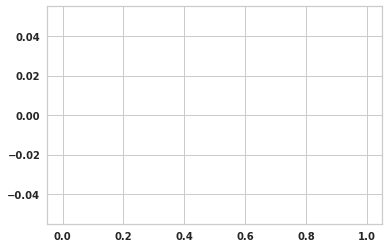

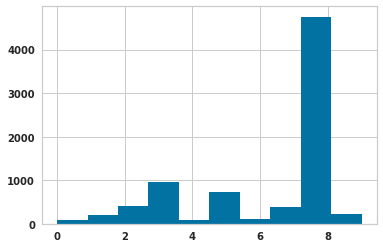

In [133]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [134]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 59840
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:08 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


In [135]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS
Number of steps completed=8415
Number of epochs completed 9.0
run_id=2 z_min=-4.340634 z_max=4.580414
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.


Getting manual_annotation


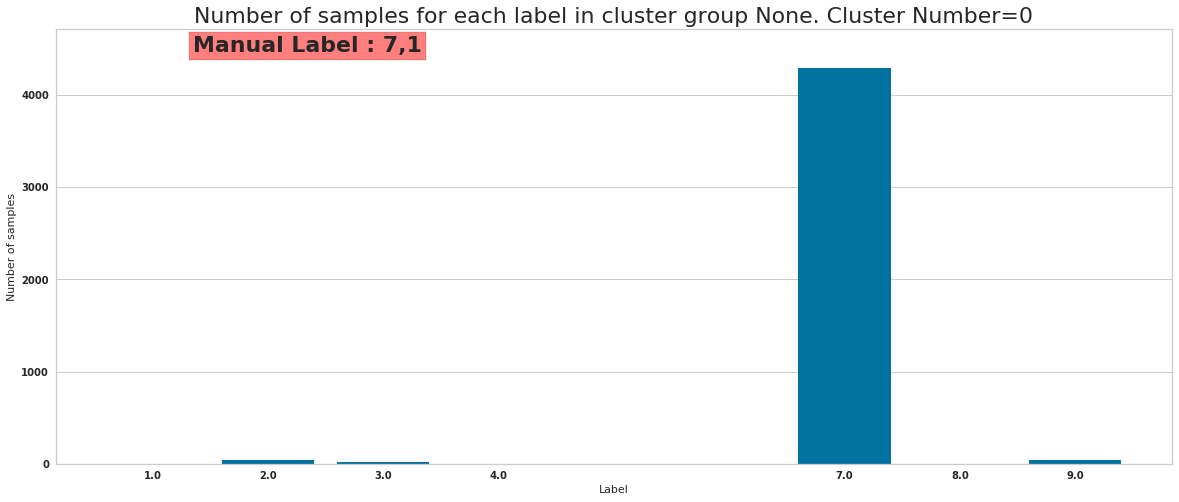

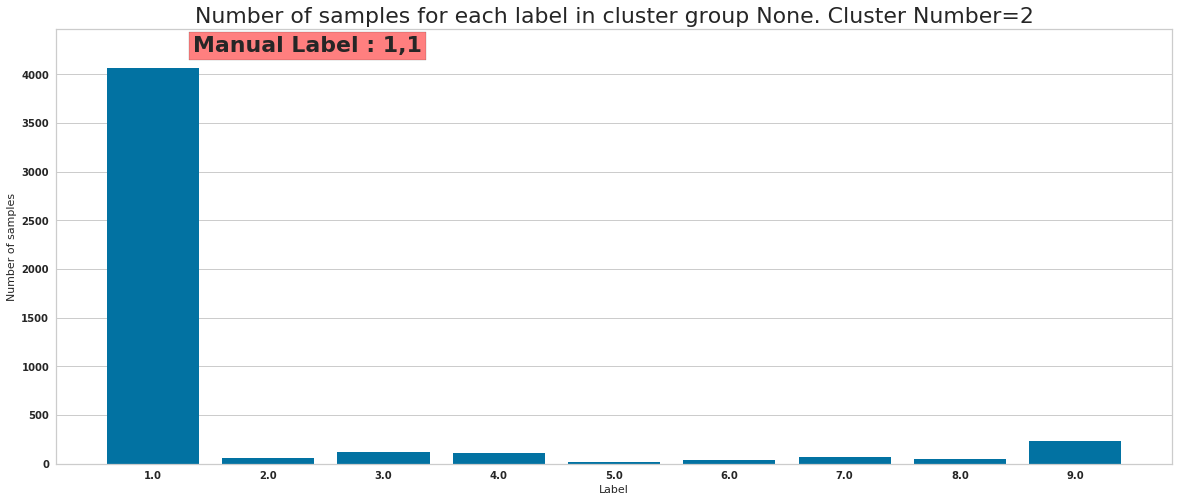

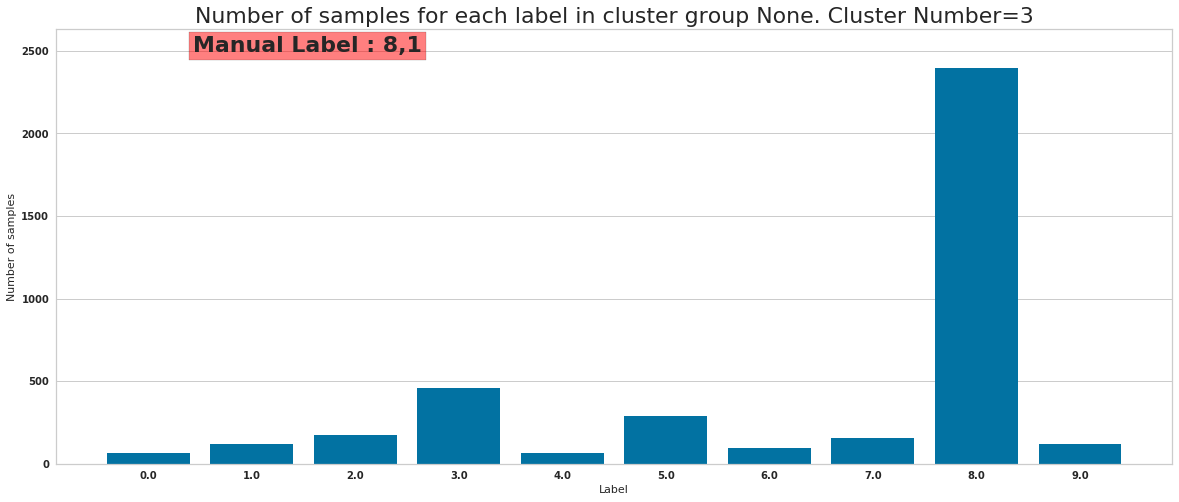

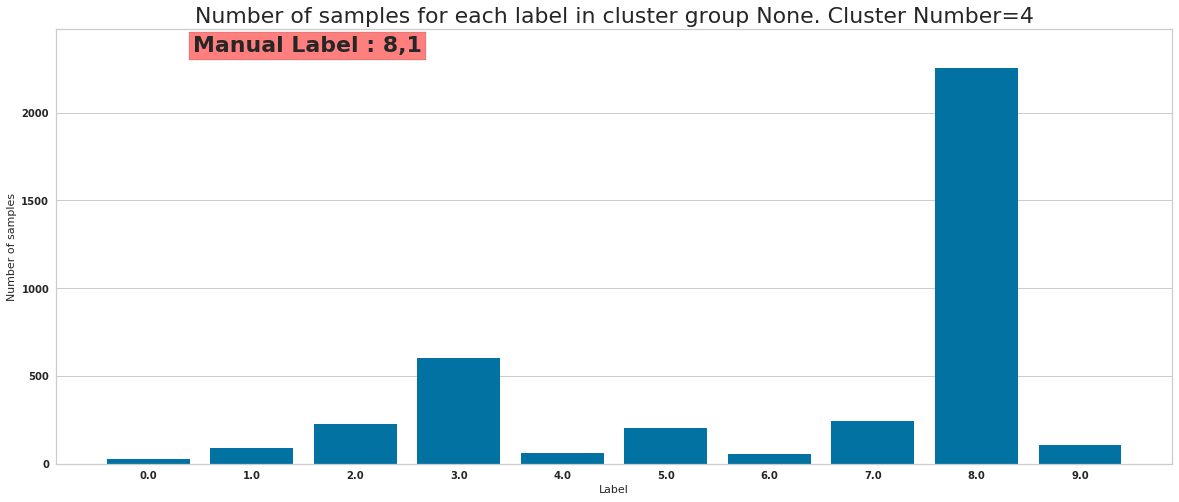

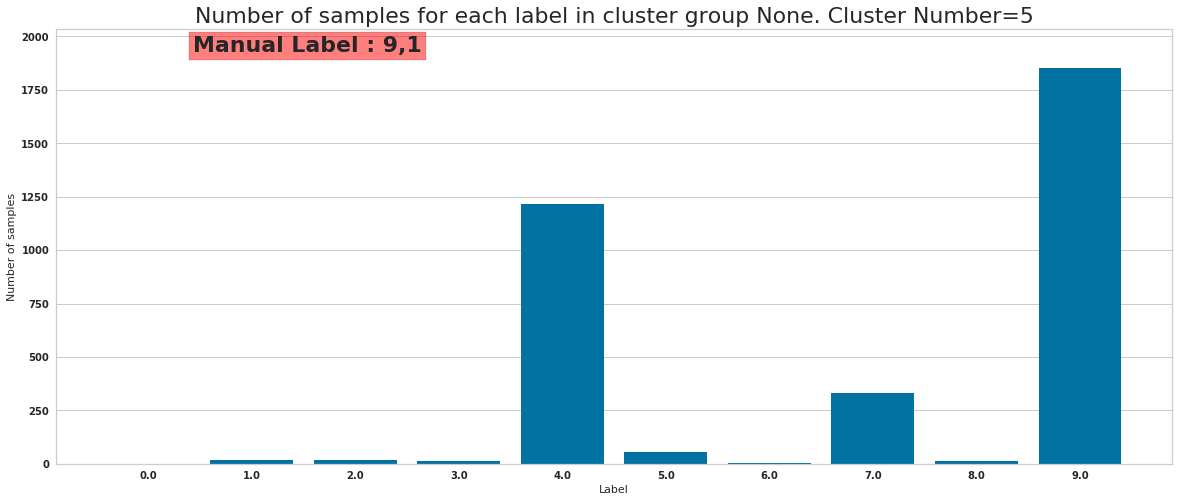

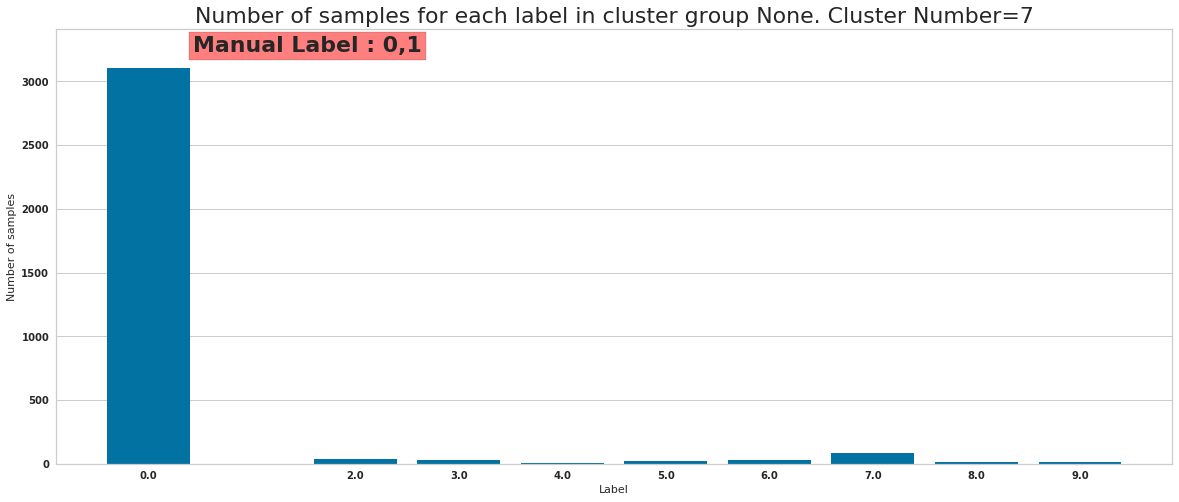

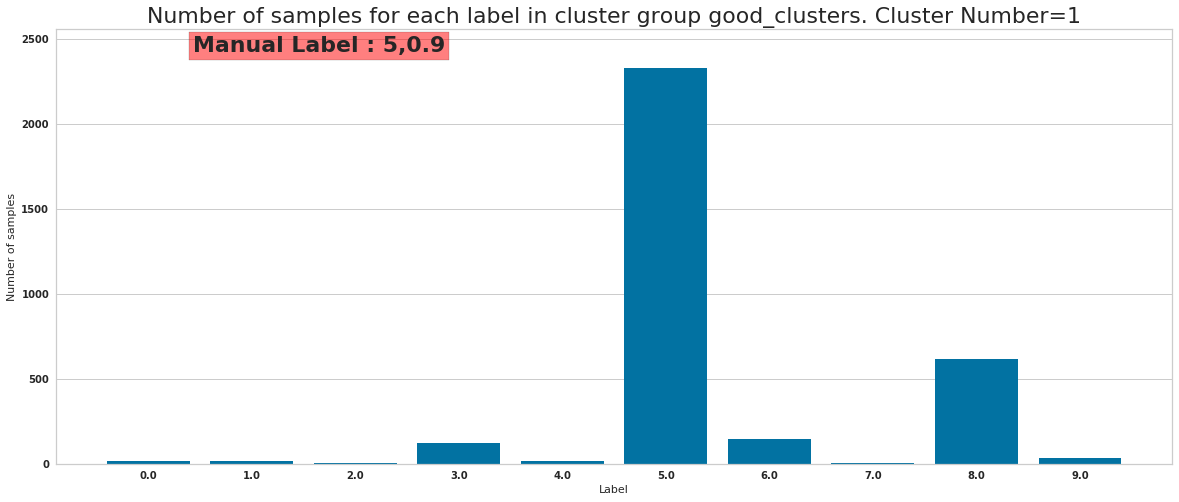

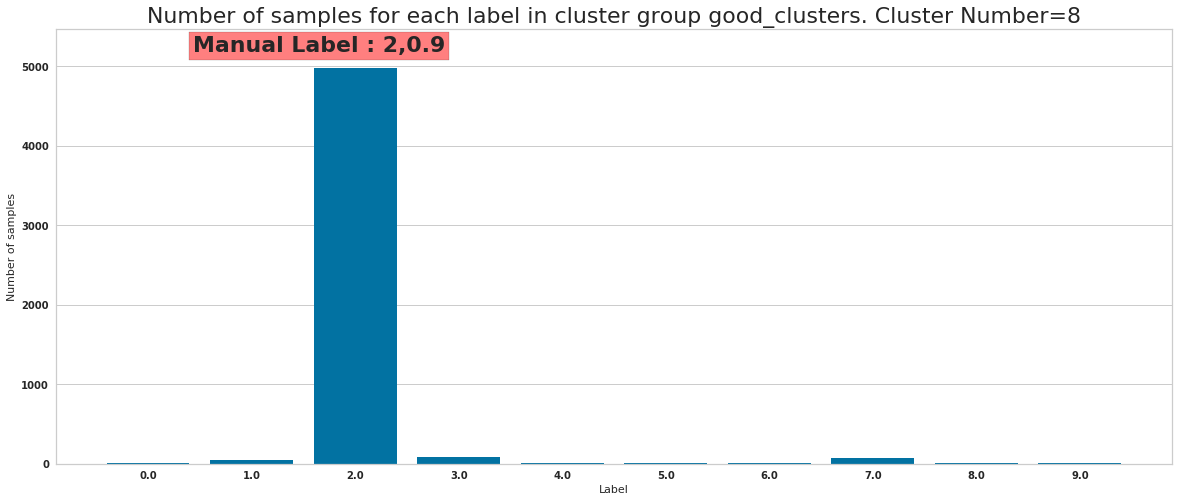

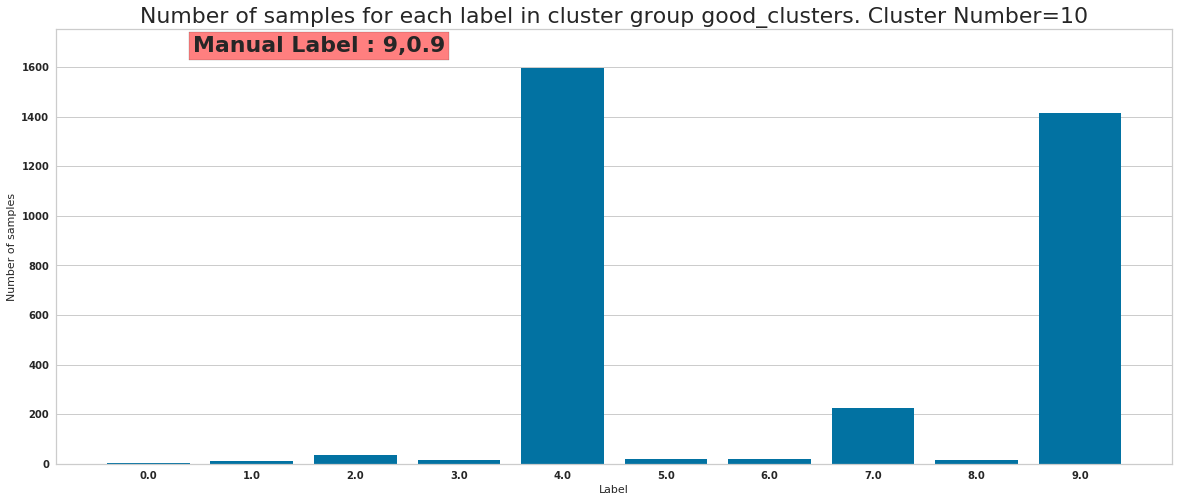

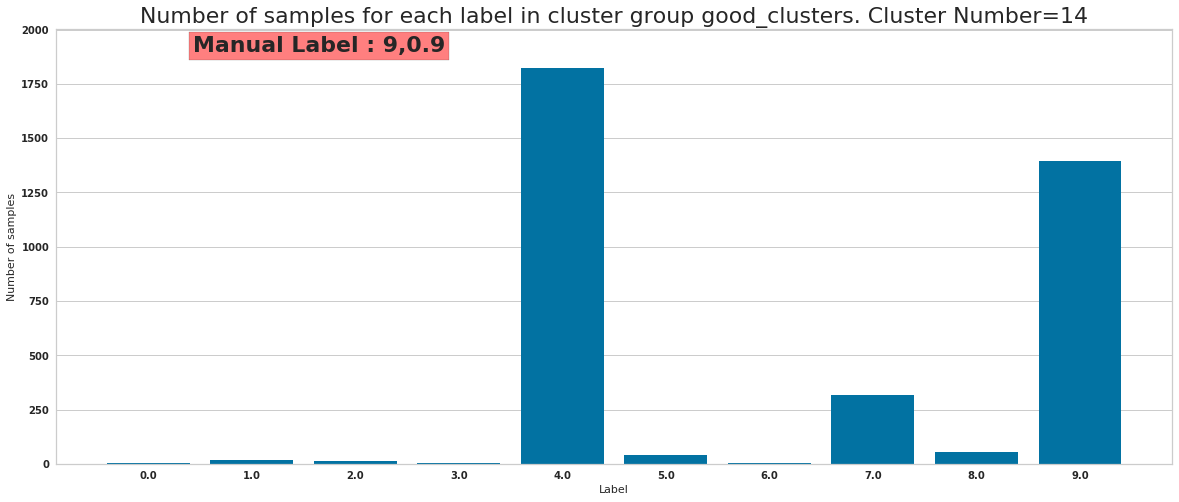

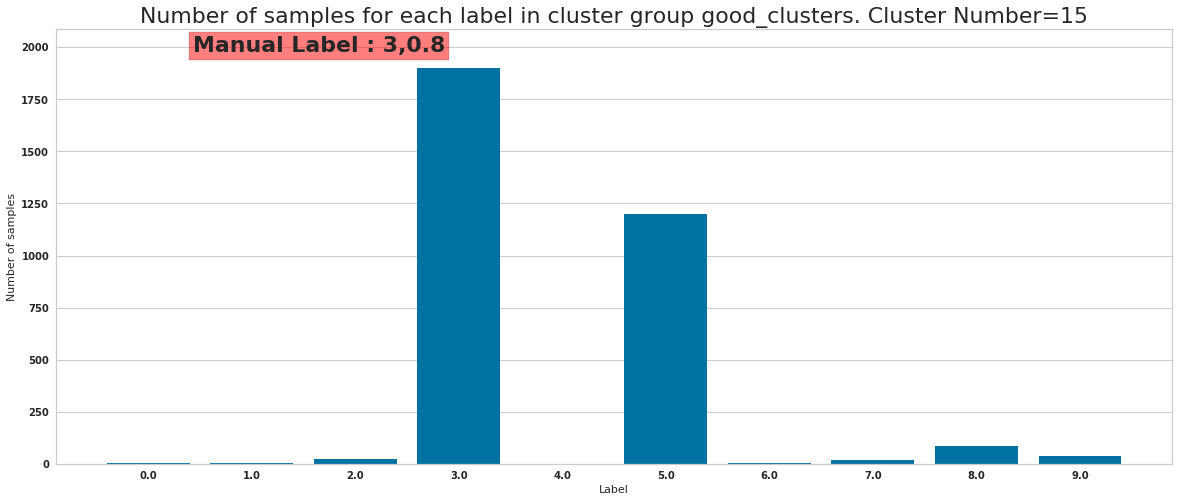

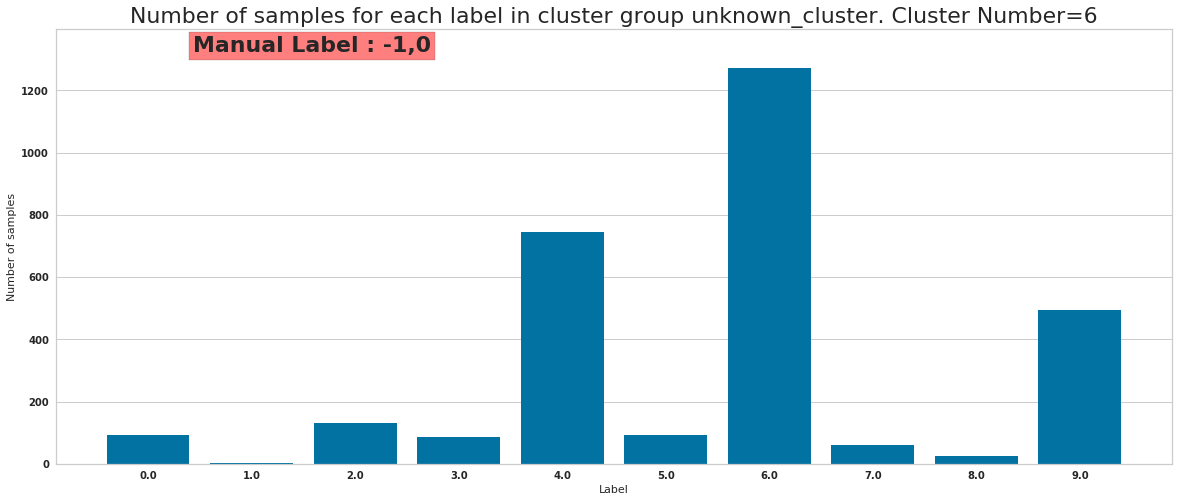

In [136]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,5,1,8,
                                           8,9,-1,0,
                                           2,1,9,6,
                                           3,0,9,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,1,1,
                                               1,1,0,1,
                                               0.9,1,0.9,0.9,
                                               1,1,0.9,0.8
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


6
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


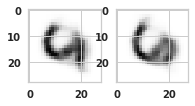

In [137]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [138]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [139]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


6
2
Skipping distance computation for unknown cluster
Manual Label 7
(4396, 54) (4396, 32)
Num correct=4285
Cluster 0 Manual Label 7 Percentage correct 97.47497725204731
********************************
Manual Label 5
(3305, 54) (3305, 32)
Num correct=2327
Cluster 1 Manual Label 5 Percentage correct 70.40847201210288
********************************
Manual Label 1
(4762, 54) (4762, 32)
Num correct=4061
Cluster 2 Manual Label 1 Percentage correct 85.27929441411172
********************************
Manual Label 8
(3938, 54) (3938, 32)
Num correct=2393
Cluster 3 Manual Label 8 Percentage correct 60.76688674454038
********************************
Manual Label 8
(7812, 54) (3874, 32)
Num correct=4645
Cluster 4 Manual Label 8 Percentage correct 59.459805427547366
********************************
Manual Label 9
(3523, 54) (3523, 32)
Num correct=1850
Cluster 5 Manual Label 9 Percentage correct 52.512063582174285
********************************
unknown
<class 'dict'>
['unknown_cluster']
*******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

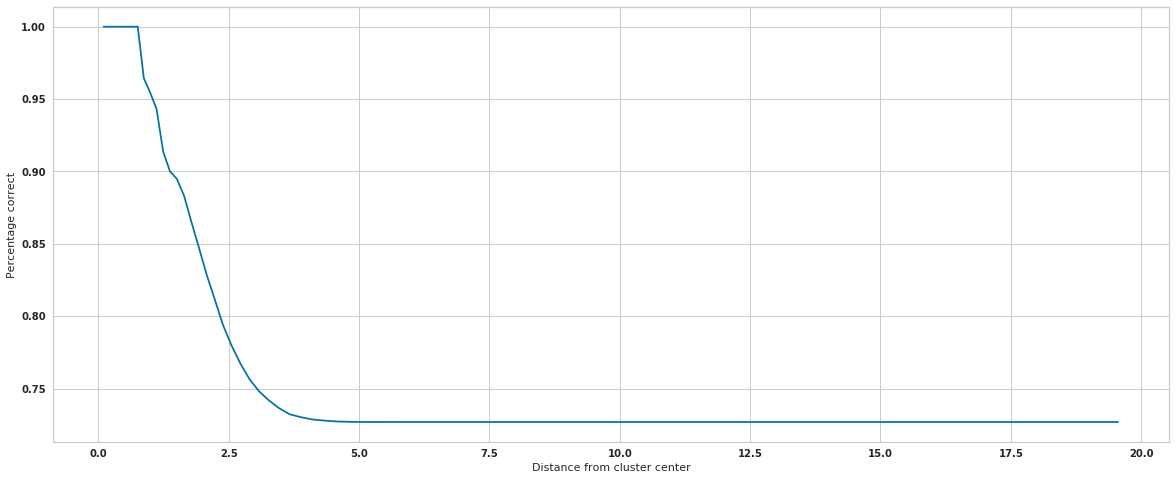

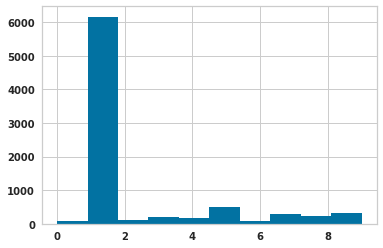

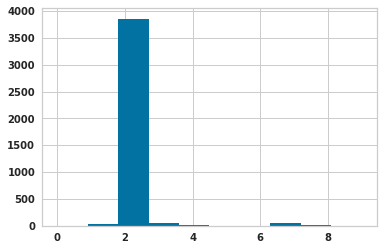

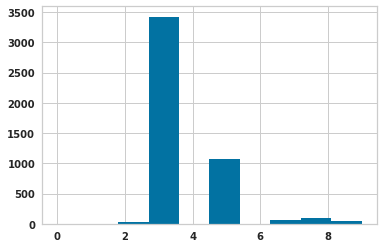

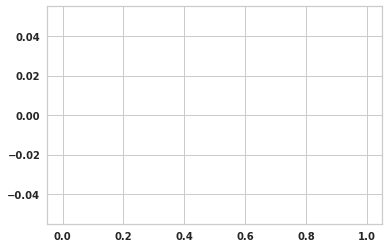

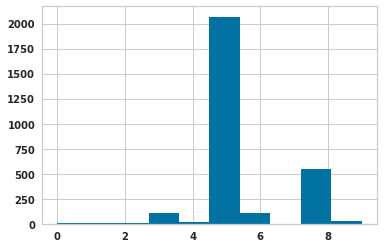

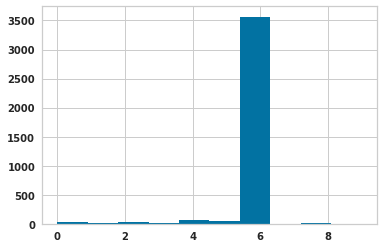

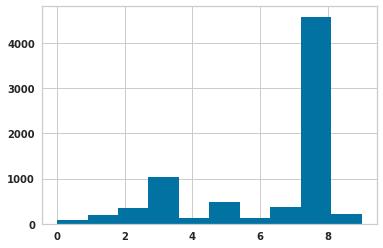

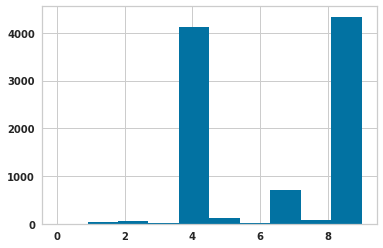

In [140]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [142]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56841
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [141]:
num_epochs

9